# Nasa Predictive Maintenance (RUL)
## Importing & Preprocessing
Aircraft components are susceptible to degradation, which affects directly their reliability and performance. This notebook is directted to predict the remaining useful life (RUL) based on the entire life cycle data in order to provide the necessary maintenance behavior. 

In [ ]:
# -- Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# -- Model --
# Later
# -- Error Metrics --
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# -- Model Selection --
from sklearn.model_selection import train_test_split, cross_val_score
# -- Preprocessing --
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
np.random.seed(17)

We have to define feature names

In [ ]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

Let's import train and validation data, FD0001 subset corresponds to HPC failure of the engine, note: train data will be splitted to train/test sets in the modeling part

In [ ]:
from pathlib import Path

data_path = Path("..") / "data" / "CMaps"


df_train = pd.read_csv(data_path / "train_FD001.txt",
                       sep=r'\s+', header=None, index_col=False, names=col_names)
df_test = pd.read_csv( data_path / "test_FD001.txt",
                      sep=r'\s+', header=None, index_col=False, names=col_names)
y_valid = pd.read_csv(data_path /"RUL_FD001.txt",
                     sep=r'\s+', header=None, names=['RUL'])
print(f"Test Shape: {df_test.shape}\nTrain Shape:{df_train.shape}\nRUL Labels: {y_valid.shape}")
print(f"Percentage of the test-set: {len(df_test)/(len(df_train)+len(df_test))*100:.3f}%")

Test Shape: (13096, 26)
Train Shape:(20631, 26)
RUL Labels: (100, 1)
Percentage of the test-set: 38.829%


With `r's+'` we make raw strings (this treats backslashes as literal characters)

In [ ]:
df_train.describe().transpose()

count         mean           std        min        25%  \
unit_number  20631.0    51.506568  2.922763e+01     1.0000    26.0000   
time_cycles  20631.0   108.807862  6.888099e+01     1.0000    52.0000   
setting_1    20631.0    -0.000009  2.187313e-03    -0.0087    -0.0015   
setting_2    20631.0     0.000002  2.930621e-04    -0.0006    -0.0002   
setting_3    20631.0   100.000000  0.000000e+00   100.0000   100.0000   
s_1          20631.0   518.670000  6.537152e-11   518.6700   518.6700   
s_2          20631.0   642.680934  5.000533e-01   641.2100   642.3250   
s_3          20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600   
s_4          20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600   
s_5          20631.0    14.620000  3.394700e-12    14.6200    14.6200   
s_6          20631.0    21.609803  1.388985e-03    21.6000    21.6100   
s_7          20631.0   553.367711  8.850923e-01   549.8500   552.8100   
s_8          20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500   
s_9          20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000   
s_10         20631.0     1.300000  4.660829e-13     1.3000     1.3000   
s_11         20631.0    47.541168  2.670874e-01    46.8500    47.3500   
s_12         20631.0   521.413470  7.375534e-01   518.6900   520.9600   
s_13         20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400   
s_14         20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450   
s_15         20631.0     8.442146  3.750504e-02     8.3249     8.4149   
s_16         20631.0     0.030000  1.556432e-14     0.0300     0.0300   
s_17         20631.0   393.210654  1.548763e+00   388.0000   392.0000   
s_18         20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000   
s_19         20631.0   100.000000  0.000000e+00   100.0000   100.0000   
s_20         20631.0    38.816271  1.807464e-01    38.1400    38.7000   
s_21         20631.0    23.289705  1.082509e-01    22.8942    23.2218   

                   50%        75%        max  
unit_number    52.0000    77.0000   100.0000  
time_cycles   104.0000   156.0000   362.0000  
setting_1       0.0000     0.0015     0.0087  
setting_2       0.0000     0.0003     0.0006  
setting_3     100.0000   100.0000   100.0000  
s_1           518.6700   518.6700   518.6700  
s_2           642.6400   643.0000   644.5300  
s_3          1590.1000  1594.3800  1616.9100  
s_4          1408.0400  1414.5550  1441.4900  
s_5            14.6200    14.6200    14.6200  
s_6            21.6100    21.6100    21.6100  
s_7           553.4400   554.0100   556.0600  
s_8          2388.0900  2388.1400  2388.5600  
s_9          9060.6600  9069.4200  9244.5900  
s_10            1.3000     1.3000     1.3000  
s_11           47.5100    47.7000    48.5300  
s_12          521.4800   521.9500   523.3800  
s_13         2388.0900  2388.1400  2388.5600  
s_14         8140.5400  8148.3100  8293.7200  
s_15            8.4389     8.4656     8.5848  
s_16            0.0300     0.0300     0.0300  
s_17          393.0000   394.0000   400.0000  
s_18         2388.0000  2388.0000  2388.0000  
s_19          100.0000   100.0000   100.0000  
s_20           38.8300    38.9500    39.4300  
s_21           23.2979    23.3668    23.6184

In [ ]:
null_comparison = pd.concat(
    [df_train.isnull().sum(), df_val.isnull().sum()],
    axis=1,
    keys=['Train_Nulls', 'Test_Nulls']
)
if (null_comparison==0).all().all():
    print("No missing values in either Train or Test data")
else:
    display(null_comparison)

No missing values in either Train or Test data


In [ ]:
df_train.loc[:, ['unit_number', 'time_cycles']].describe()

unit_number   time_cycles
count  20631.000000  20631.000000
mean      51.506568    108.807862
std       29.227633     68.880990
min        1.000000      1.000000
25%       26.000000     52.000000
50%       52.000000    104.000000
75%       77.000000    156.000000
max      100.000000    362.000000

The average engine breaks between 199 and 206 cycles, however the standard deviation of 46 cycles is rather big. 

In [ ]:
df_train.loc[:, 's_1':].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.556432e-14     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184

## Data Visualization & Feature Engineering
Max-Time cycle found for each unit, let's see the maximum time cycle of each unit

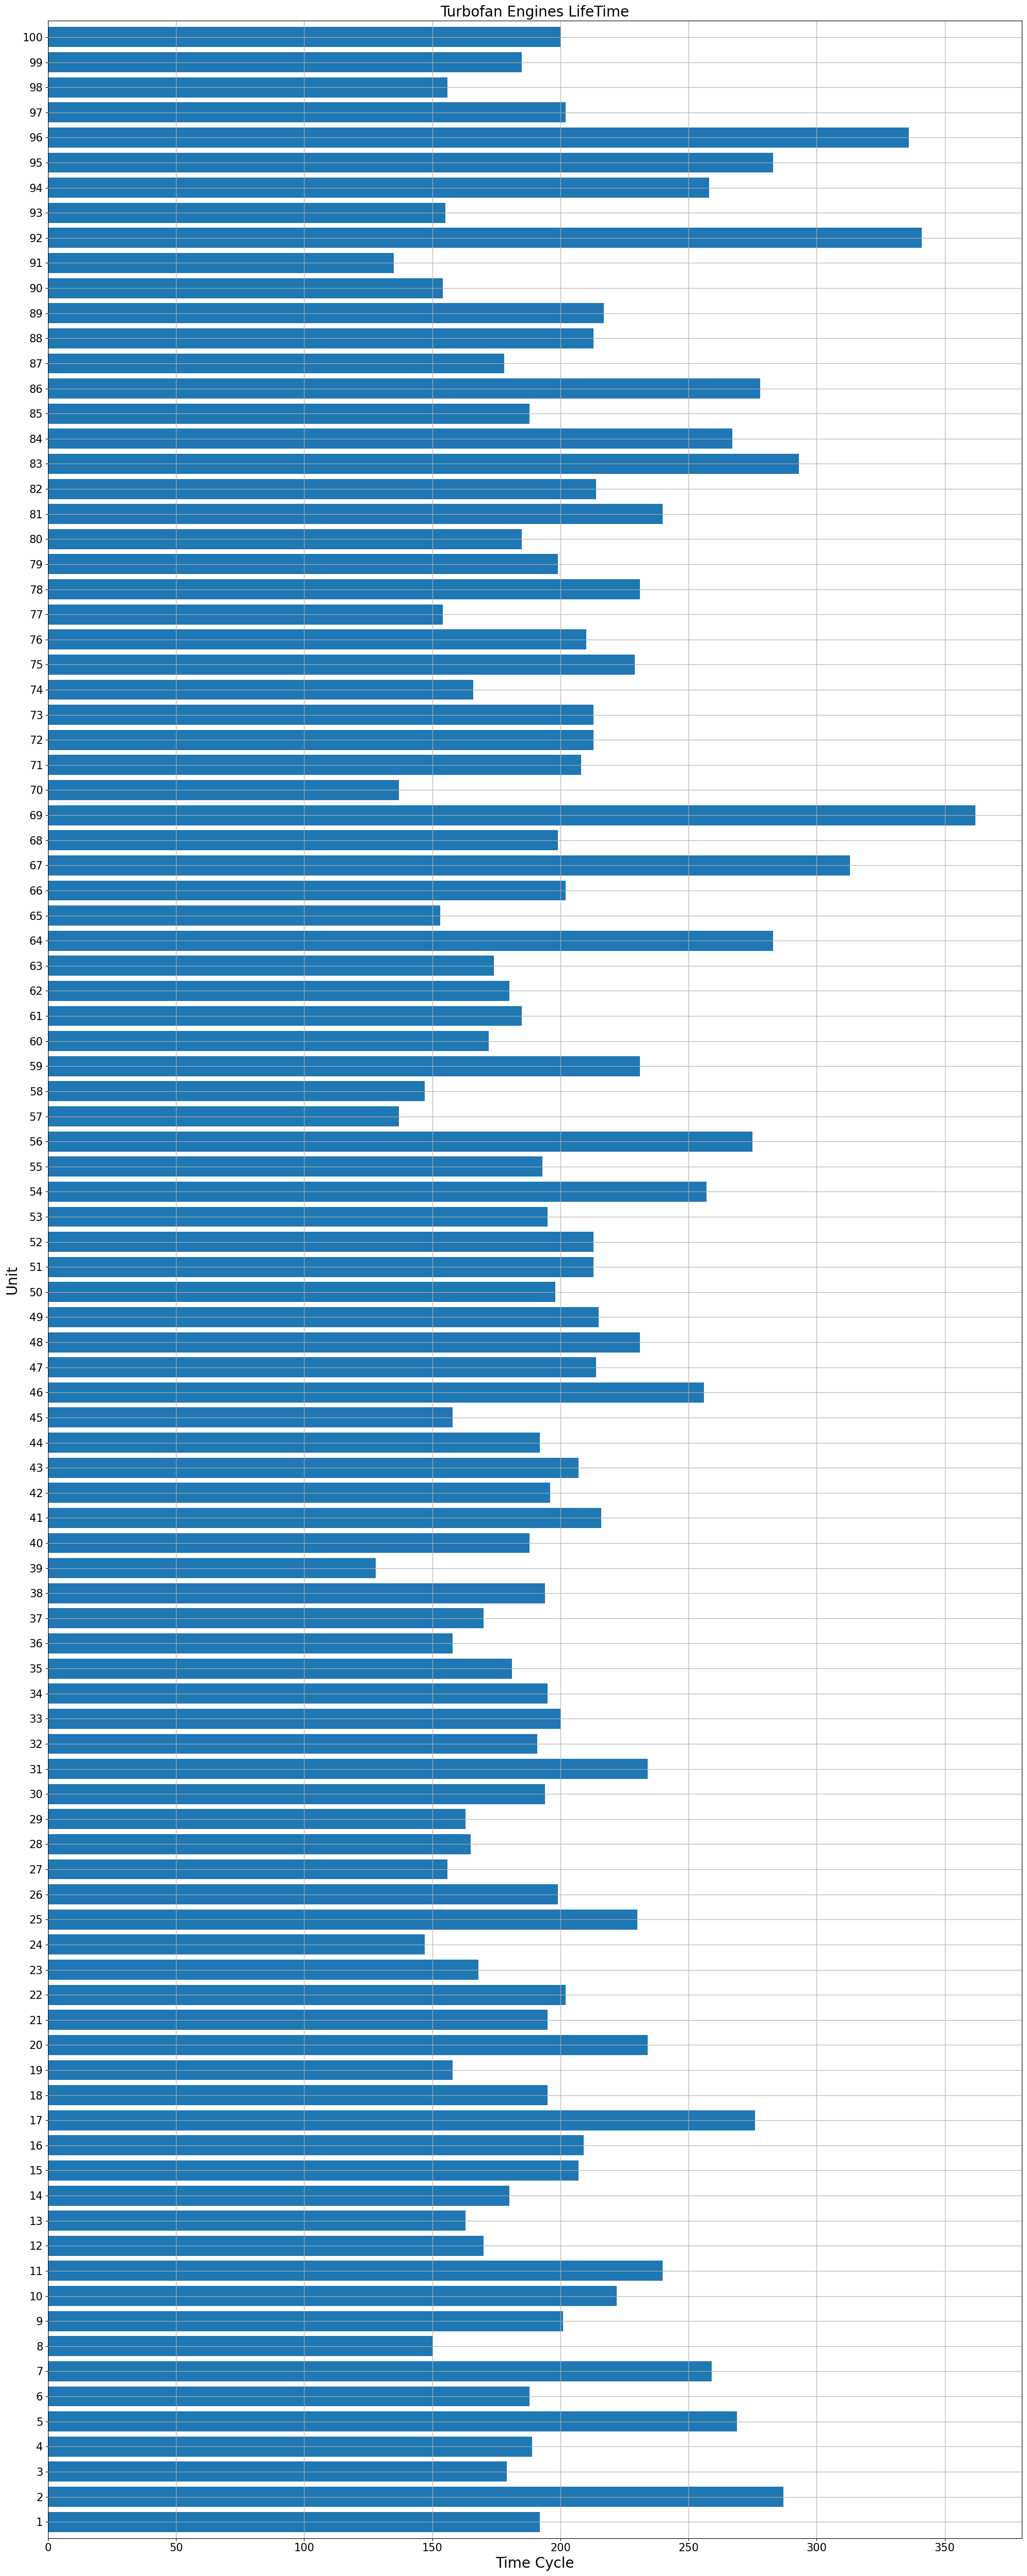

In [ ]:
max_time_cycles = df_train[index_names].groupby('unit_number').max() # Groups data by engine ID (max time_cycles)
plt.figure(figsize=(20, 50))
ax = max_time_cycles['time_cycles'].plot(kind='barh', width=0.8, 
                                         stacked=True) # Select just time_cycles 
plt.title('Turbofan Engines LifeTime', size=20)
plt.xlabel('Time Cycle', size=20)
plt.xticks(size=15)
plt.ylabel('Unit', size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

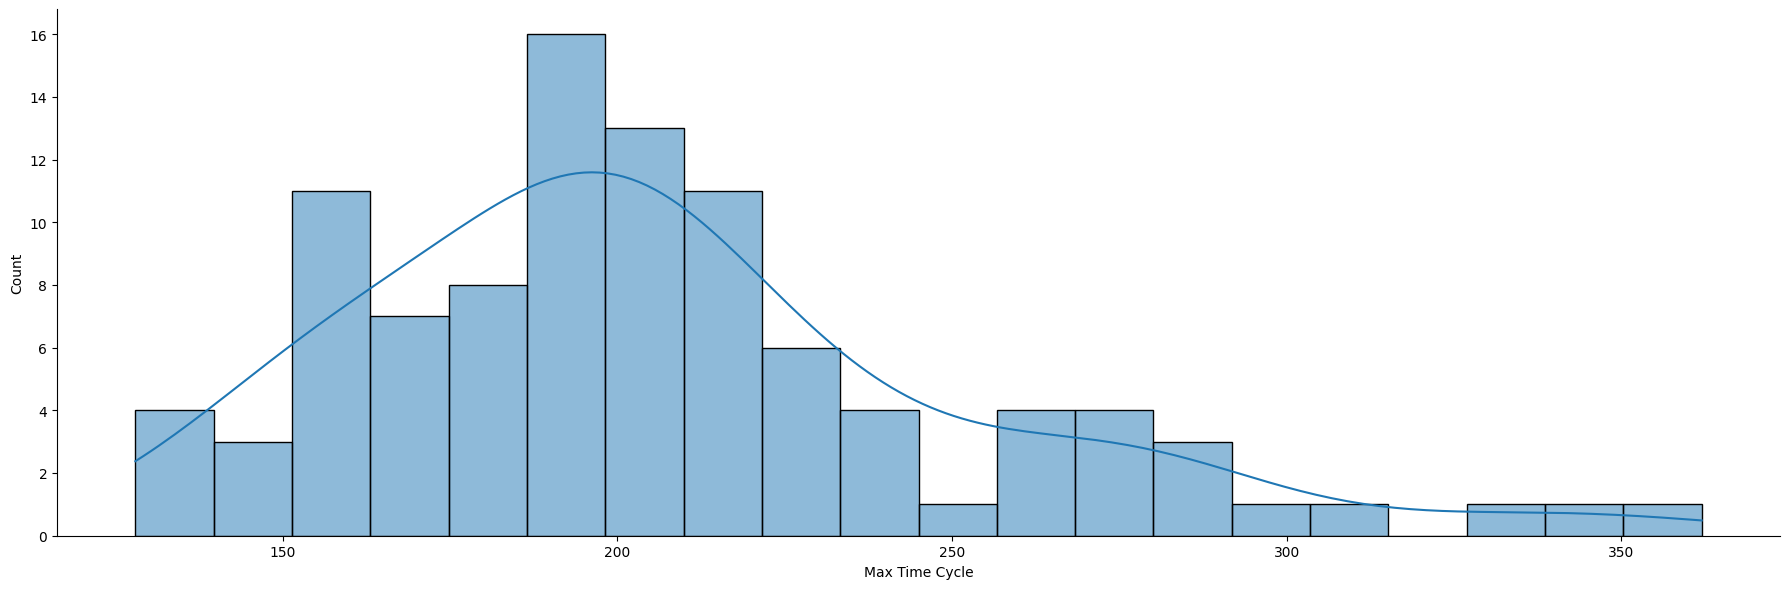

In [ ]:
sns.displot(max_time_cycles['time_cycles'], kde=True, bins=20,
            height=6, aspect=3)
plt.xlabel('Max Time Cycle');

The maximum time cycles an engine can achieve is between 190 and 219 before _failure_

### Feature: Remaining Useful Lifecycle (RUL)
This is the remaining time cycles for each unit before it fails

In [ ]:
def add_RUL(df, unit_col='unit_number', cycle_col='time_cycles', 
            rul_col='RUL', clip_min=None):
    max_cycles = df.groupby(unit_col)[cycle_col].transform('max')
    df[rul_col] = max_cycles - df[cycle_col]
    if clip_min is not None:
        df[rul_col] = df[rul_col].clip(lower=clip_min)
    return df
df_train = add_RUL(df_train)
df_train[['unit_number','RUL']]

unit_number  RUL
0                1  191
1                1  190
2                1  189
3                1  188
4                1  187
...            ...  ...
20626          100    4
20627          100    3
20628          100    2
20629          100    1
20630          100    0

[20631 rows x 2 columns]

In [ ]:
max_RUL = df_train.groupby('unit_number').max().reset_index() # Reset index keep unit_number as column
max_RUL.head()

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1          192     0.0047     0.0005      100.0  518.67  644.21   
1            2          287     0.0076     0.0006      100.0  518.67  643.94   
2            3          179     0.0058     0.0005      100.0  518.67  643.93   
3            4          189     0.0059     0.0006      100.0  518.67  644.53   
4            5          269     0.0055     0.0005      100.0  518.67  644.02   

       s_3      s_4    s_5  ...     s_13     s_14    s_15  s_16  s_17  s_18  \
0  1605.44  1432.52  14.62  ...  2388.35  8140.58  8.5227  0.03   398  2388   
1  1610.10  1431.17  14.62  ...  2388.26  8175.57  8.5377  0.03   398  2388   
2  1606.50  1438.51  14.62  ...  2388.20  8255.34  8.5363  0.03   399  2388   
3  1612.11  1434.12  14.62  ...  2388.17  8259.42  8.5462  0.03   399  2388   
4  1609.41  1434.59  14.62  ...  2388.23  8215.19  8.5410  0.03   398  2388   

    s_19   s_20     s_21  RUL  
0  100.0  39.18  23.4999  191  
1  100.0  39.24  23.6005  286  
2  100.0  39.23  23.5181  178  
3  100.0  39.21  23.5074  188  
4  100.0  39.29  23.5503  268  

[5 rows x 27 columns]

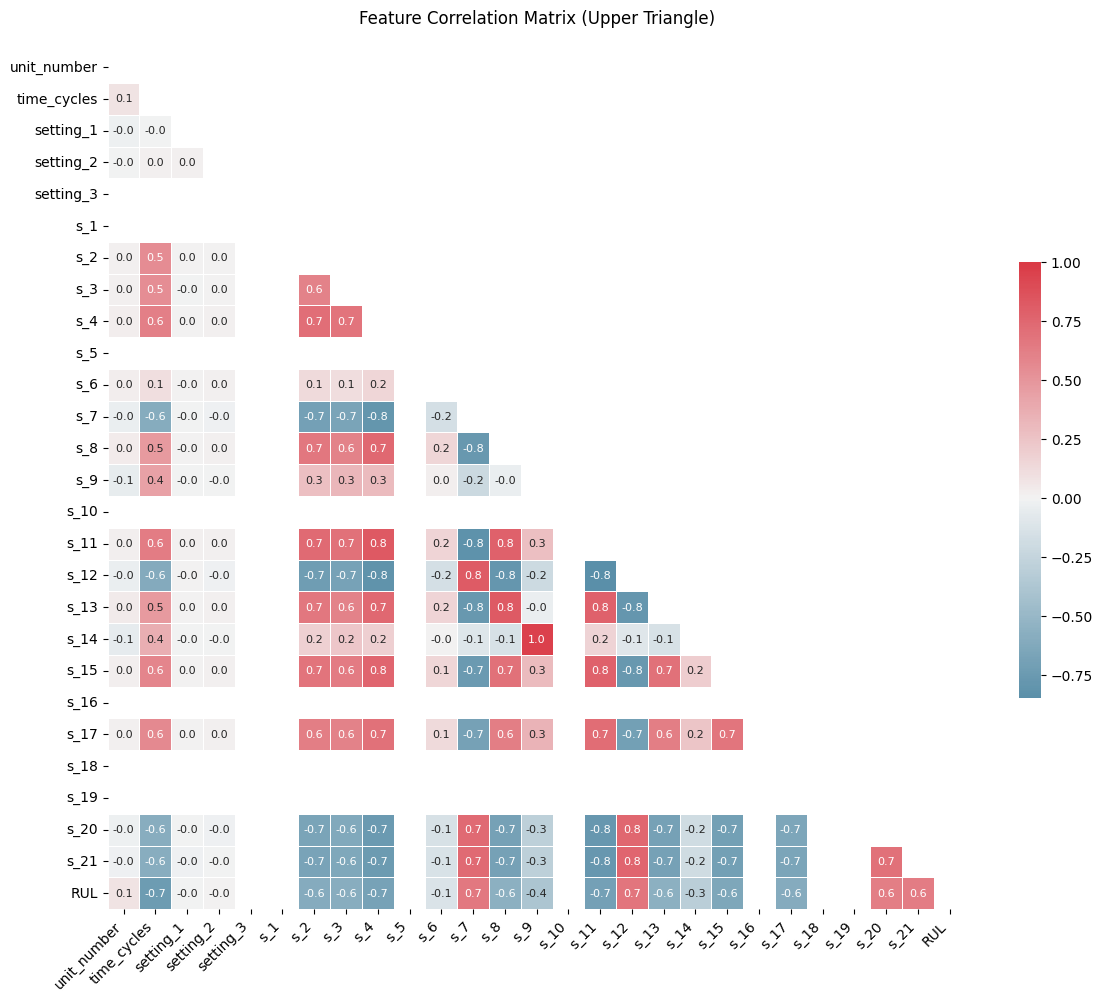

In [ ]:
corr = df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # this removes redundancy
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=True,          
    fmt=".1f",         
    annot_kws={"size": 8},
    vmax=1.0,          
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.5}
)
plt.title("Feature Correlation Matrix (Upper Triangle)", pad=20)
plt.xticks(rotation=45, ha="right")  # Rotate x-labels
plt.tight_layout()
plt.show()

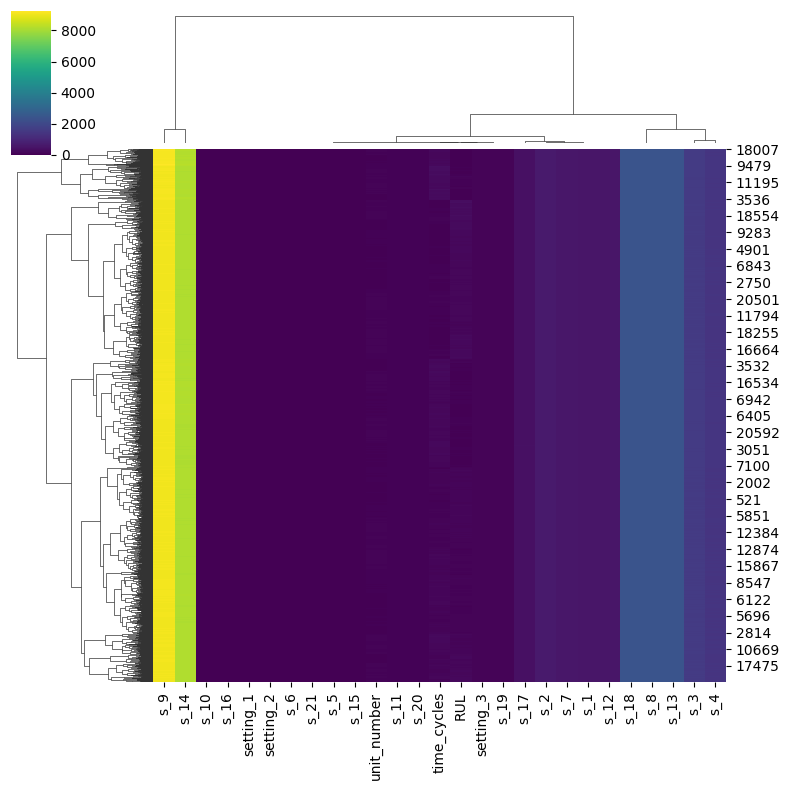

In [ ]:
numeric_df = df_train.select_dtypes("number")  # Only numeric columns
sns.clustermap(numeric_df, cmap="viridis", figsize=(8, 8))
plt.show()

WE have features highly correlated (multicollinearity), features with low correlation may be dropped later.

1. Can we effciently predict the RUL time for the engine (error significance)?
2. Which features are the most important for predicting the failure of the turbofan engine?
3. Does adding historical data improve our model?
4. How can we turn our problem to a classification one?

First, let's match each sensor with it's real signifcation

In [ ]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

A low pressure compressor (LPC) and high pressure compressor (HPC) supply compressed high temperature, high pressure gases to the combustor. Low pressure turbine (LPT) can decelerate and pressurize air to improve the chemical energy conversion efficiency of aviation kerosene. High pressure turbines (HPT) generate mechanical energy by using high temperature and high pressure gas strike turbine blades. Low-pressure rotor (N1), high-pressure rotor (N2), and nozzle guarantee the combustion efficiency of the engine.

Let's plot the evolution of features (sensors) along with the evolution with RUL

In [ ]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   #For a better visualisation, we plot the sensors signals of 20 units only
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

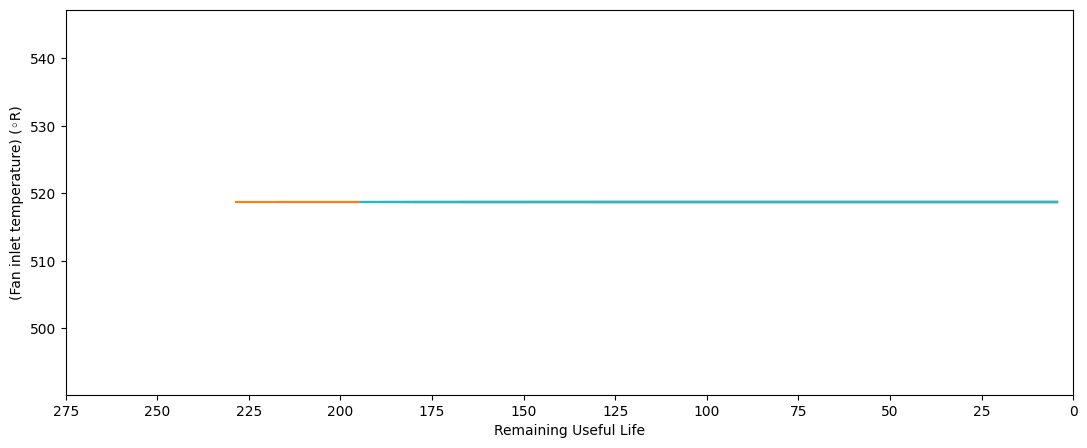

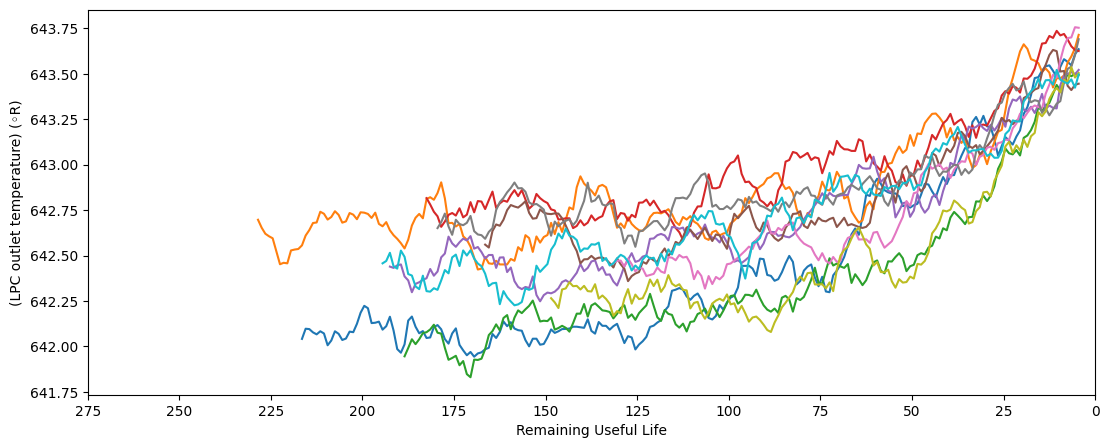

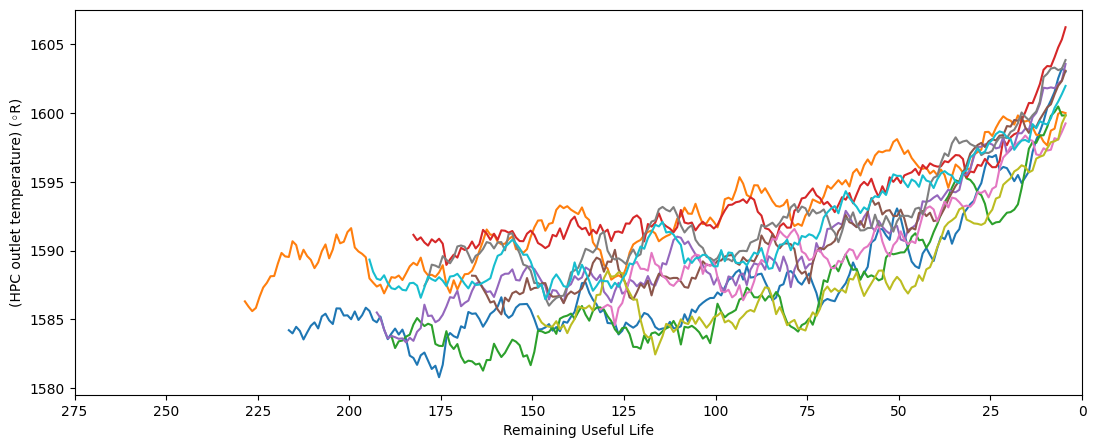

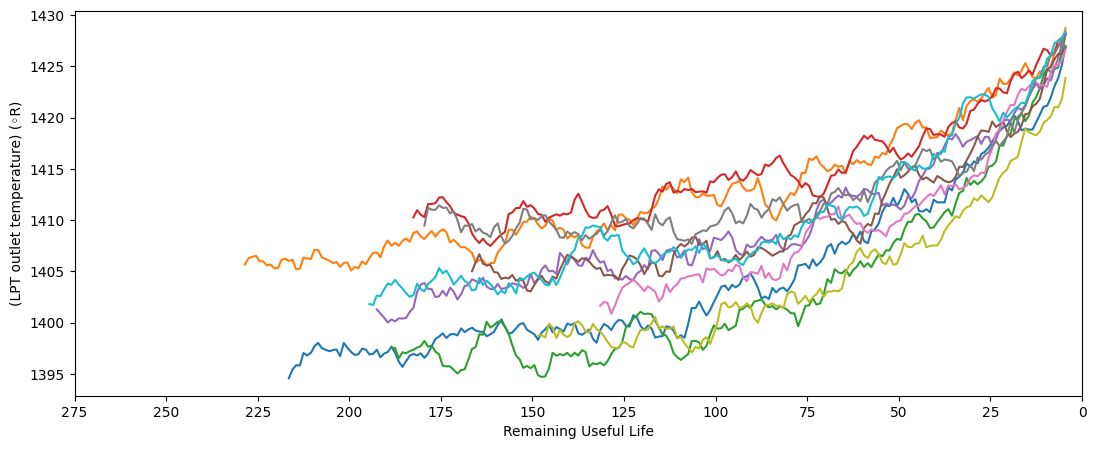

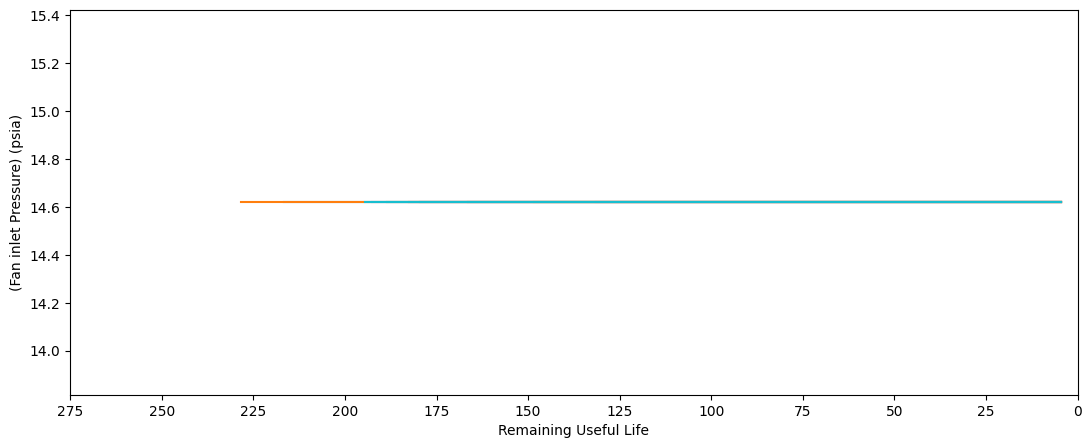

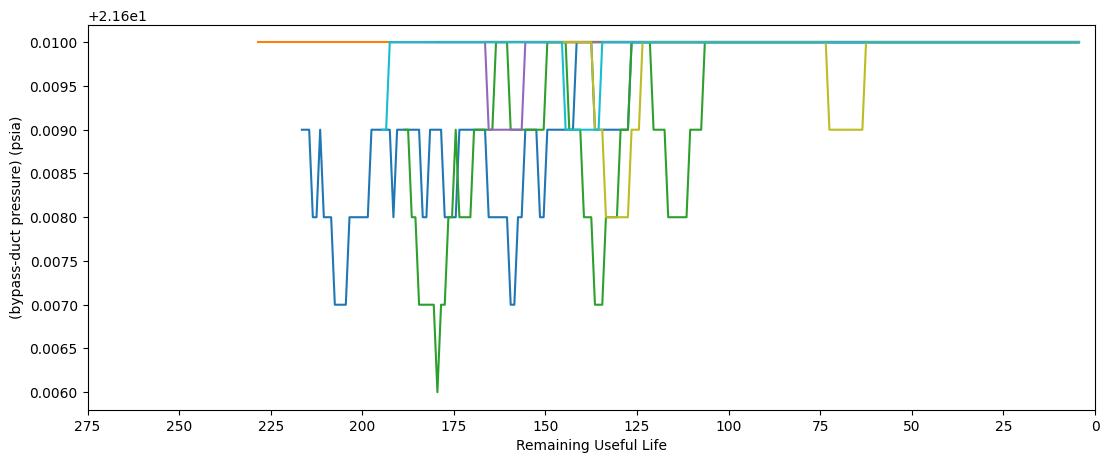

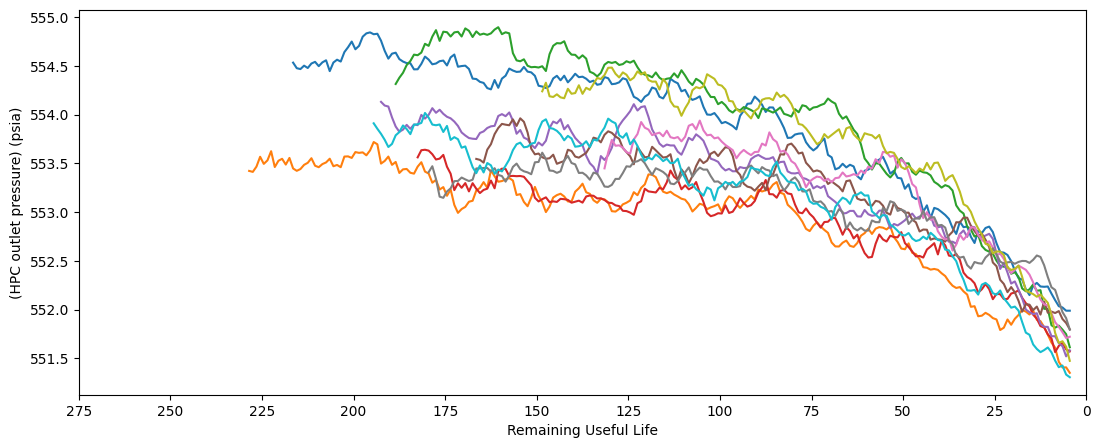

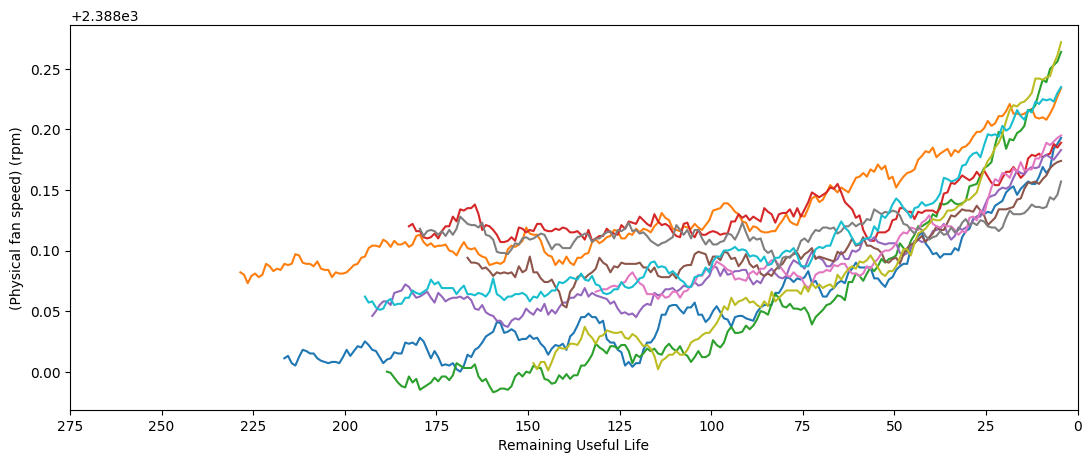

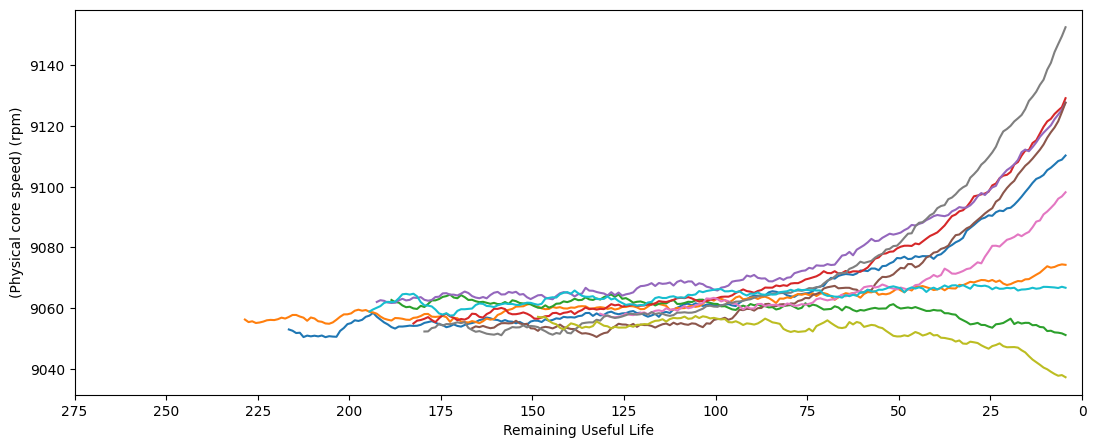

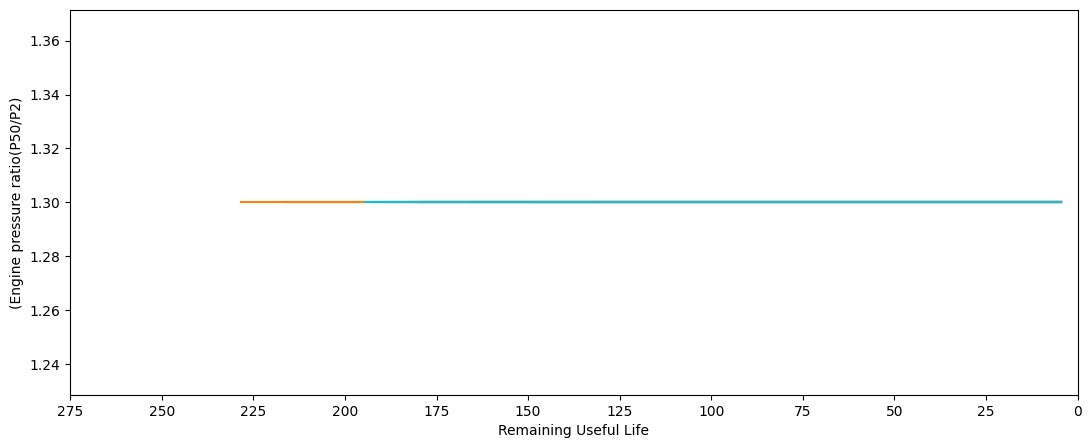

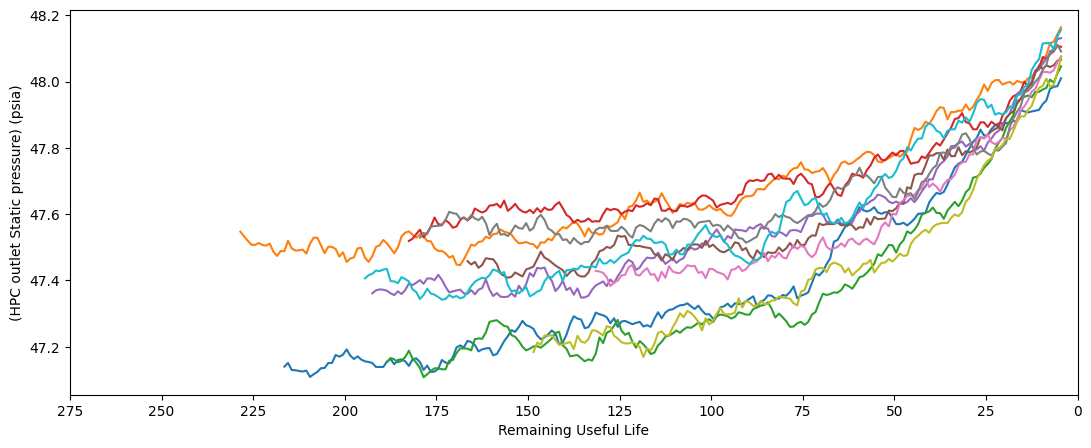

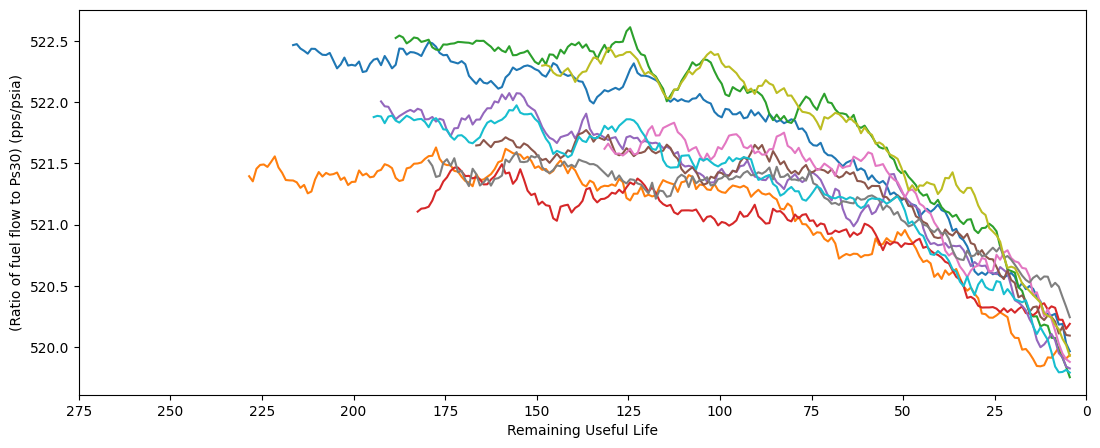

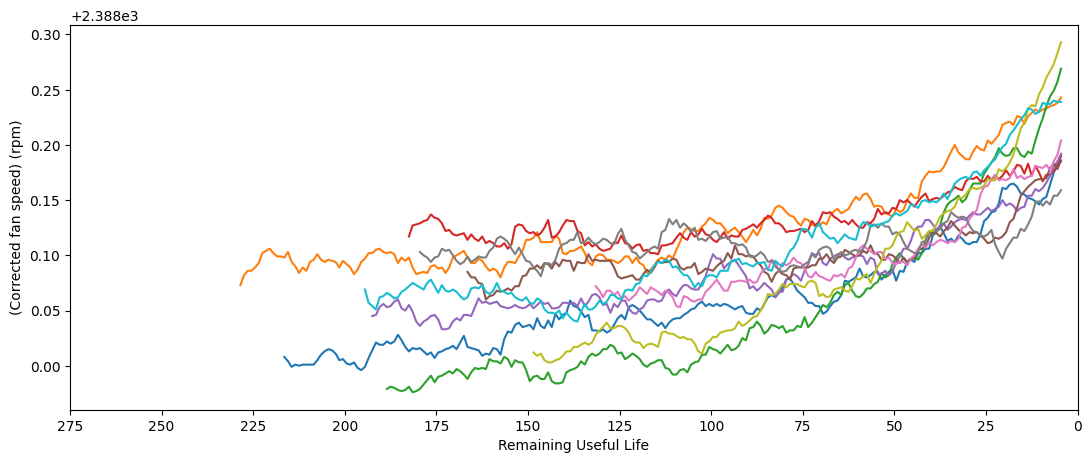

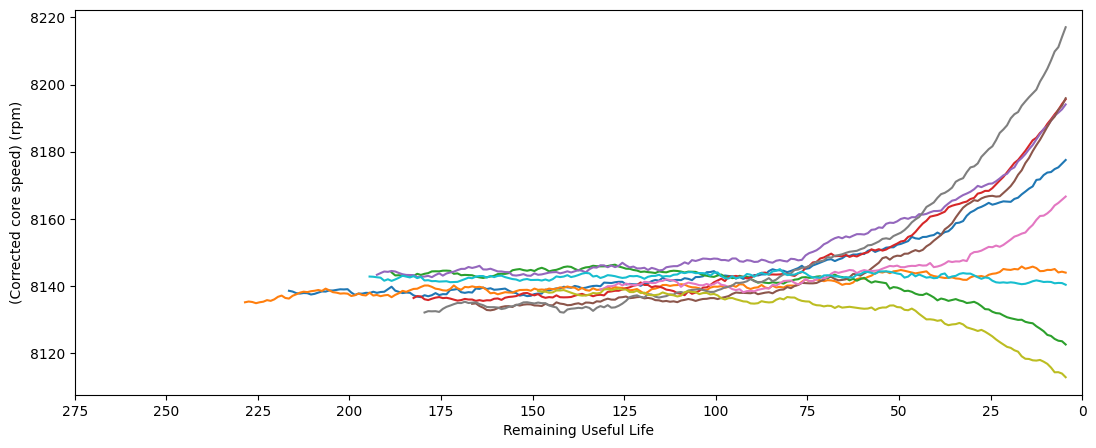

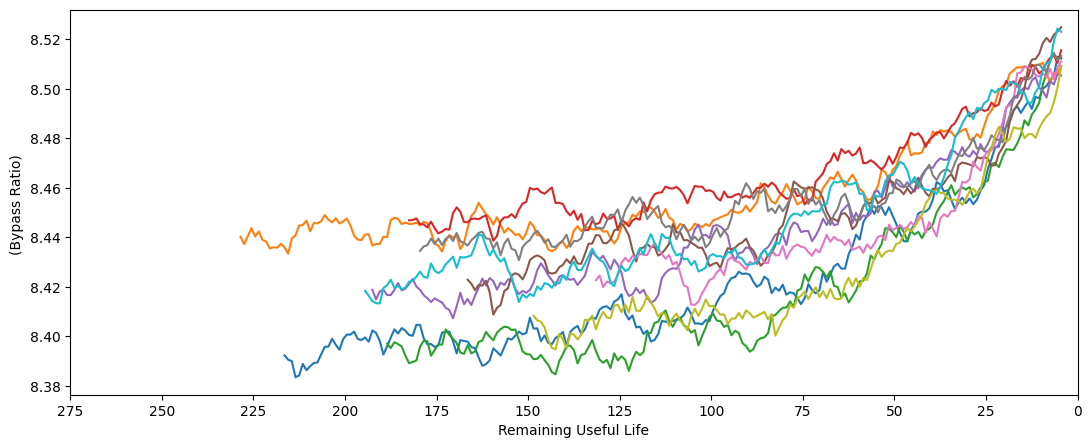

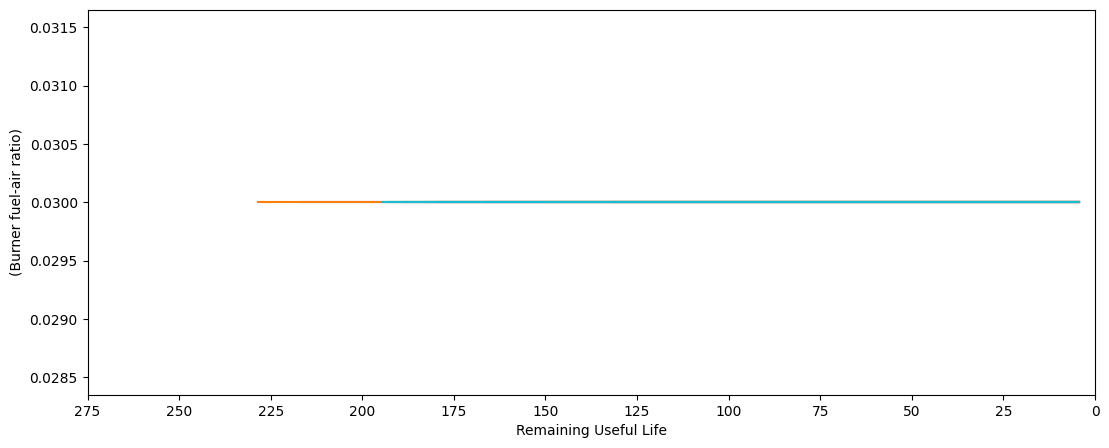

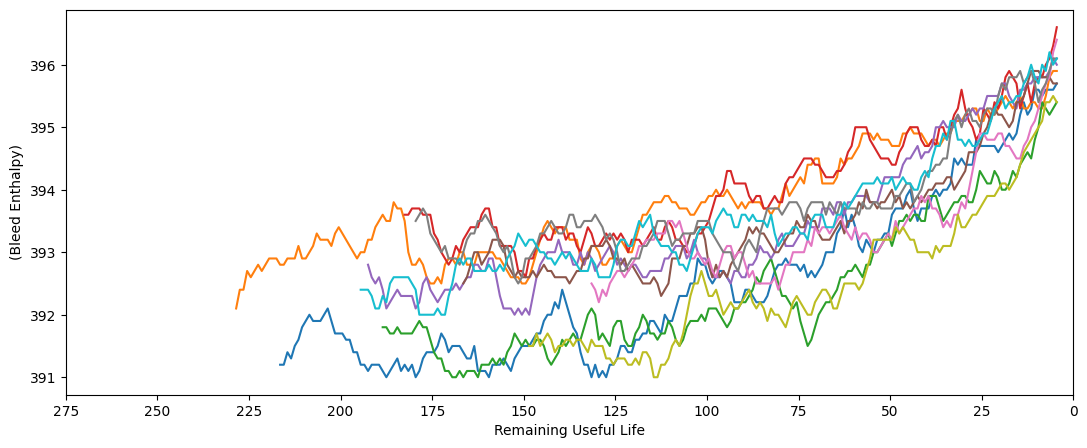

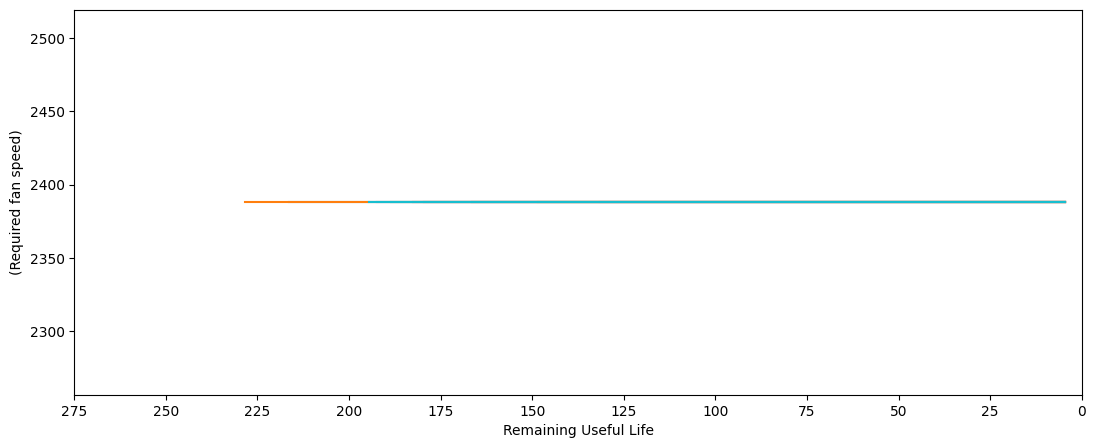

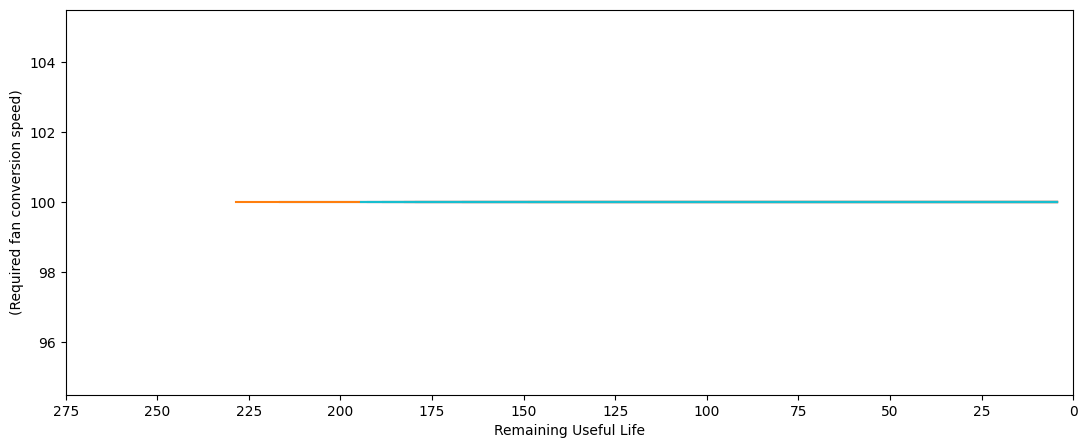

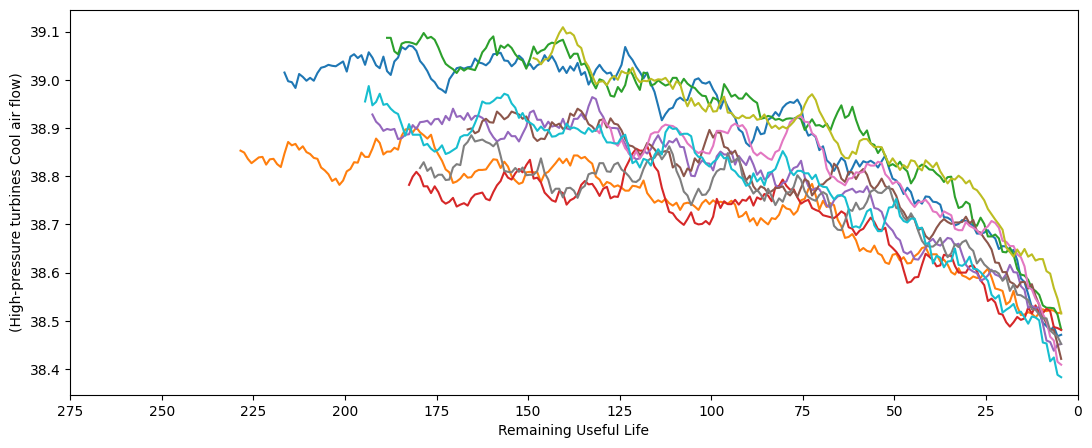

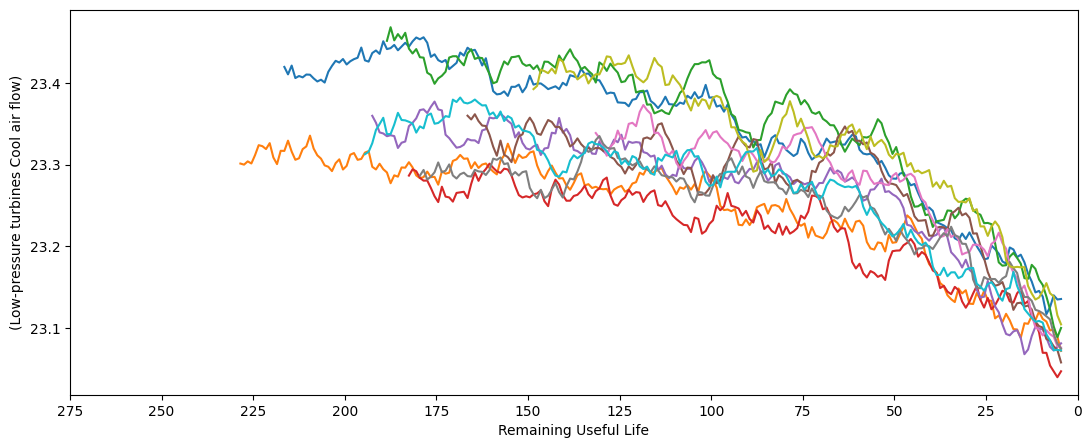

In [ ]:
for i in range(1,22):
    try:
        plot_signal(df_train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

Sensors that are constant, don't influence the RUL $\rightarrow$ we can drop those ones.

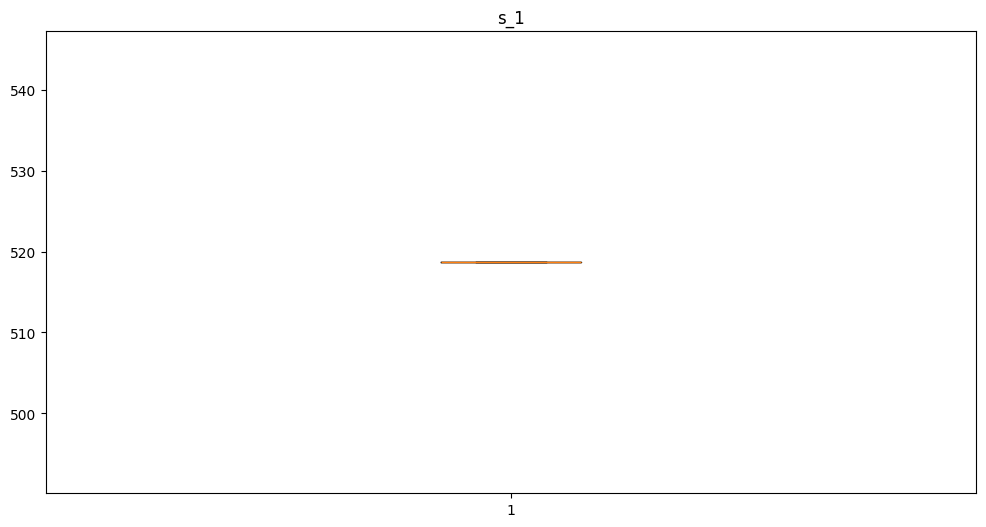

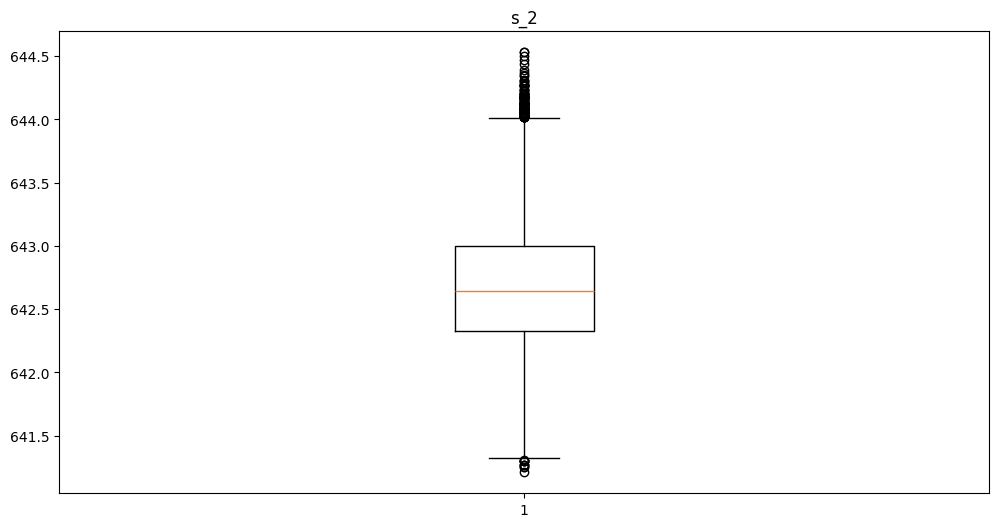

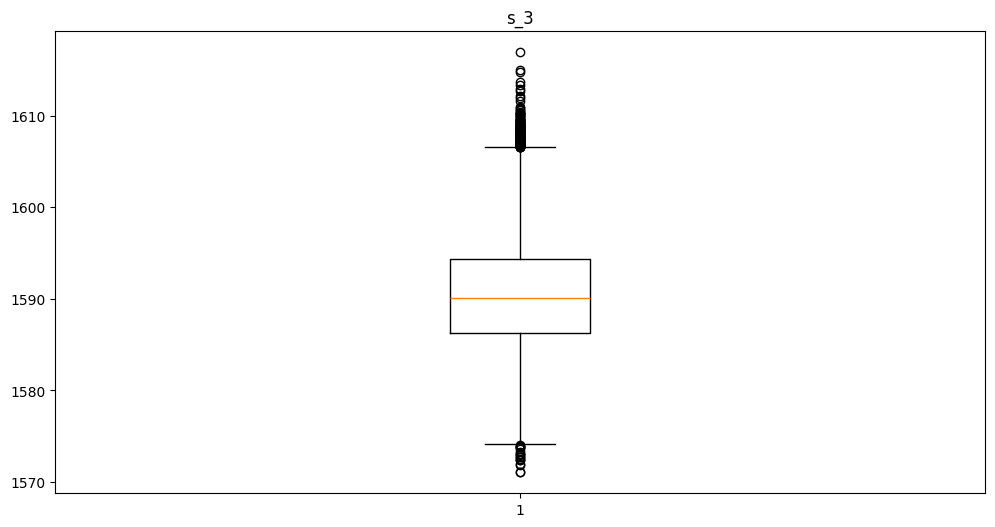

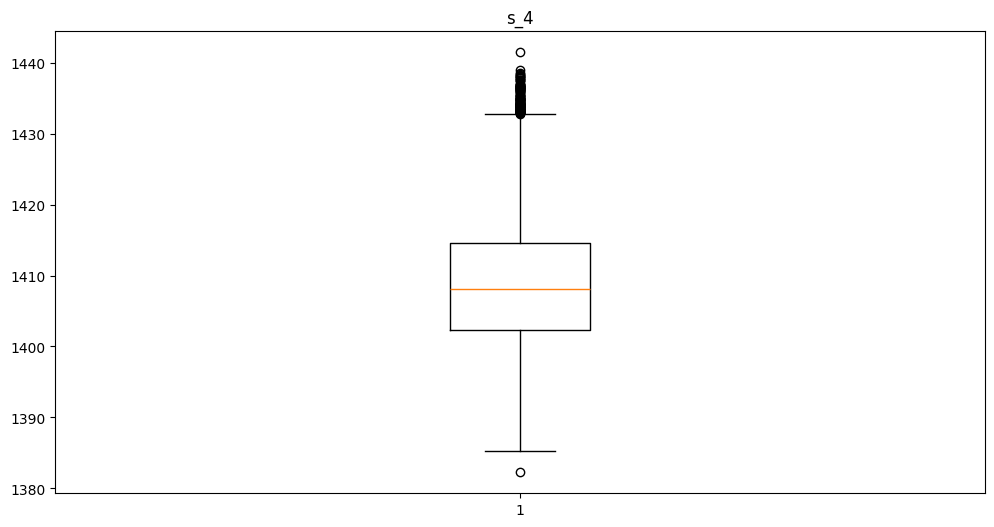

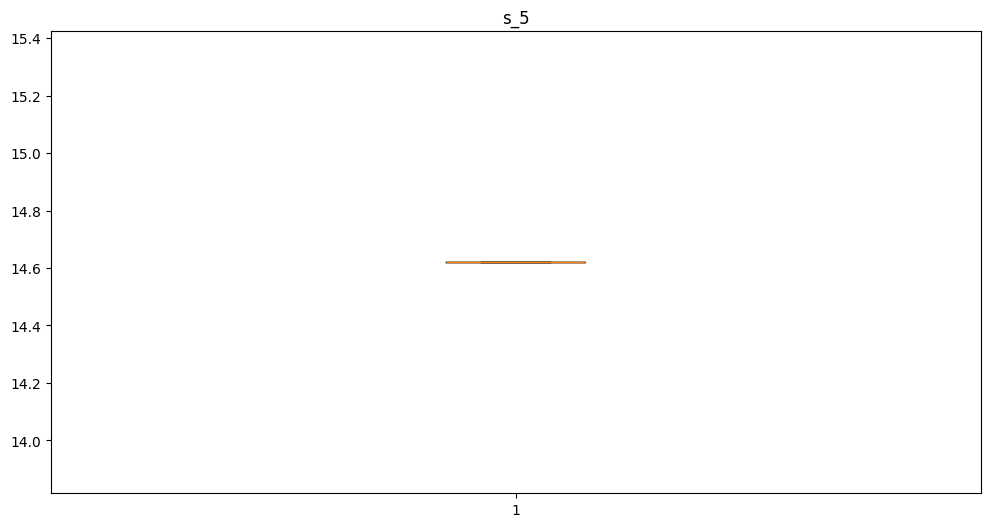

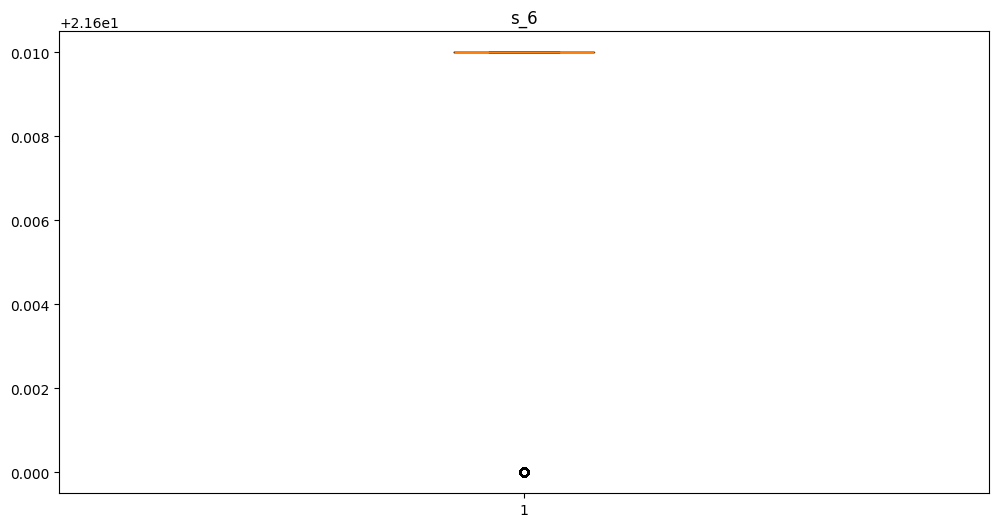

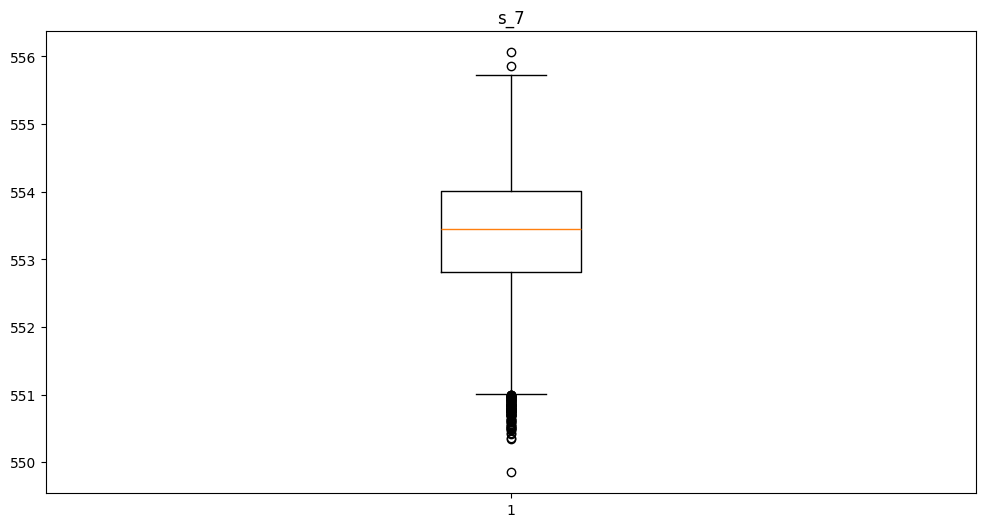

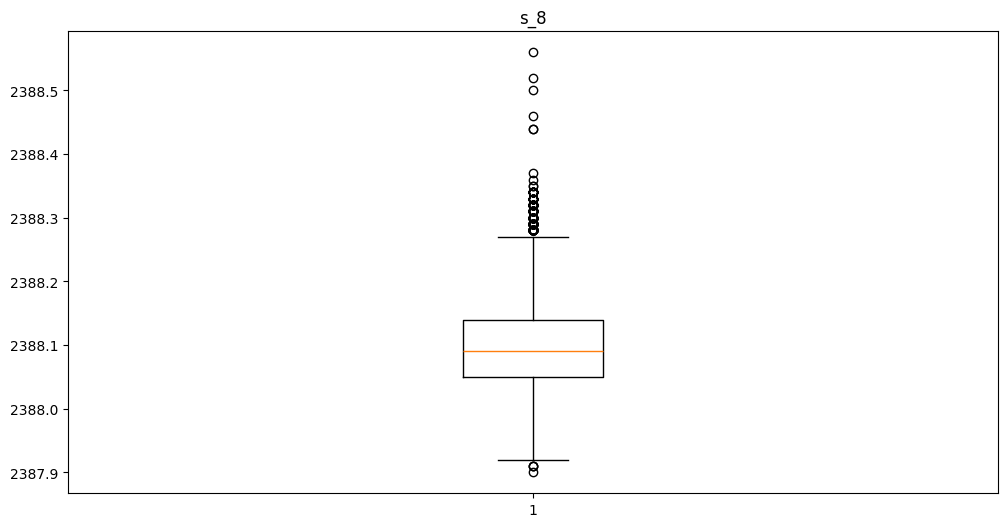

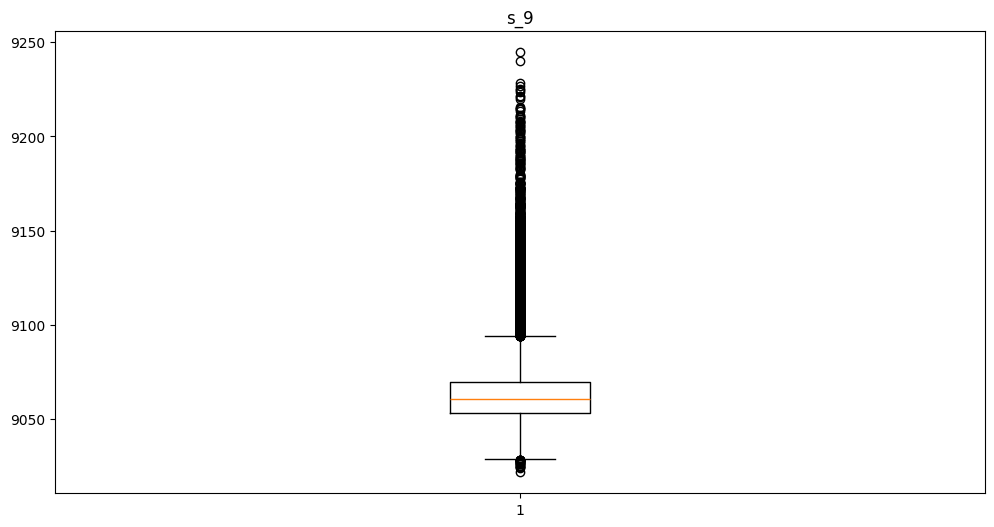

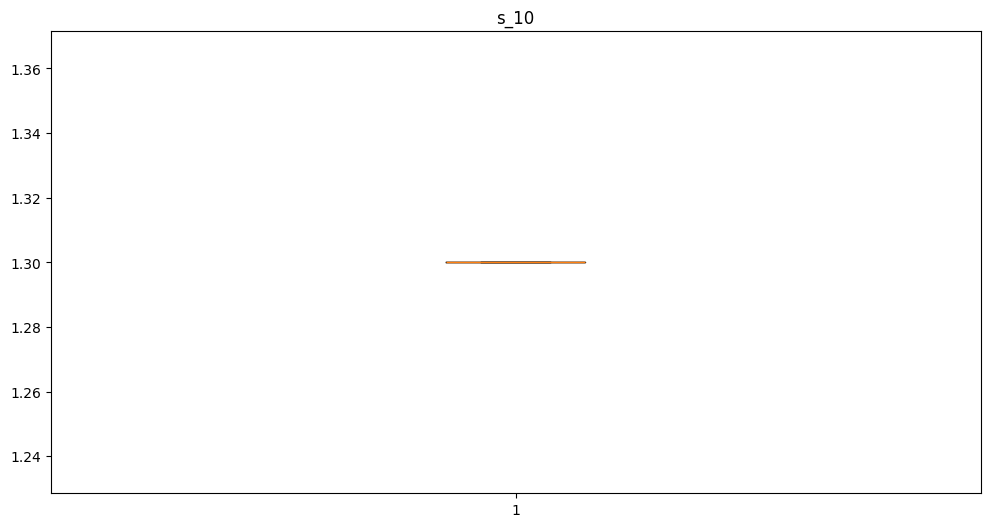

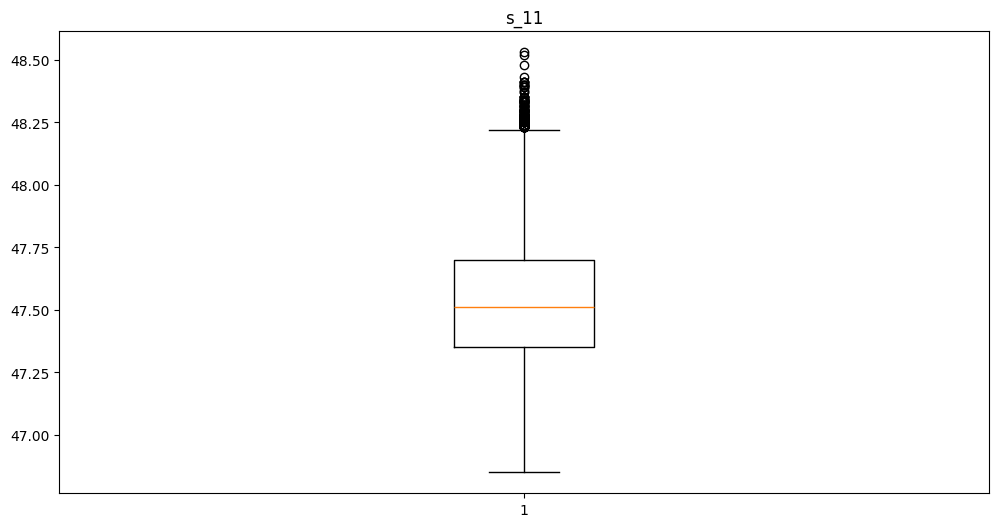

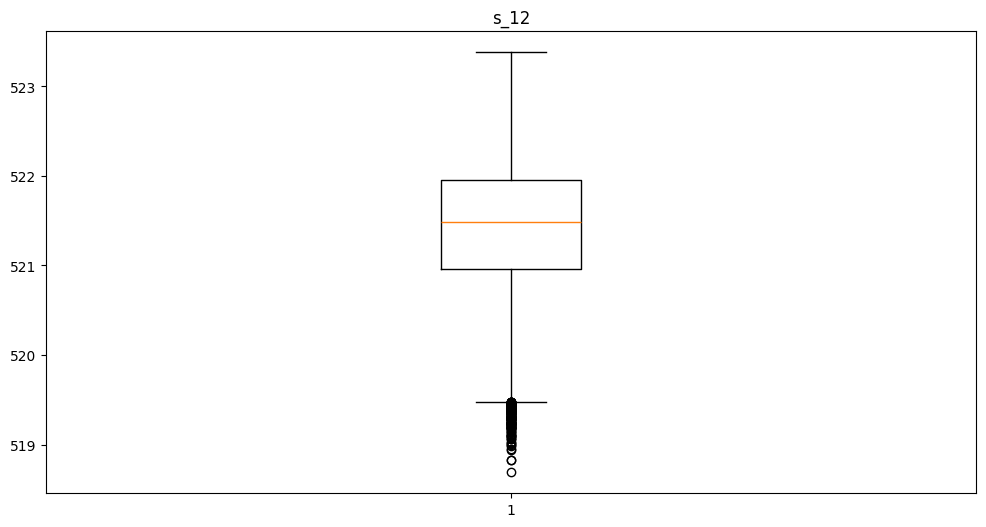

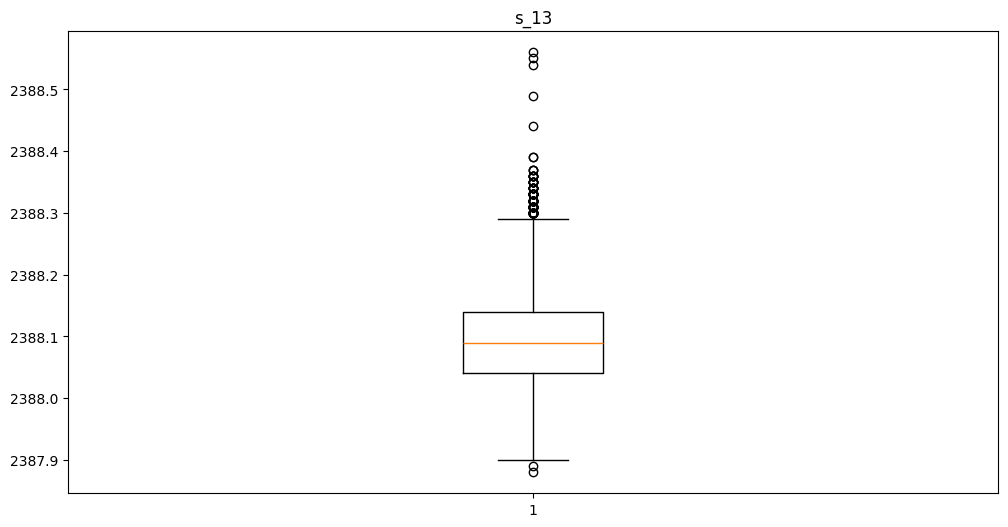

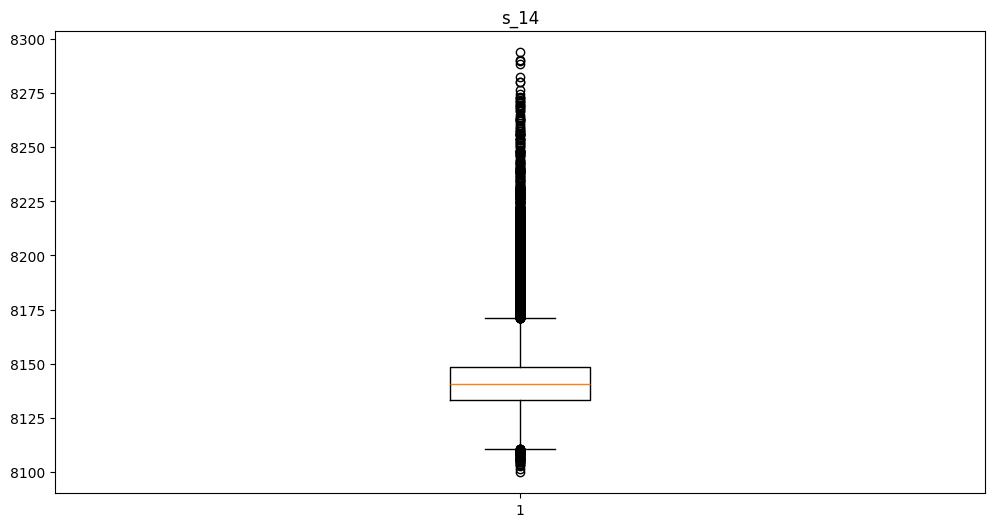

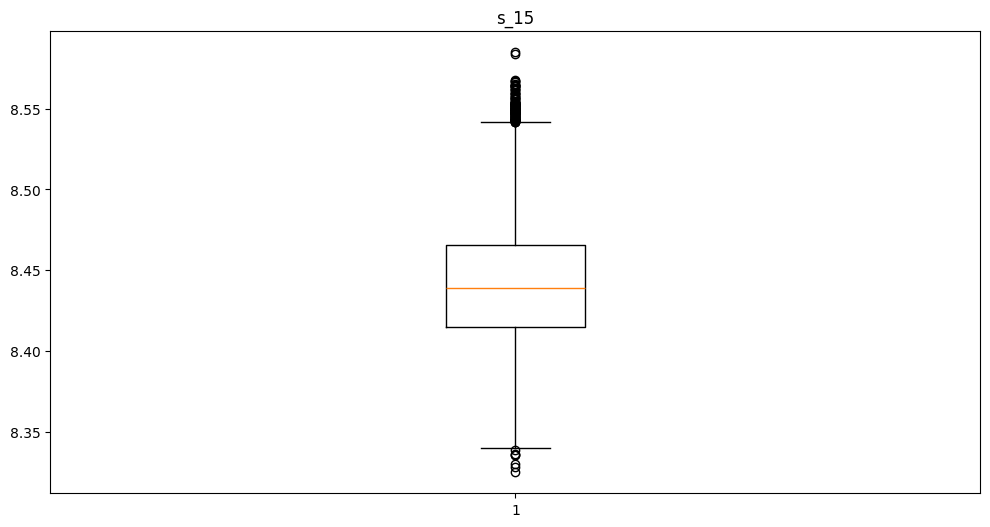

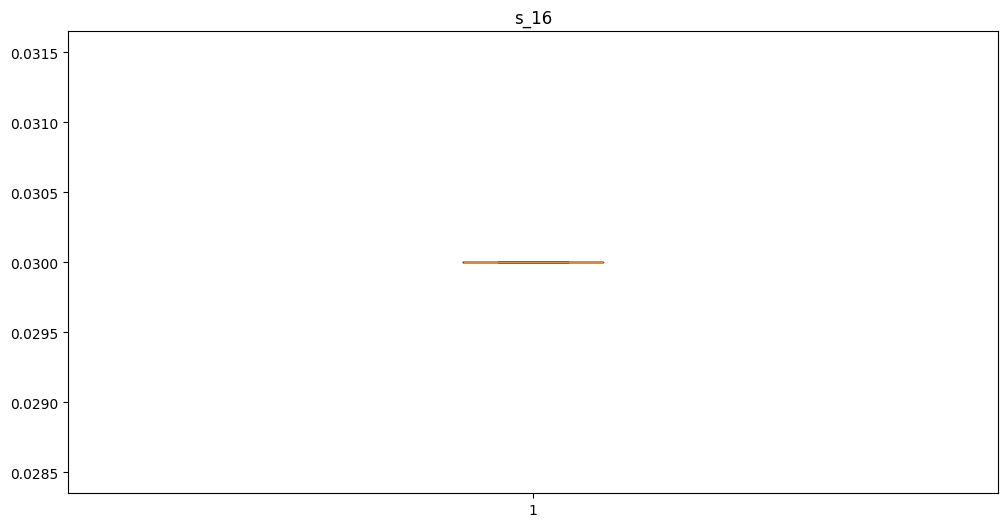

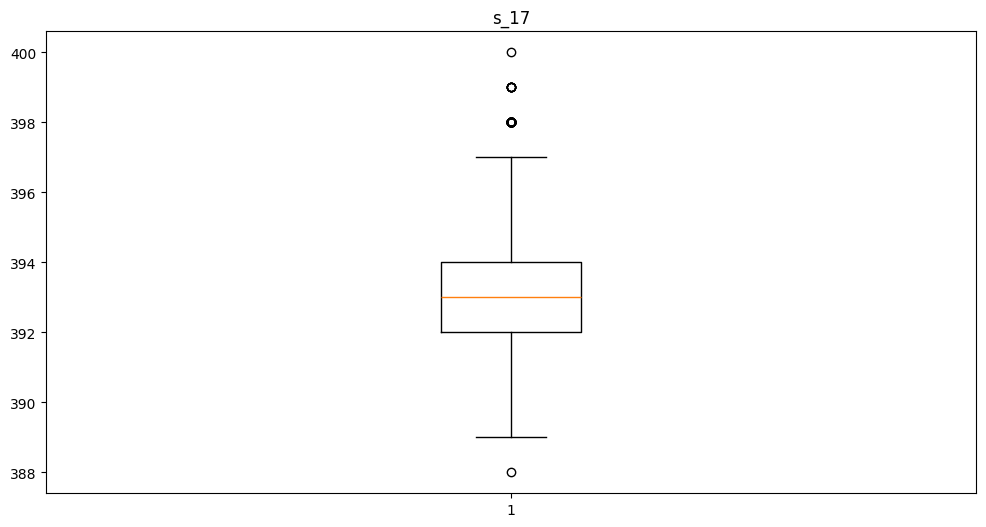

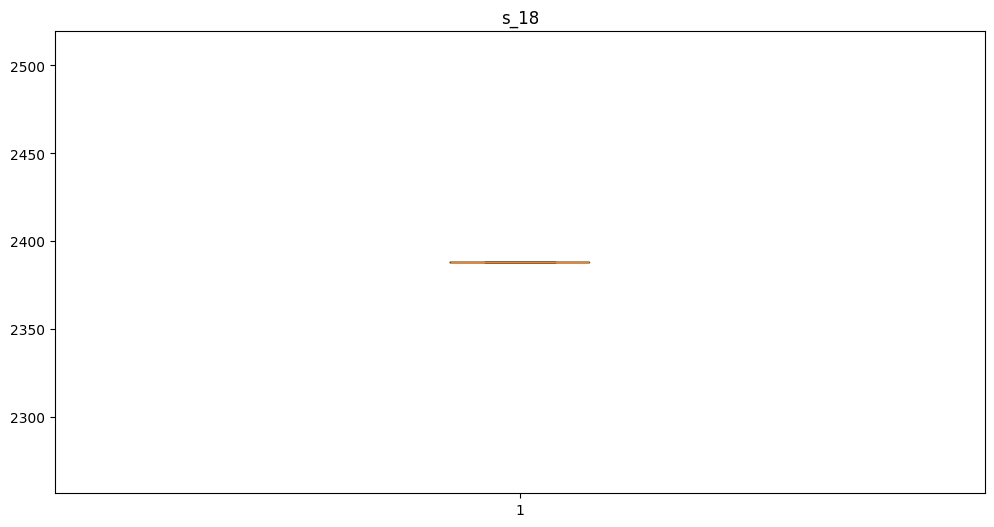

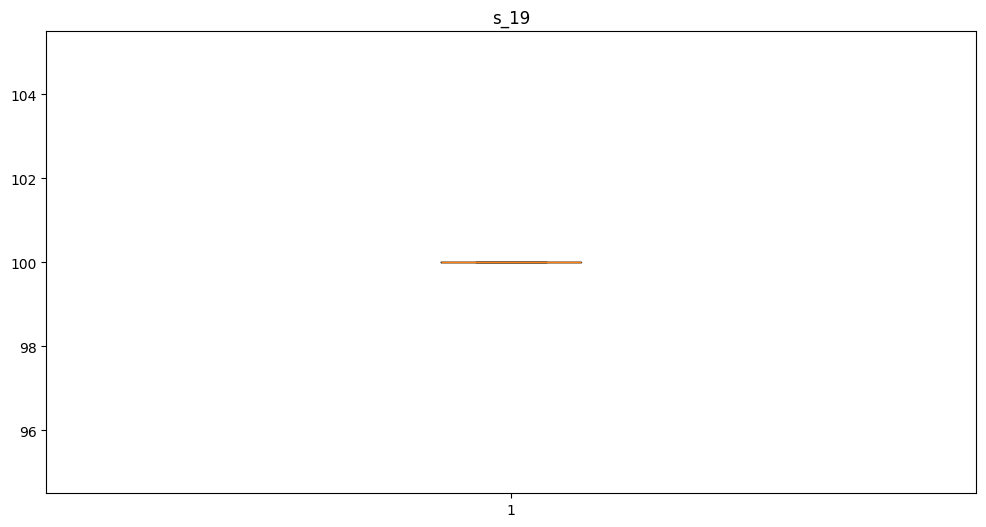

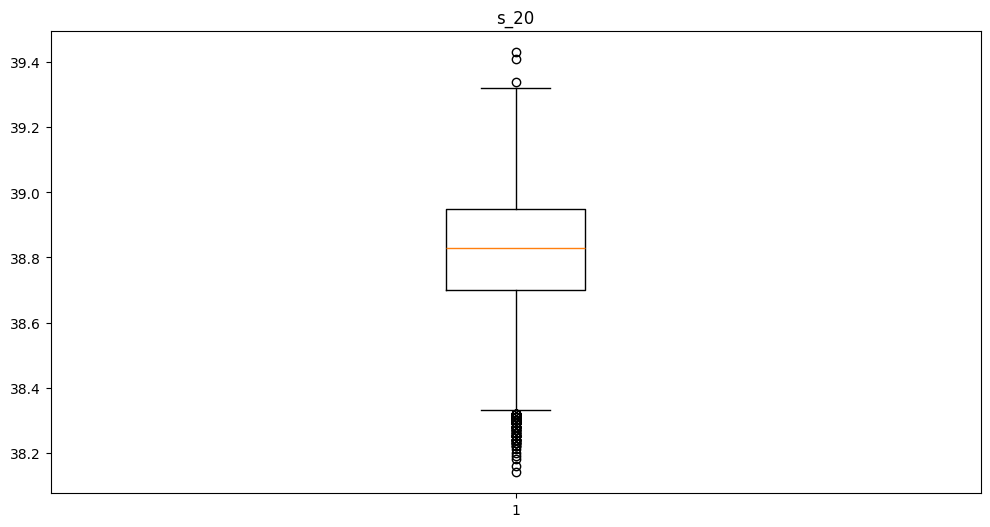

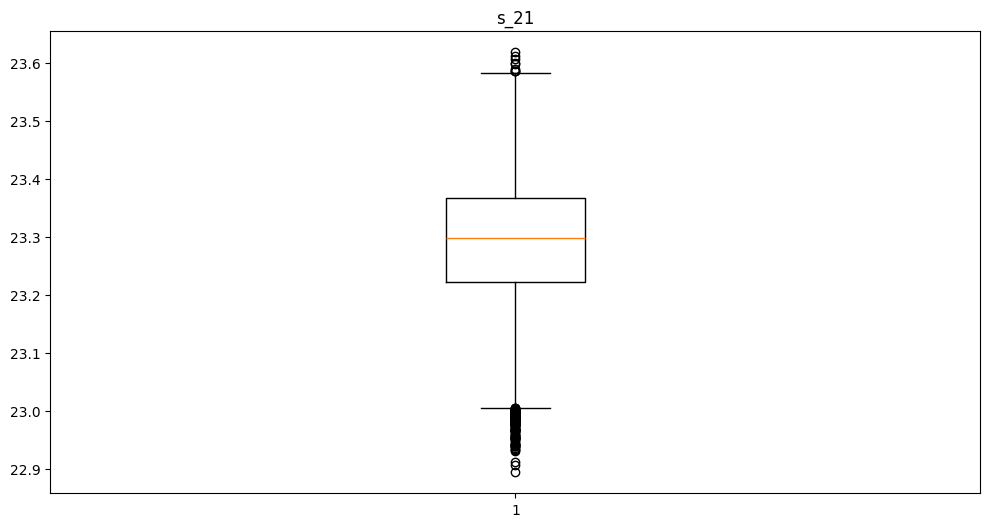

In [ ]:
for x in sensor_names:
    plt.figure(figsize=(12,6))
    plt.boxplot(df_train[x])
    plt.title(x)
    plt.show()

Because there are sensors that are constant (1, 5, 10, 16, 18, 19) and some have outliers, we can scale the data.

In [ ]:
df_train.loc[:, 's_1':].describe().T

count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.556432e-14     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   
RUL   20631.0   107.807862  6.888099e+01     0.0000    51.0000   103.0000   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184  
RUL    155.0000   361.0000

They don't have the same scale and they don't follow a normal distribution $\rightarrow$ this can be solved by a MinMax Scaler

$$x_{scaled}=\frac{x-x_{min}}{x_{max}-x_{min}}$$
_Dropping unnecesary features (labels and settings)_

In [ ]:
# --- Data Preparation ---
# Define non-feature columns
non_features = index_names + setting_names  # ['unit_number', 'time_cycles', 'setting_1', ...]

# Prepare training data
X_train = df_train.drop(columns=non_features)
y_train = X_train.pop('RUL')  # Extract target while removing from features

# Prepare validation data (last record of each test engine)
X_valid = (df_val.groupby('unit_number')
           .last()
           .reset_index()
           .drop(columns=non_features))

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=0.3,
    random_state=17
)d

# --- Preprocessing ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on training data
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

# --- Validation ---
print(f"Validation features shape: {X_valid_scaled.shape}")  # Should be (100, n_features)
print(f"Test targets shape: {y_valid.shape}")  # Should be (n_samples,)

Validation features shape: (100, 21)
Test targets shape: (100, 1)


Plotting features new distribution

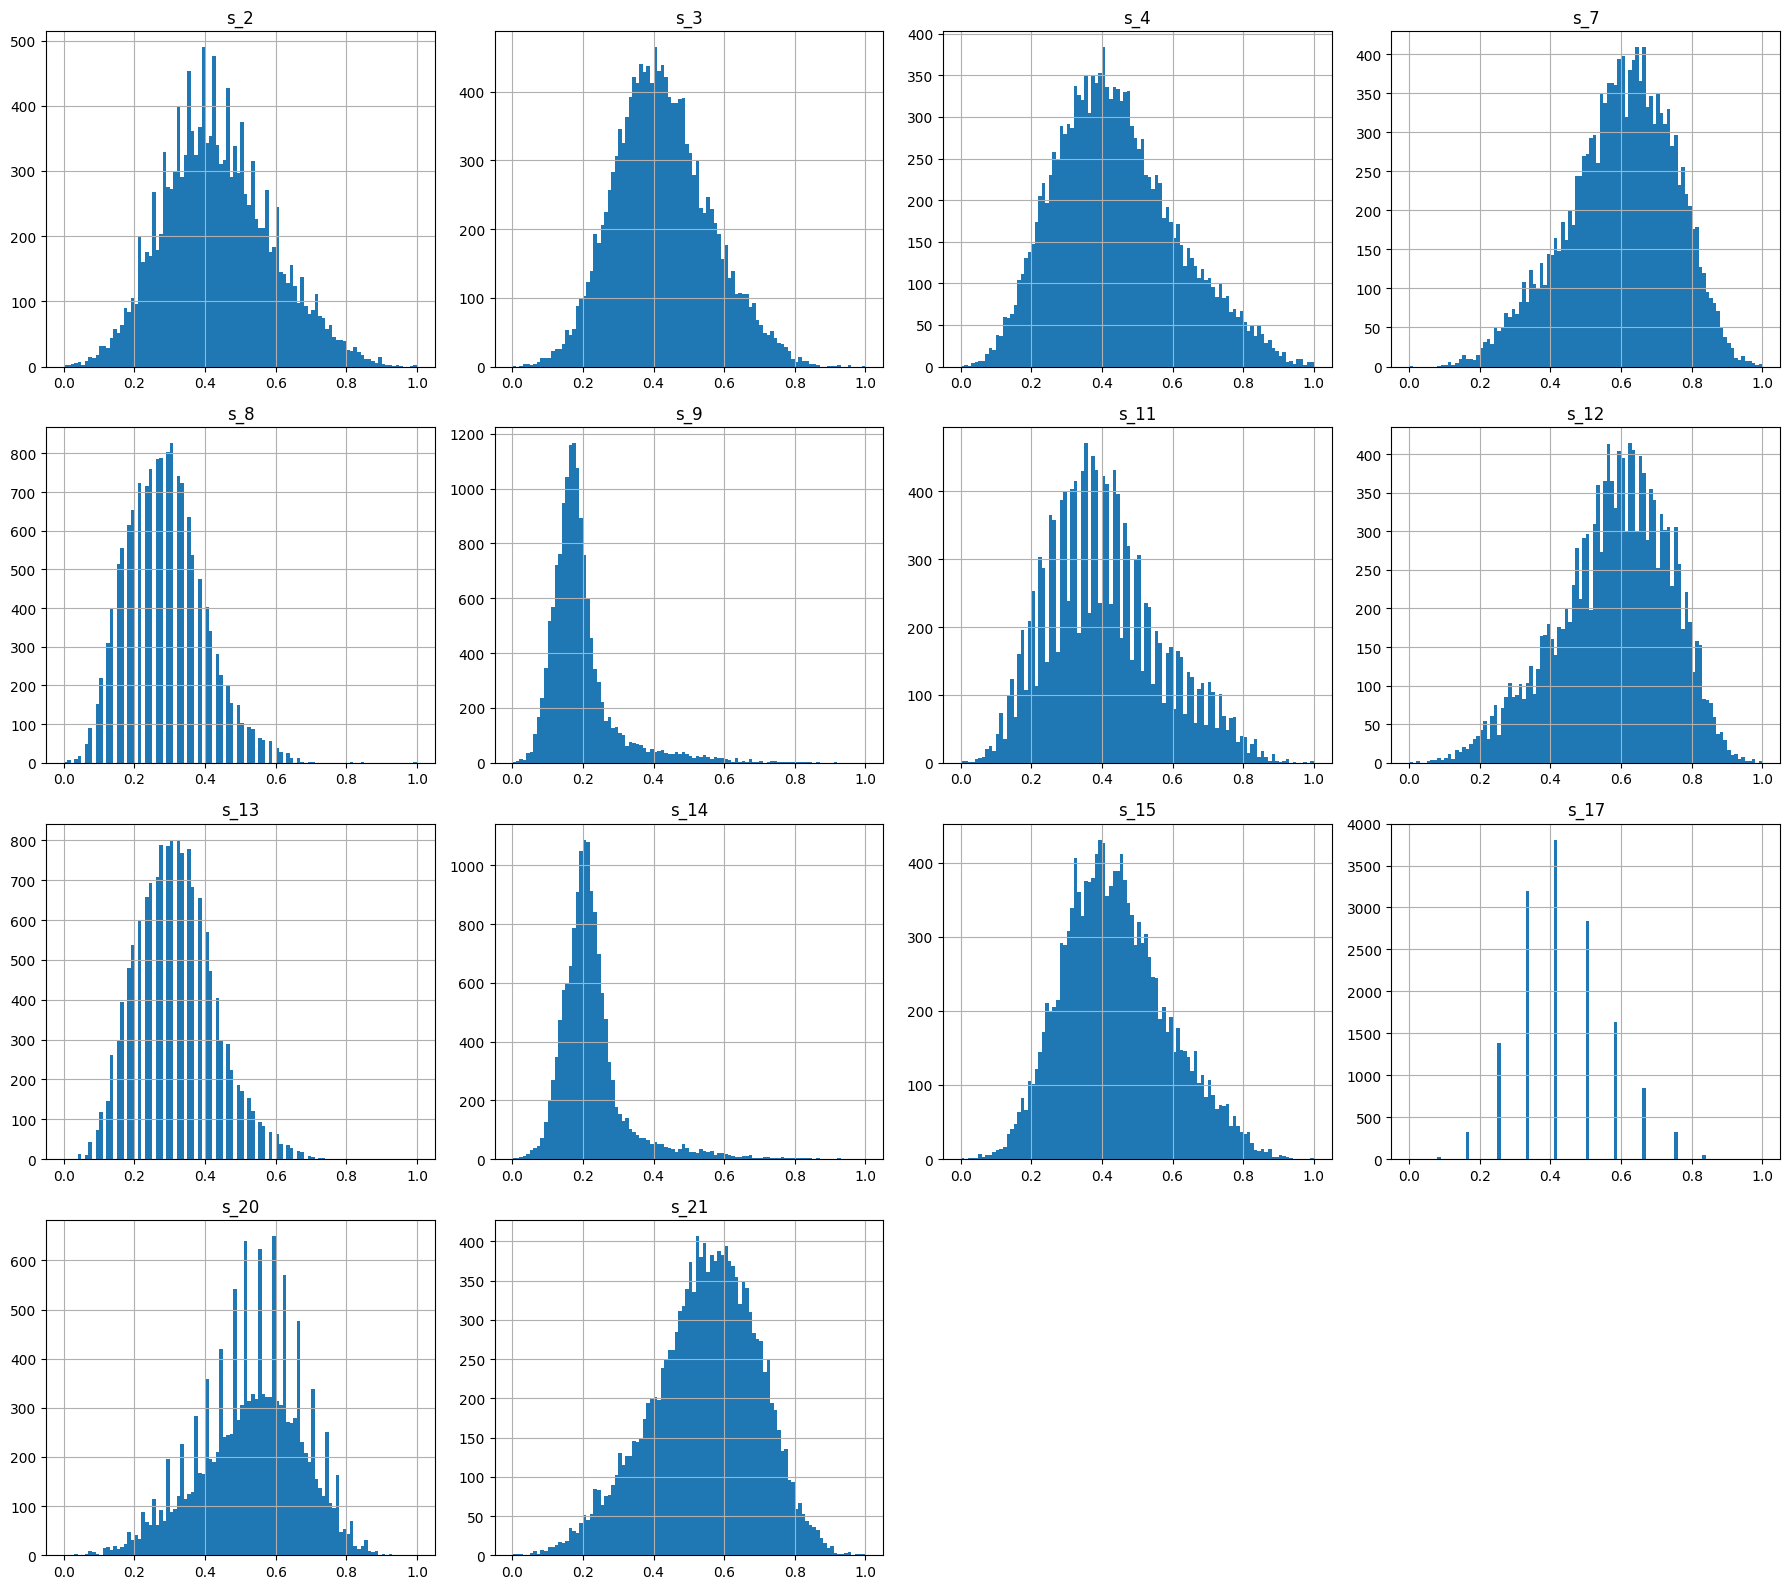

In [ ]:
sensor_names = ['s_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
temp_df = pd.DataFrame(X_train_scaled, columns=['s_{}'.format(i) for i in range(1,22)])
temp_df[sensor_names].hist(bins=100, figsize=(18,16))
plt.tight_layout()  # Prevent label overlapping
plt.show()

In [ ]:
def evaluate(y_true, y_pred, label=''):
    """Enhanced evaluation function"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'        {label} - RMSE: {rmse:.2f}, R2: {r2:.2f}')
    return rmse, r2

def plot_pred_vs_actual(y_true, y_pred, max_engines=50, figsize=(25, 10)):
    """Improved visualization of predicted vs actual RUL"""
    plt.figure(figsize=figsize)
    
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # if len(y_true) > max_engines:
    #     print(f"Displaying first {max_engines} engines for clarity")
    #     y_true = y_true[:max_engines]
    #     y_pred = y_pred[:max_engines]
    
    indices = np.arange(len(y_true))
    bar_width = 0.35

    plt.bar(indices - bar_width/2, y_true, width=bar_width, 
            color='#2ecc71', alpha=0.8, label='True RUL')
    plt.bar(indices + bar_width/2, y_pred, width=bar_width, 
            color='#e74c3c', alpha=0.8, label='Predicted RUL')
    
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        plt.plot([i - bar_width/2, i + bar_width/2], [true, pred], 
                color='#34495e', linestyle=':', alpha=0.5)

    plt.title('RUL Prediction Performance', fontsize=20, pad=20)
    plt.xlabel('Engine Index', fontsize=16)
    plt.ylabel('Remaining Useful Life (cycles)', fontsize=16)
    plt.xticks(indices, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=14, framealpha=1)
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Regression
The first task will be to predict RUL.

## 1st attempt (data with useless sensors, with historical data)

### Linear Models

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
linear_models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results_linear = {}
for name, model in linear_models.items():
    print(f'\nTraining {name} Regression')
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_valid_pred = model.predict(X_valid_scaled)
    y_test_pred = model.predict(X_test_scaled)
    print(' Training Set:')
    train_rmse, train_r2 = evaluate(y_train, y_train_pred, 'Train')
    print(' Test Set:')
    test_rmse, test_r2 = evaluate(y_test, y_test_pred, 'Test')
    print(' Validation Set:')
    valid_rmse, valid_r2 = evaluate(y_valid, y_valid_pred, 'Valid')
    results_linear[name] = {
        'train_rmse': train_rmse,
        'valid_rmse': valid_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'valid_r2': valid_r2,
        'test_r2': test_r2
    }
    
print("\n\n=== Model Comparison ===")
print(f"{'Model':<20} | {'Valid RMSE':>10} | {'Valid R2':>6}")
print("-"*45)
for name, metrics in sorted(results_linear.items(), key=lambda x: x[1]['valid_rmse']):
    print(f"{name:<20} | {metrics['valid_rmse']:10.2f} | {metrics['valid_r2']:6.2f}")


Training Linear Regression
 Training Set:
        Train - RMSE: 44.44, R2: 0.58
 Test Set:
        Test - RMSE: 45.20, R2: 0.57
 Validation Set:
        Valid - RMSE: 32.13, R2: 0.40

Training Ridge Regression
 Training Set:
        Train - RMSE: 44.44, R2: 0.58
 Test Set:
        Test - RMSE: 45.20, R2: 0.57
 Validation Set:
        Valid - RMSE: 32.11, R2: 0.40

Training Lasso Regression
 Training Set:
        Train - RMSE: 44.47, R2: 0.58
 Test Set:
        Test - RMSE: 45.23, R2: 0.57
 Validation Set:
        Valid - RMSE: 32.23, R2: 0.40

Training Elastic Net Regression
 Training Set:
        Train - RMSE: 46.65, R2: 0.54
 Test Set:
        Test - RMSE: 47.14, R2: 0.53
 Validation Set:
        Valid - RMSE: 31.35, R2: 0.43


=== Model Comparison ===
Model                | Valid RMSE | Valid R2
---------------------------------------------
Elastic Net          |      31.35 |   0.43
Ridge                |      32.11 |   0.40
Linear               |      32.13 |   0.40
Lasso         

### Suport Vector Regression

In [ ]:
from sklearn.svm import SVR
svm_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in svm_kernels:
    print(f'\nTraining SVM: {str(kernel).capitalize()} Regression')
    model = SVR(kernel=kernel)
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_valid_pred = model.predict(X_valid_scaled)
    y_test_pred = model.predict(X_test_scaled)
    print(' Training Set:')
    train_rmse, train_r2 = evaluate(y_train, y_train_pred, 'Train')
    print(' Test Set:')
    test_rmse, test_r2 = evaluate(y_test, y_test_pred, 'Test')
    print(' Validation Set:')
    valid_rmse, valid_r2 = evaluate(y_valid, y_valid_pred, 'Valid')


Training SVM: Linear Regression
 Training Set:
        Train - RMSE: 45.47, R2: 0.57
 Test Set:
        Test - RMSE: 46.05, R2: 0.55
 Validation Set:
        Valid - RMSE: 26.47, R2: 0.59

Training SVM: Poly Regression
 Training Set:
        Train - RMSE: 43.06, R2: 0.61
 Test Set:
        Test - RMSE: 43.76, R2: 0.59
 Validation Set:
        Valid - RMSE: 26.87, R2: 0.58

Training SVM: Rbf Regression
 Training Set:
        Train - RMSE: 43.29, R2: 0.61
 Test Set:
        Test - RMSE: 43.96, R2: 0.59
 Validation Set:
        Valid - RMSE: 26.14, R2: 0.60

Training SVM: Sigmoid Regression
 Training Set:
        Train - RMSE: 53.38, R2: 0.40
 Test Set:
        Test - RMSE: 53.60, R2: 0.39
 Validation Set:
        Valid - RMSE: 29.65, R2: 0.49


__Note:__ Keep an eye on RBF and Linear SVM

### Ensemble Methods


Training RandomForest Regression
 Training Set:
        Train - RMSE: 15.42, R2: 0.95
 Test Set:
        Test - RMSE: 42.33, R2: 0.62
 Validation Set:
        Valid - RMSE: 34.73, R2: 0.30

Most Important Feature: s_11 (43.89%)

Training GradientBoosting Regression
 Training Set:
        Train - RMSE: 39.73, R2: 0.67
 Test Set:
        Test - RMSE: 42.10, R2: 0.62
 Validation Set:
        Valid - RMSE: 31.96, R2: 0.41

Most Important Feature: s_11 (32.22%)

Training XGBoost Regression
 Training Set:
        Train - RMSE: 25.62, R2: 0.86
 Test Set:
        Test - RMSE: 43.83, R2: 0.59
 Validation Set:
        Valid - RMSE: 39.42, R2: 0.10

Most Important Feature: s_11 (46.20%)

Training ExtraTreesRegressor Regression
 Training Set:
        Train - RMSE: 0.00, R2: 1.00
 Test Set:
        Test - RMSE: 42.16, R2: 0.62
 Validation Set:
        Valid - RMSE: 33.27, R2: 0.36

Most Important Feature: s_11 (14.93%)

Training AdaBoost Regression
 Training Set:
        Train - RMSE: 46.84, R2: 0

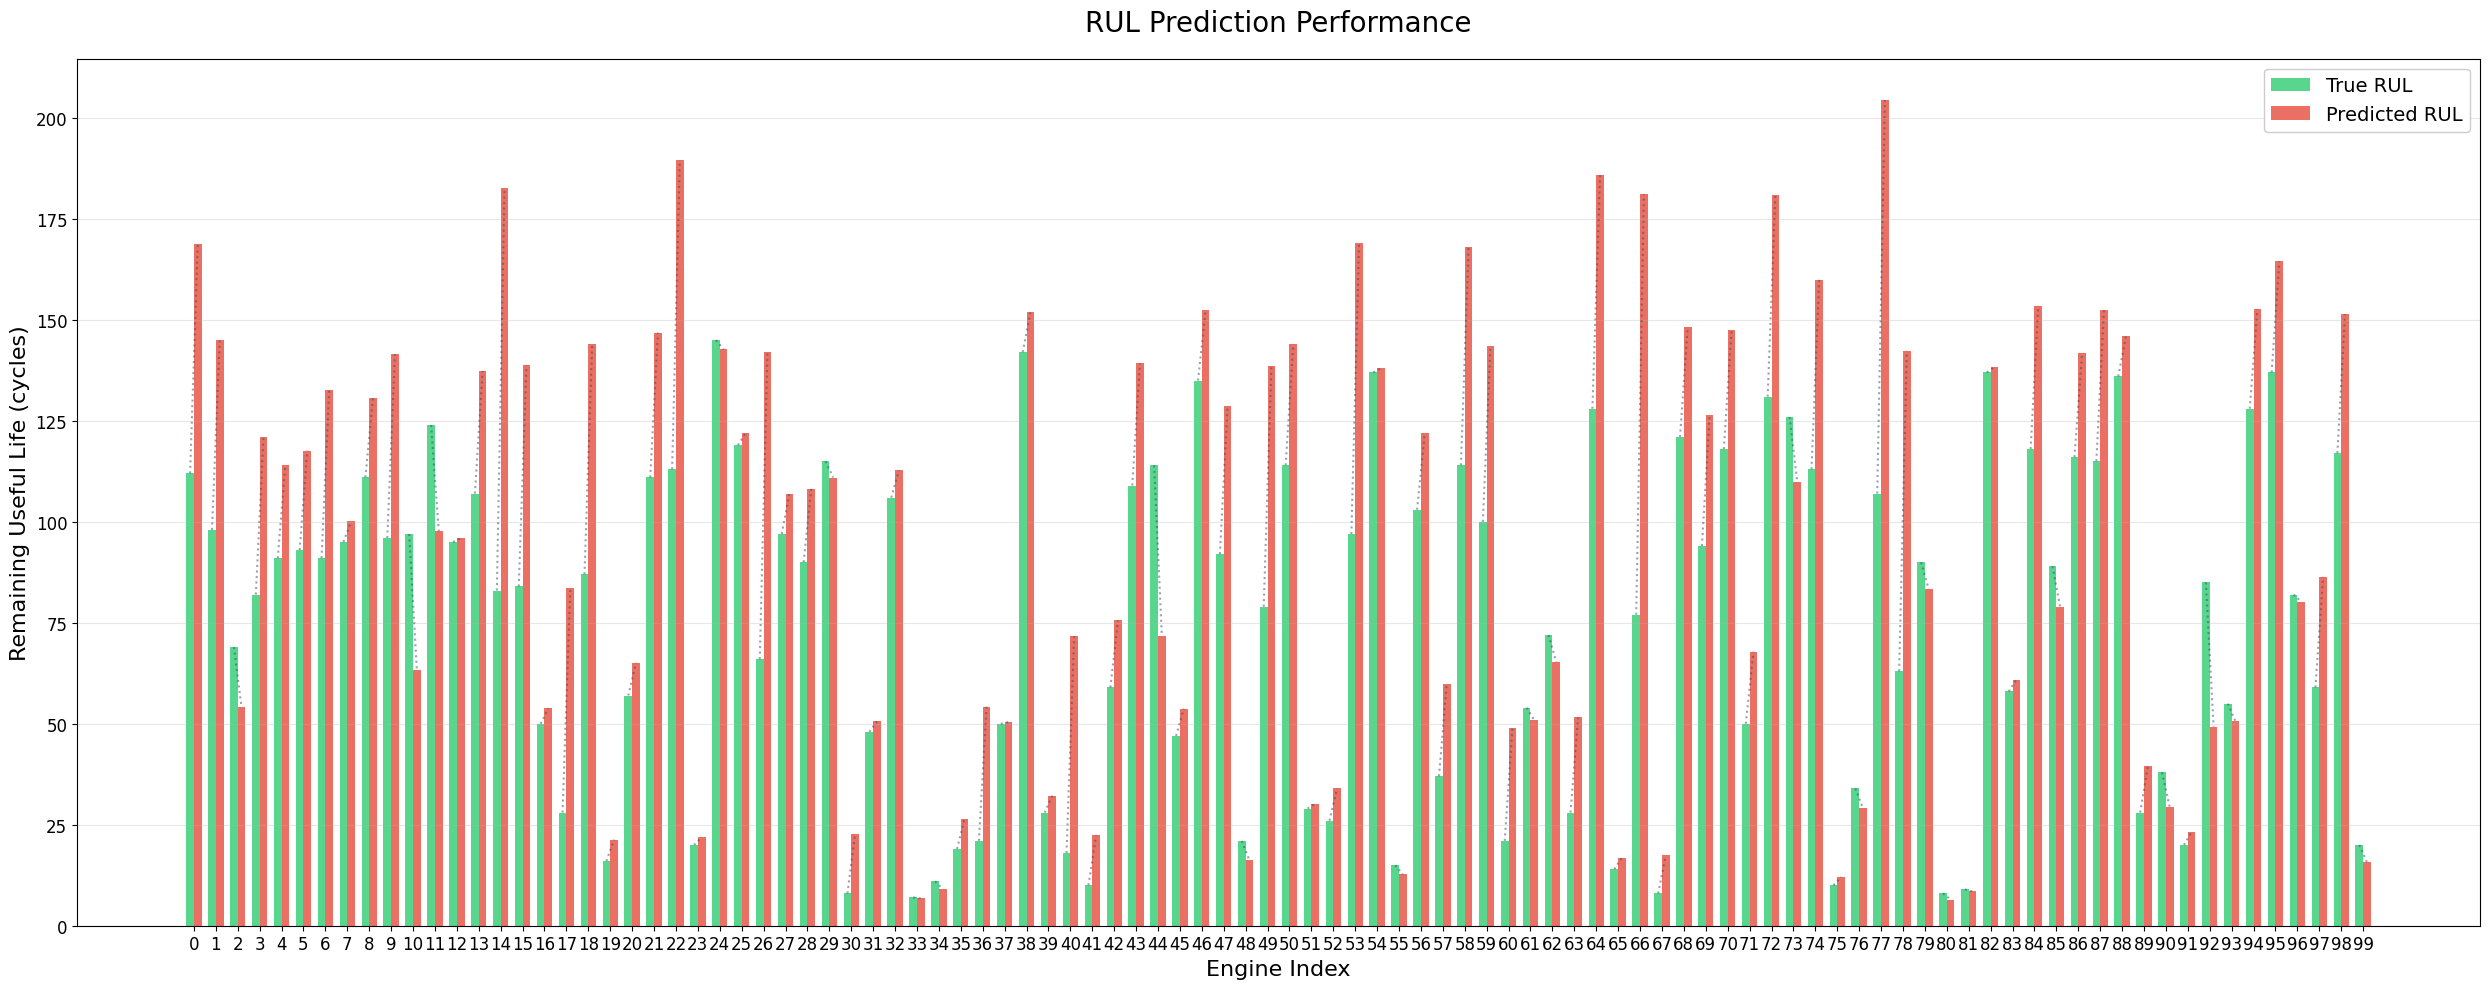

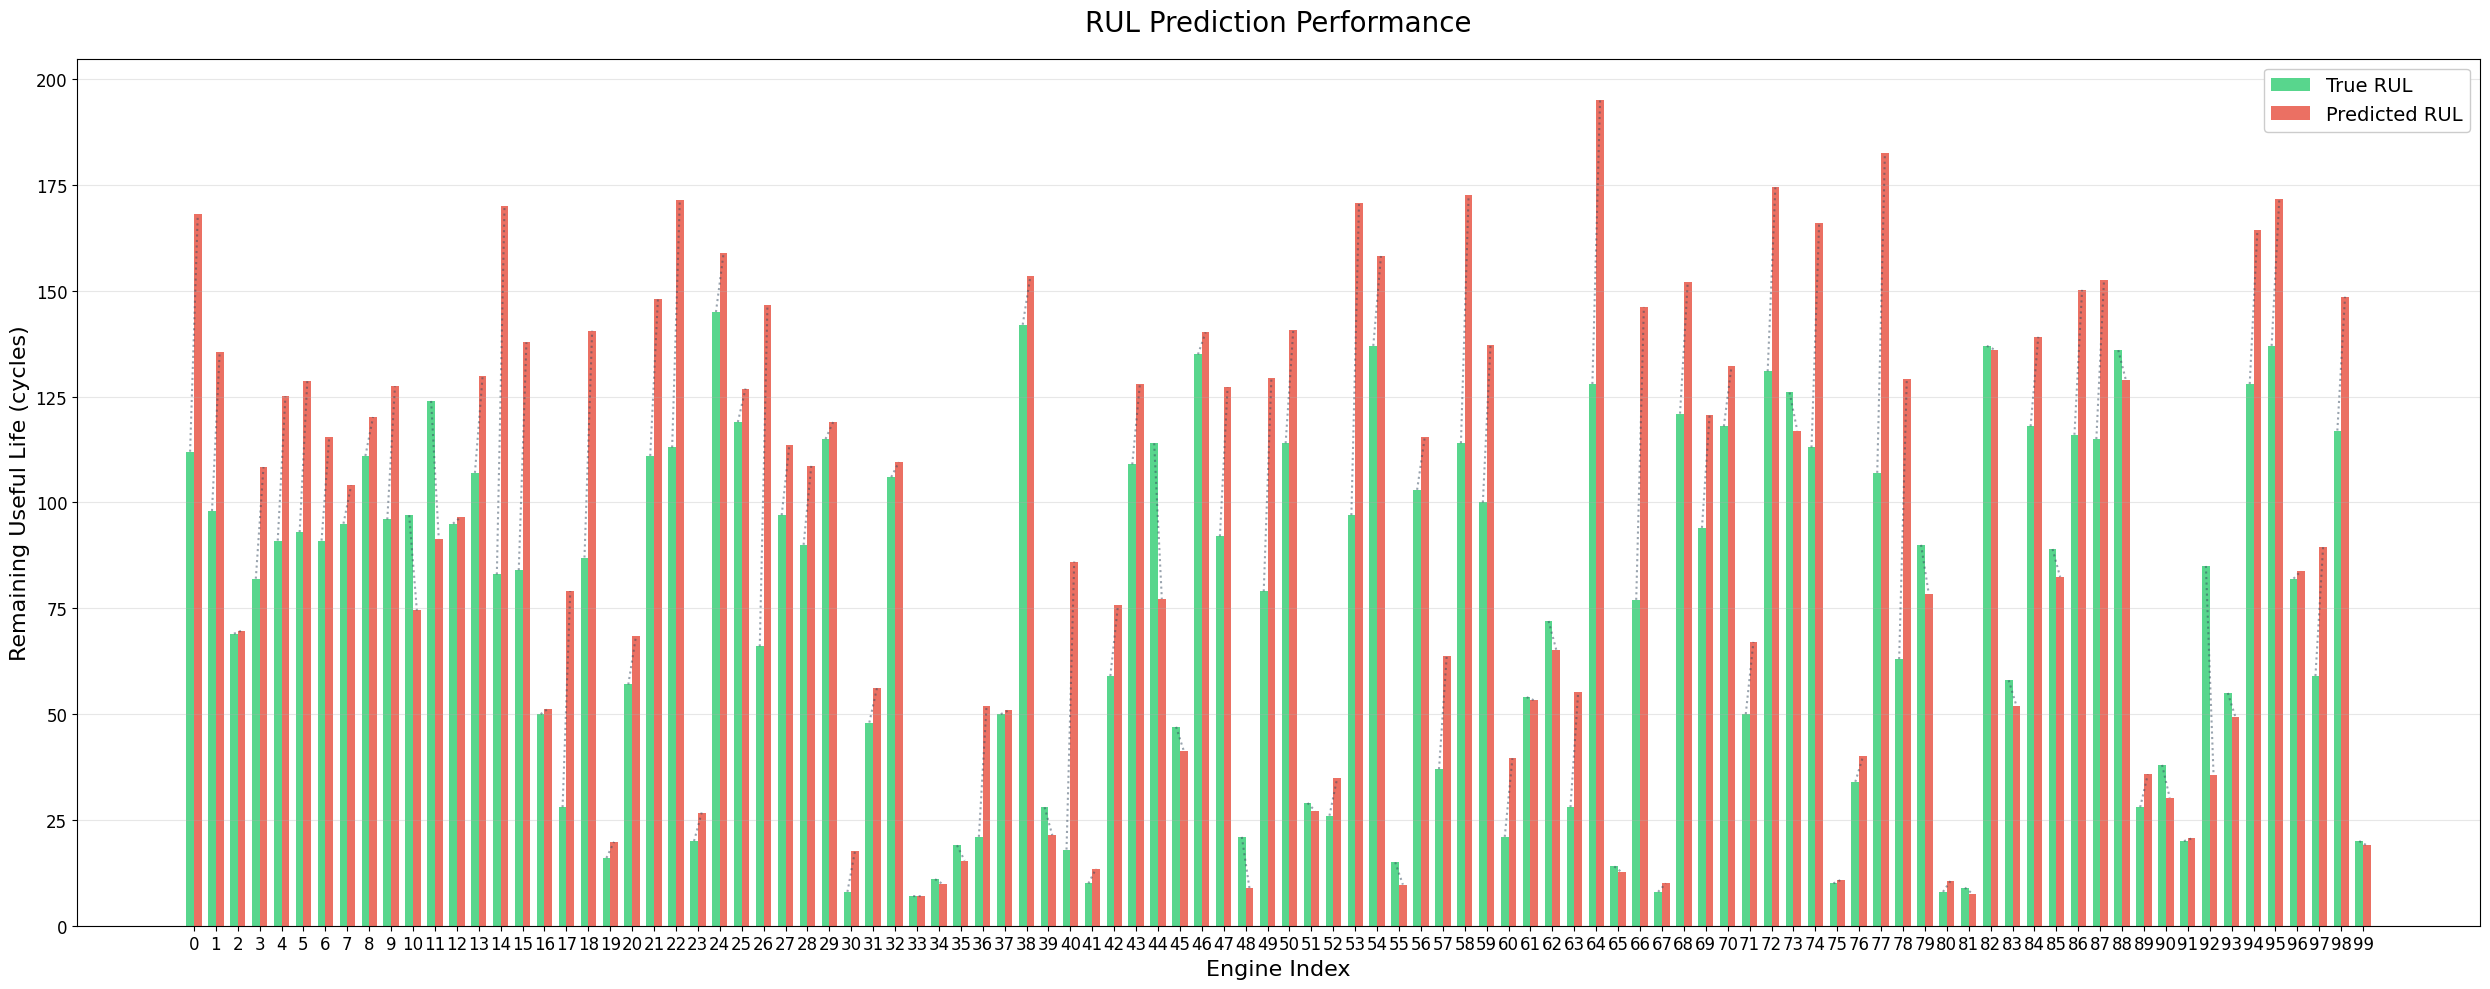

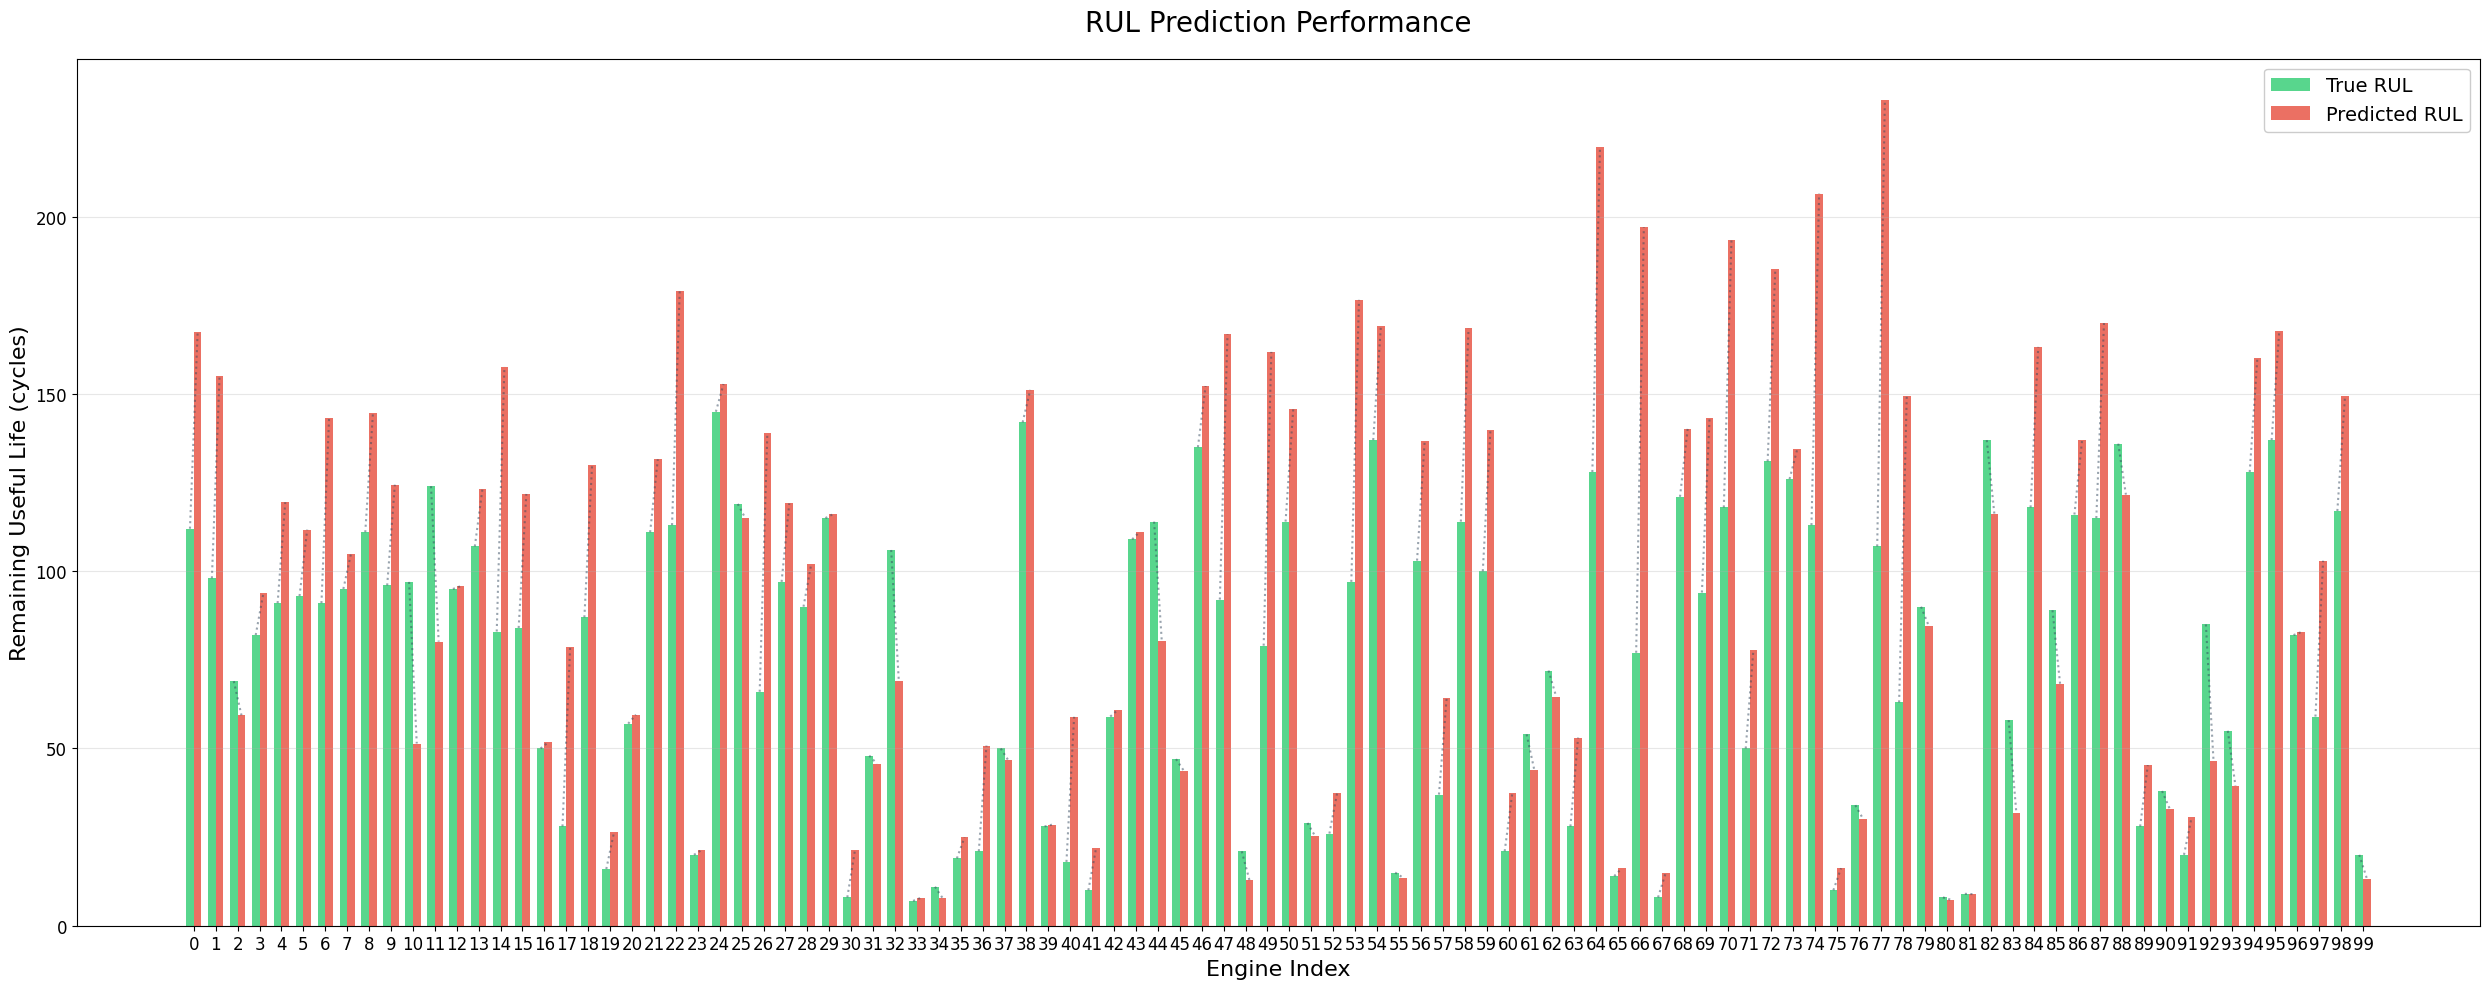

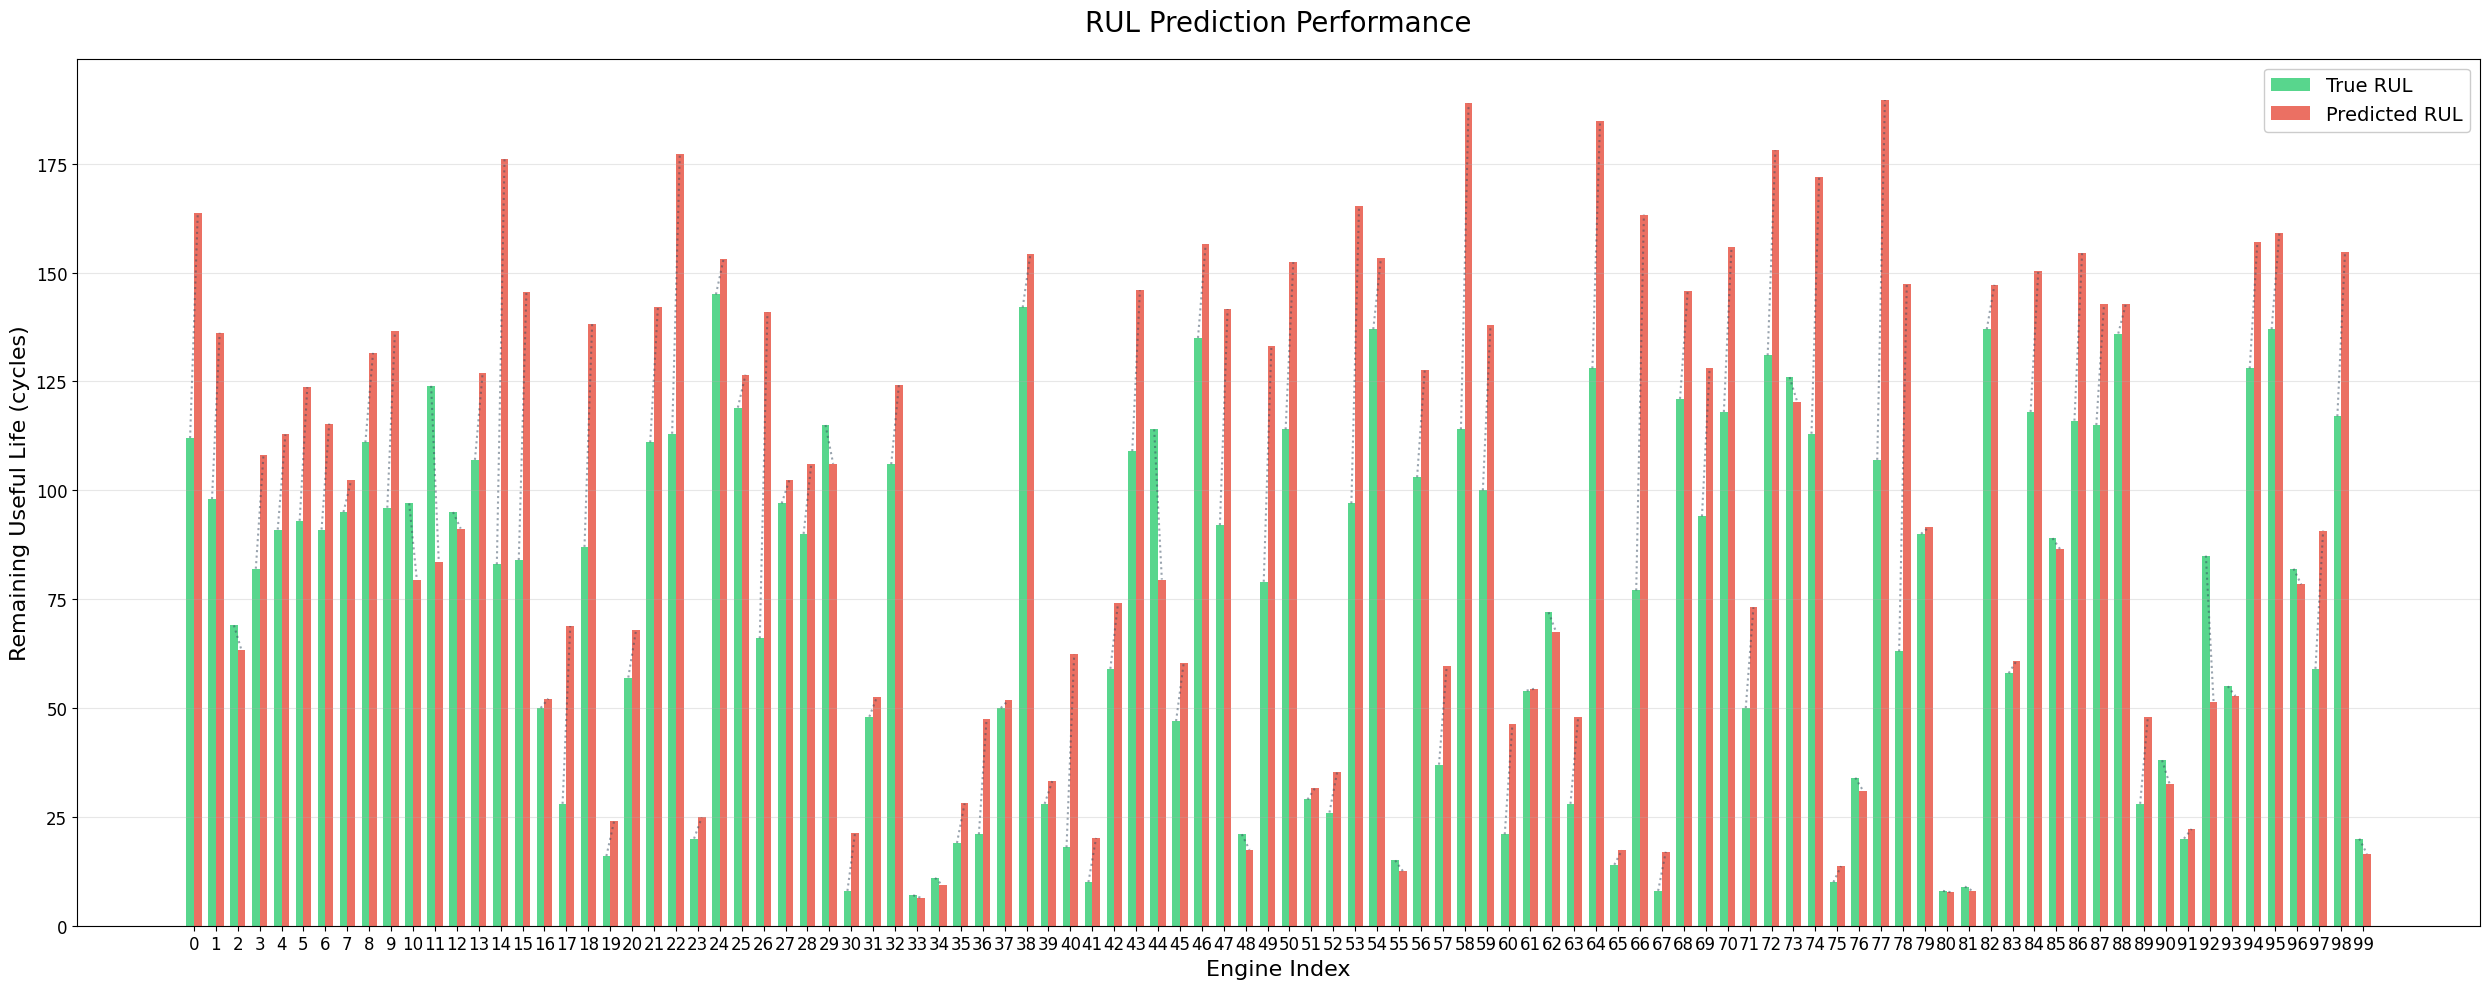

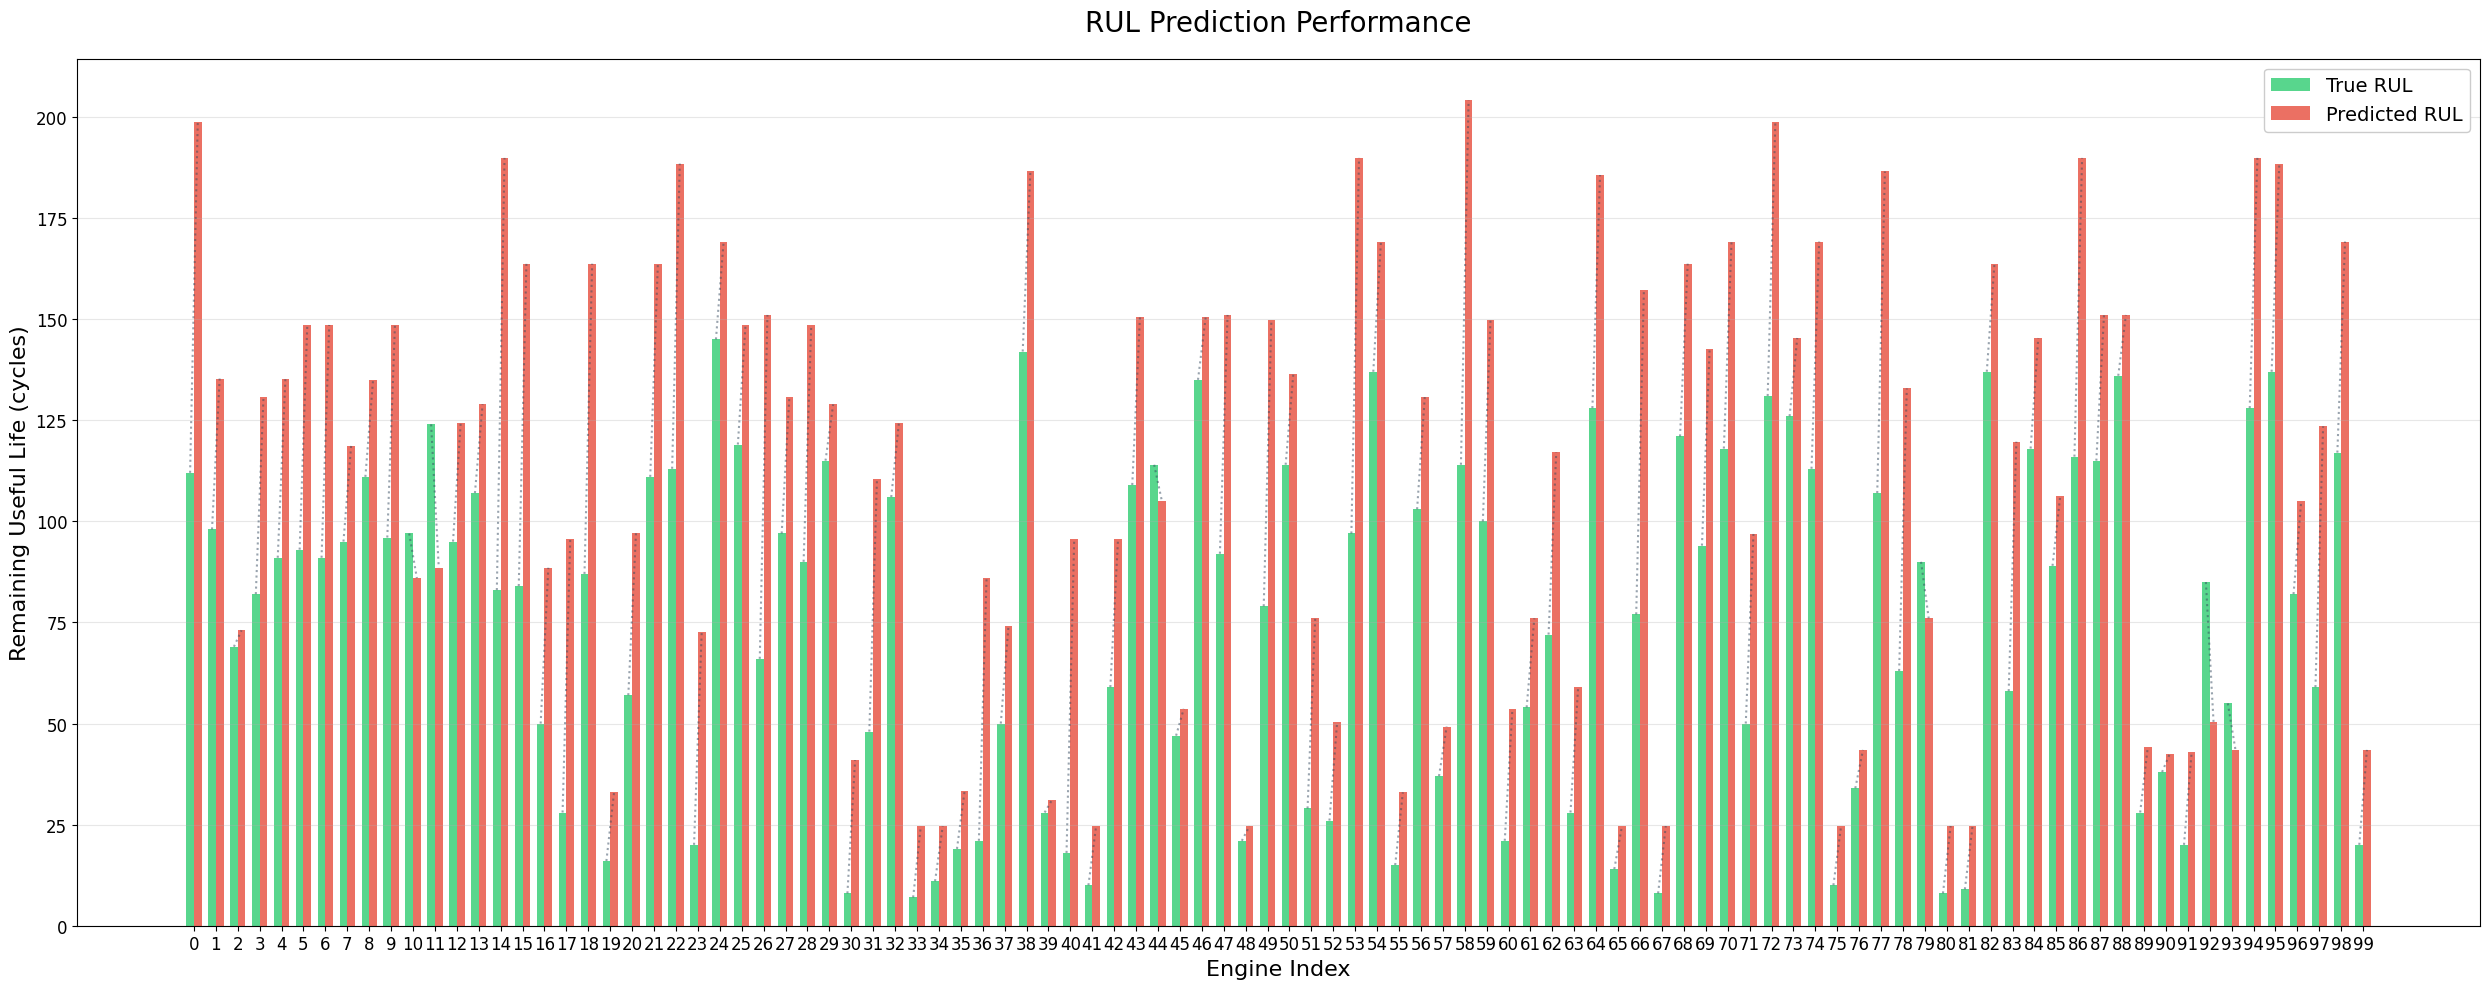

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
rs = 17
ensemble_models = {
    'RandomForest': RandomForestRegressor(random_state=rs),
    'GradientBoosting': GradientBoostingRegressor(random_state=rs),
    'XGBoost': XGBRegressor(random_state=rs, eval_metric='rmse'),
    'ExtraTreesRegressor': ExtraTreesRegressor(random_state=rs),
    'AdaBoost': AdaBoostRegressor(random_state=rs)
}
results_ensemble = {}
for name, model in ensemble_models.items():
    print(f'\nTraining {name} Regression')
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_valid_pred = model.predict(X_valid_scaled)
    y_test_pred = model.predict(X_test_scaled)
    print(' Training Set:')
    train_rmse, train_r2 = evaluate(y_train, y_train_pred, 'Train')
    print(' Test Set:')
    test_rmse, test_r2 = evaluate(y_test, y_test_pred, 'Test')
    print(' Validation Set:')
    valid_rmse, valid_r2 = evaluate(y_valid, y_valid_pred, 'Valid')
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        top_feature = X_train.columns[np.argmax(importance)]
        print(f"\nMost Important Feature: {top_feature} ({importance.max():.2%})")
    
    results_ensemble[name] = {
        'y_pred_valid': y_valid_pred,
        'train_rmse': train_rmse,
        'valid_rmse': valid_rmse,
        'train_r2': train_r2,
        'valid_r2': valid_r2
    }
    
print("\n\n=== Model Comparison ===")
print(f"{'Model':<20} | {'Train RMSE':>10} | {'Valid RMSE':>10} | {'Valid R2':>6}")
print("-"*60)
for name, metrics in sorted(results_ensemble.items(), key=lambda x: x[1]['valid_rmse']):
    print(f"{name:<20} | {metrics['train_rmse']:10.2f} | {metrics['valid_rmse']:10.2f} | {metrics['valid_r2']:6.2f}")

for model_name, results in results_ensemble.items():
    plot_pred_vs_actual(
        y_valid, 
        results['y_pred_valid'], 
        f"{model_name} (Valid RMSE: {results['valid_rmse']:.1f})"
    )

## 2nd attempt (Data without useless sensors, without historical data)
Now, let's drop constant signals, and we notices in the `max_time_cycles` plot that in most of the time the maximum value is in the interval [191, 210], hence we will set maximum RUL to 195 through RUL clipping.

Considering that every RUL higher than 195 is equivalent to 195 will help in the prediction process as it reduces some overhead without affecting the main objective as 195 is already a high RUL.

In [ ]:
print(f"Maximum of y_train: {y_train.max()}")
print(f"Maximum of y_test: {y_test.max()}")
print(f"Maximum of y_valid: {y_valid.max()}")

Maximum of y_train: 361
Maximum of y_test: 360
Maximum of y_valid: RUL    145
dtype: int64


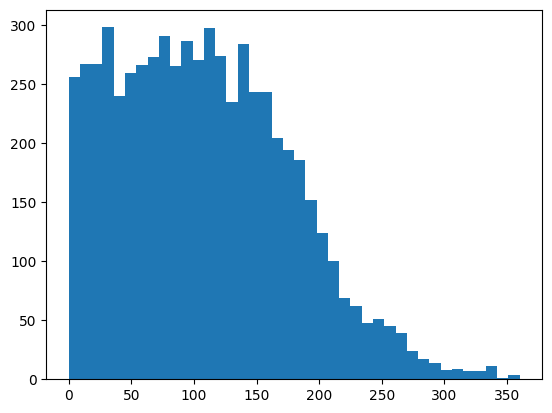

In [ ]:
plt.hist(y_test, bins=40);

In [ ]:
# --- Data Preparation ---
# Define columns to drop (non-features + constant sensors)
non_features = index_names + setting_names  # ['unit_number', 'time_cycles', 'setting_1', ...]
constant_sensors = ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
drop_labels2 = non_features + constant_sensors

# Prepare training data
X_train_2 = df_train.drop(columns=drop_labels2)
y_train = X_train_2.pop('RUL').clip(upper=195)  # Clip RUL at 195 cycles

# Prepare validation data (last record of each test engine)
X_valid_2 = (df_val.groupby('unit_number')
            .last()
            .reset_index()
            .drop(columns=drop_labels2))

# --- Train-Test Split ---
X_train_2, X_test_2, y_train, y_test = train_test_split(
    X_train_2, y_train,
    test_size=0.3,
    random_state=17
)

# --- Preprocessing ---
scaler = MinMaxScaler()
X_train_2_s = scaler.fit_transform(X_train_2)  # Fit only on training data
X_test_2_s = scaler.transform(X_test_2)
X_valid_2_s = scaler.transform(X_valid_2)

# --- Validation ---
print(f"Training shapes: {X_train_2.shape} (features), {y_train.shape} (target)")
print(f"Validation shapes: {X_valid_2_s.shape} (features), {y_valid.shape} (target)")  # Should be (100, n_features)
print(f"Test shapes: {X_test_2_s.shape} (features)")

# Verify no constant columns remain
print("\nRemaining sensors:", X_train_2.columns.tolist())

Training shapes: (14441, 14) (features), (14441,) (target)
Validation shapes: (100, 14) (features), (100, 1) (target)
Test shapes: (6190, 14) (features)

Remaining sensors: ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']


### Linear Models #2

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

linear_models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results_linear = {}
for name, model in linear_models.items():
    print(f'\nTraining {name} Regression')
    model.fit(X_train_2_s, y_train)
    y_train_pred = model.predict(X_train_2_s)
    y_valid_pred = model.predict(X_valid_2_s)
    y_test_pred = model.predict(X_test_2_s)
    print(' Training Set:')
    train_rmse, train_r2 = evaluate(y_train, y_train_pred, 'Train')
    print(' Test Set:')
    test_rmse, test_r2 = evaluate(y_test, y_test_pred, 'Test')
    print(' Validation Set:')
    valid_rmse, valid_r2 = evaluate(y_valid, y_valid_pred, 'Valid')
    results_linear[name] = {
        'y_pred_valid': y_valid_pred,
        'train_rmse': train_rmse,
        'valid_rmse': valid_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'valid_r2': valid_r2,
        'test_r2': test_r2
    }
    
print("\n\n=== Model Comparison ===")
print(f"{'Model':<20} | {'Train RMSE':>10} | {'Valid RMSE':>10} | {'Valid R2':>6}")
print("-"*60)
for name, metrics in sorted(results_linear.items(), key=lambda x: x[1]['valid_rmse']):
    print(f"{name:<20} | {metrics['train_rmse']:10.2f} | {metrics['valid_rmse']:10.2f} | {metrics['valid_r2']:6.2f}")


Training Linear Regression
 Training Set:
        Train - RMSE: 35.85, R2: 0.65
 Test Set:
        Test - RMSE: 36.47, R2: 0.63
 Validation Set:
        Valid - RMSE: 28.79, R2: 0.52

Training Ridge Regression
 Training Set:
        Train - RMSE: 35.85, R2: 0.65
 Test Set:
        Test - RMSE: 36.47, R2: 0.63
 Validation Set:
        Valid - RMSE: 28.77, R2: 0.52

Training Lasso Regression
 Training Set:
        Train - RMSE: 35.88, R2: 0.65
 Test Set:
        Test - RMSE: 36.49, R2: 0.63
 Validation Set:
        Valid - RMSE: 28.95, R2: 0.51

Training Elastic Net Regression
 Training Set:
        Train - RMSE: 38.26, R2: 0.60
 Test Set:
        Test - RMSE: 38.61, R2: 0.59
 Validation Set:
        Valid - RMSE: 28.90, R2: 0.52


=== Model Comparison ===
Model                | Train RMSE | Valid RMSE | Valid R2
------------------------------------------------------------
Ridge                |      35.85 |      28.77 |   0.52
Linear               |      35.85 |      28.79 |   0.52
Ela

### Support Vector Machines #2

In [ ]:
from sklearn.svm import SVR

svm_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results_svm = {}

for kernel in svm_kernels:
    model_name = f"SVM-{kernel.capitalize()}"
    print(f'\nTraining {model_name} Regression')
    
    model = SVR(kernel=kernel)
    model.fit(X_train_scaled, y_train)
    
    y_train_pred = model.predict(X_train_scaled)
    y_valid_pred = model.predict(X_valid_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    print(' Training Set:')
    train_rmse, train_r2 = evaluate(y_train, y_train_pred, 'Train')
    print(' Test Set:')
    test_rmse, test_r2 = evaluate(y_test, y_test_pred, 'Test')
    print(' Validation Set:')
    valid_rmse, valid_r2 = evaluate(y_valid, y_valid_pred, 'Valid')
    
    results_svm[model_name] = {
        'y_pred_valid': y_valid_pred,
        'train_rmse': train_rmse,
        'valid_rmse': valid_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'valid_r2': valid_r2,
        'test_r2': test_r2
    }

# SVM Model Comparison Table
print("\n\n=== SVM Model Comparison ===")
print(f"{'Model':<20} | {'Train RMSE':>10} | {'Valid RMSE':>10} | {'Valid R2':>6}")
print("-"*60)
for name, metrics in sorted(results_svm.items(), key=lambda x: x[1]['valid_rmse']):
    print(f"{name:<20} | {metrics['train_rmse']:10.2f} | {metrics['valid_rmse']:10.2f} | {metrics['valid_r2']:6.2f}")

# Final Summary Table
print("\n=== SVM Final Summary ===")
print(f"{'Model':<20} | {'Valid RMSE':>10}")
print("-"*35)
for name, metrics in sorted(results_svm.items(), key=lambda x: x[1]['valid_rmse']):
    print(f"{name:<20} | {metrics['valid_rmse']:10.2f}")


Training SVM-Linear Regression
 Training Set:
        Train - RMSE: 36.23, R2: 0.64
 Test Set:
        Test - RMSE: 36.73, R2: 0.63
 Validation Set:
        Valid - RMSE: 26.42, R2: 0.60

Training SVM-Poly Regression
 Training Set:
        Train - RMSE: 34.00, R2: 0.69
 Test Set:
        Test - RMSE: 34.64, R2: 0.67
 Validation Set:
        Valid - RMSE: 26.57, R2: 0.59

Training SVM-Rbf Regression
 Training Set:
        Train - RMSE: 33.98, R2: 0.69
 Test Set:
        Test - RMSE: 34.60, R2: 0.67
 Validation Set:
        Valid - RMSE: 26.14, R2: 0.60

Training SVM-Sigmoid Regression
 Training Set:
        Train - RMSE: 44.45, R2: 0.46
 Test Set:
        Test - RMSE: 44.43, R2: 0.46
 Validation Set:
        Valid - RMSE: 29.74, R2: 0.49


=== SVM Model Comparison ===
Model                | Train RMSE | Valid RMSE | Valid R2
------------------------------------------------------------
SVM-Rbf              |      33.98 |      26.14 |   0.60
SVM-Linear           |      36.23 |      26.42

### Ensemble Methods #2


Training RandomForest Regression
 Training Set:
        Train - RMSE: 12.17, R2: 0.96
 Test Set:
        Test - RMSE: 33.36, R2: 0.69
 Validation Set:
        Valid - RMSE: 29.50, R2: 0.50

Most Important Feature: s_11 (49.02%)

Training GradientBoosting Regression
 Training Set:
        Train - RMSE: 31.32, R2: 0.73
 Test Set:
        Test - RMSE: 33.12, R2: 0.70
 Validation Set:
        Valid - RMSE: 27.93, R2: 0.55

Most Important Feature: s_11 (33.56%)

Training XGBoost Regression
 Training Set:
        Train - RMSE: 20.23, R2: 0.89
 Test Set:
        Test - RMSE: 34.56, R2: 0.67
 Validation Set:
        Valid - RMSE: 30.79, R2: 0.45

Most Important Feature: s_11 (50.41%)

Training ExtraTrees Regression
 Training Set:
        Train - RMSE: 0.00, R2: 1.00
 Test Set:
        Test - RMSE: 33.10, R2: 0.70
 Validation Set:
        Valid - RMSE: 28.07, R2: 0.54

Most Important Feature: s_11 (18.36%)

Training AdaBoost Regression
 Training Set:
        Train - RMSE: 36.91, R2: 0.63
 Test

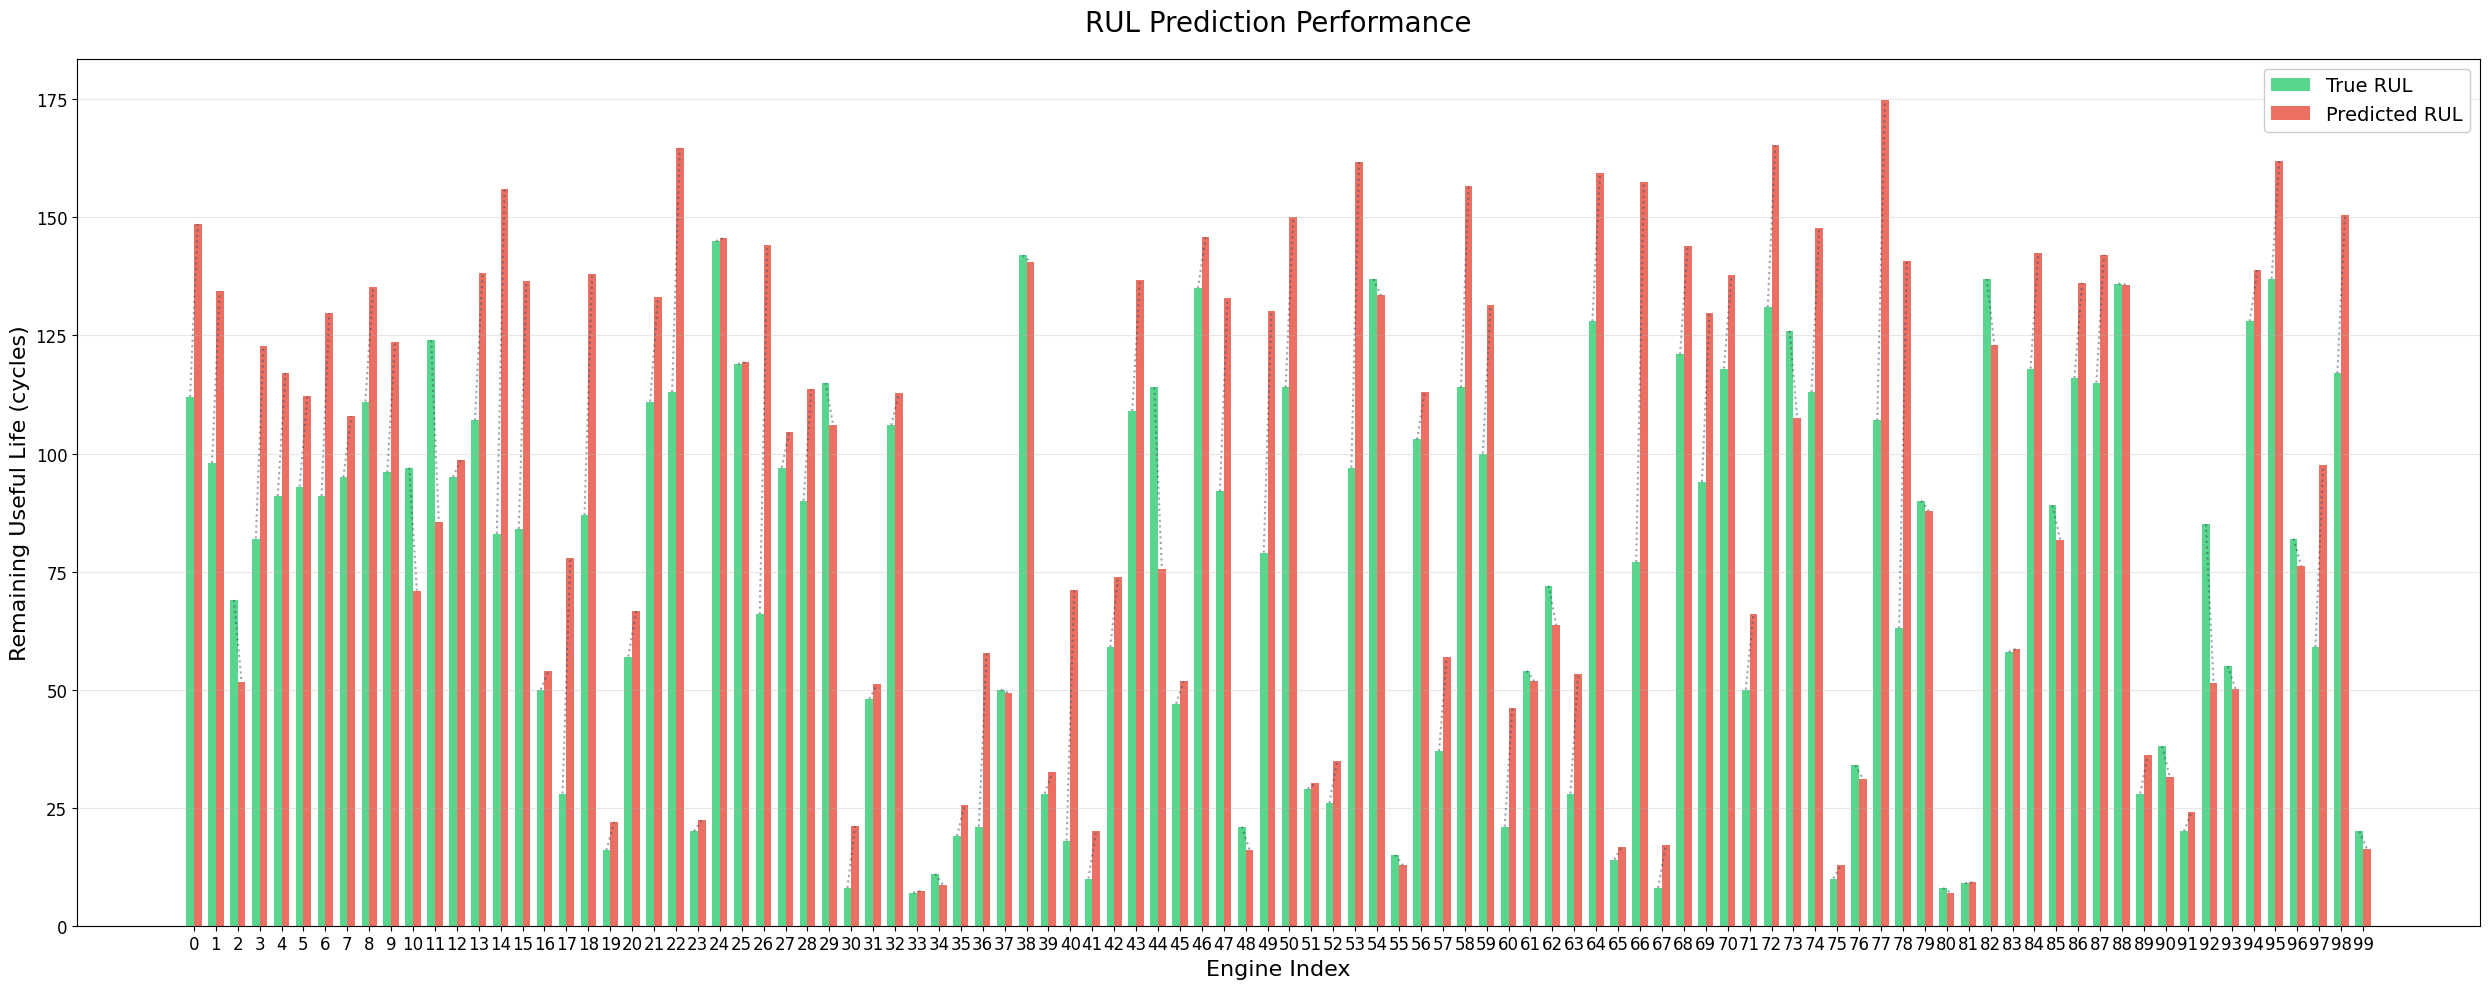

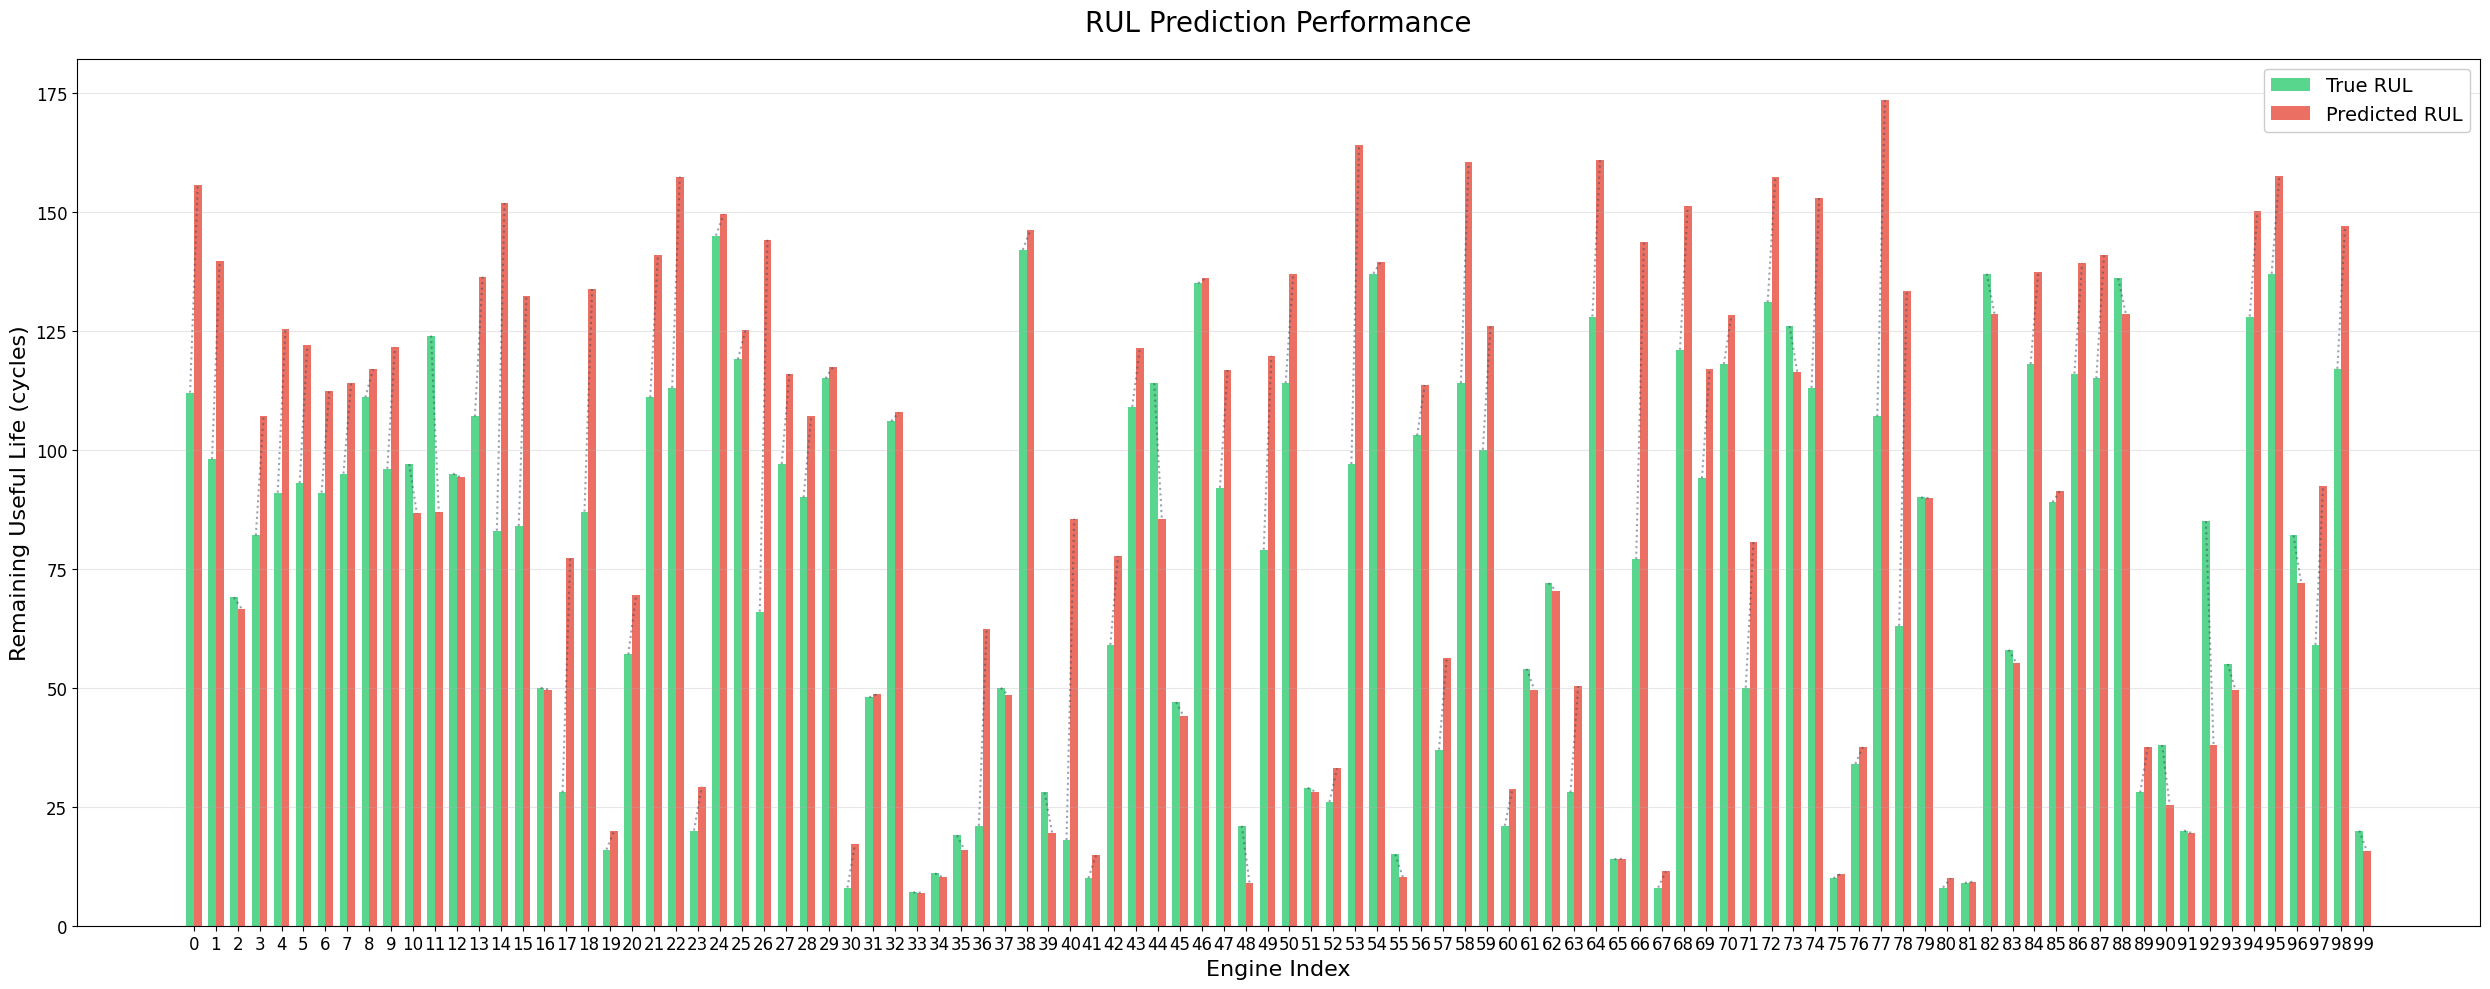

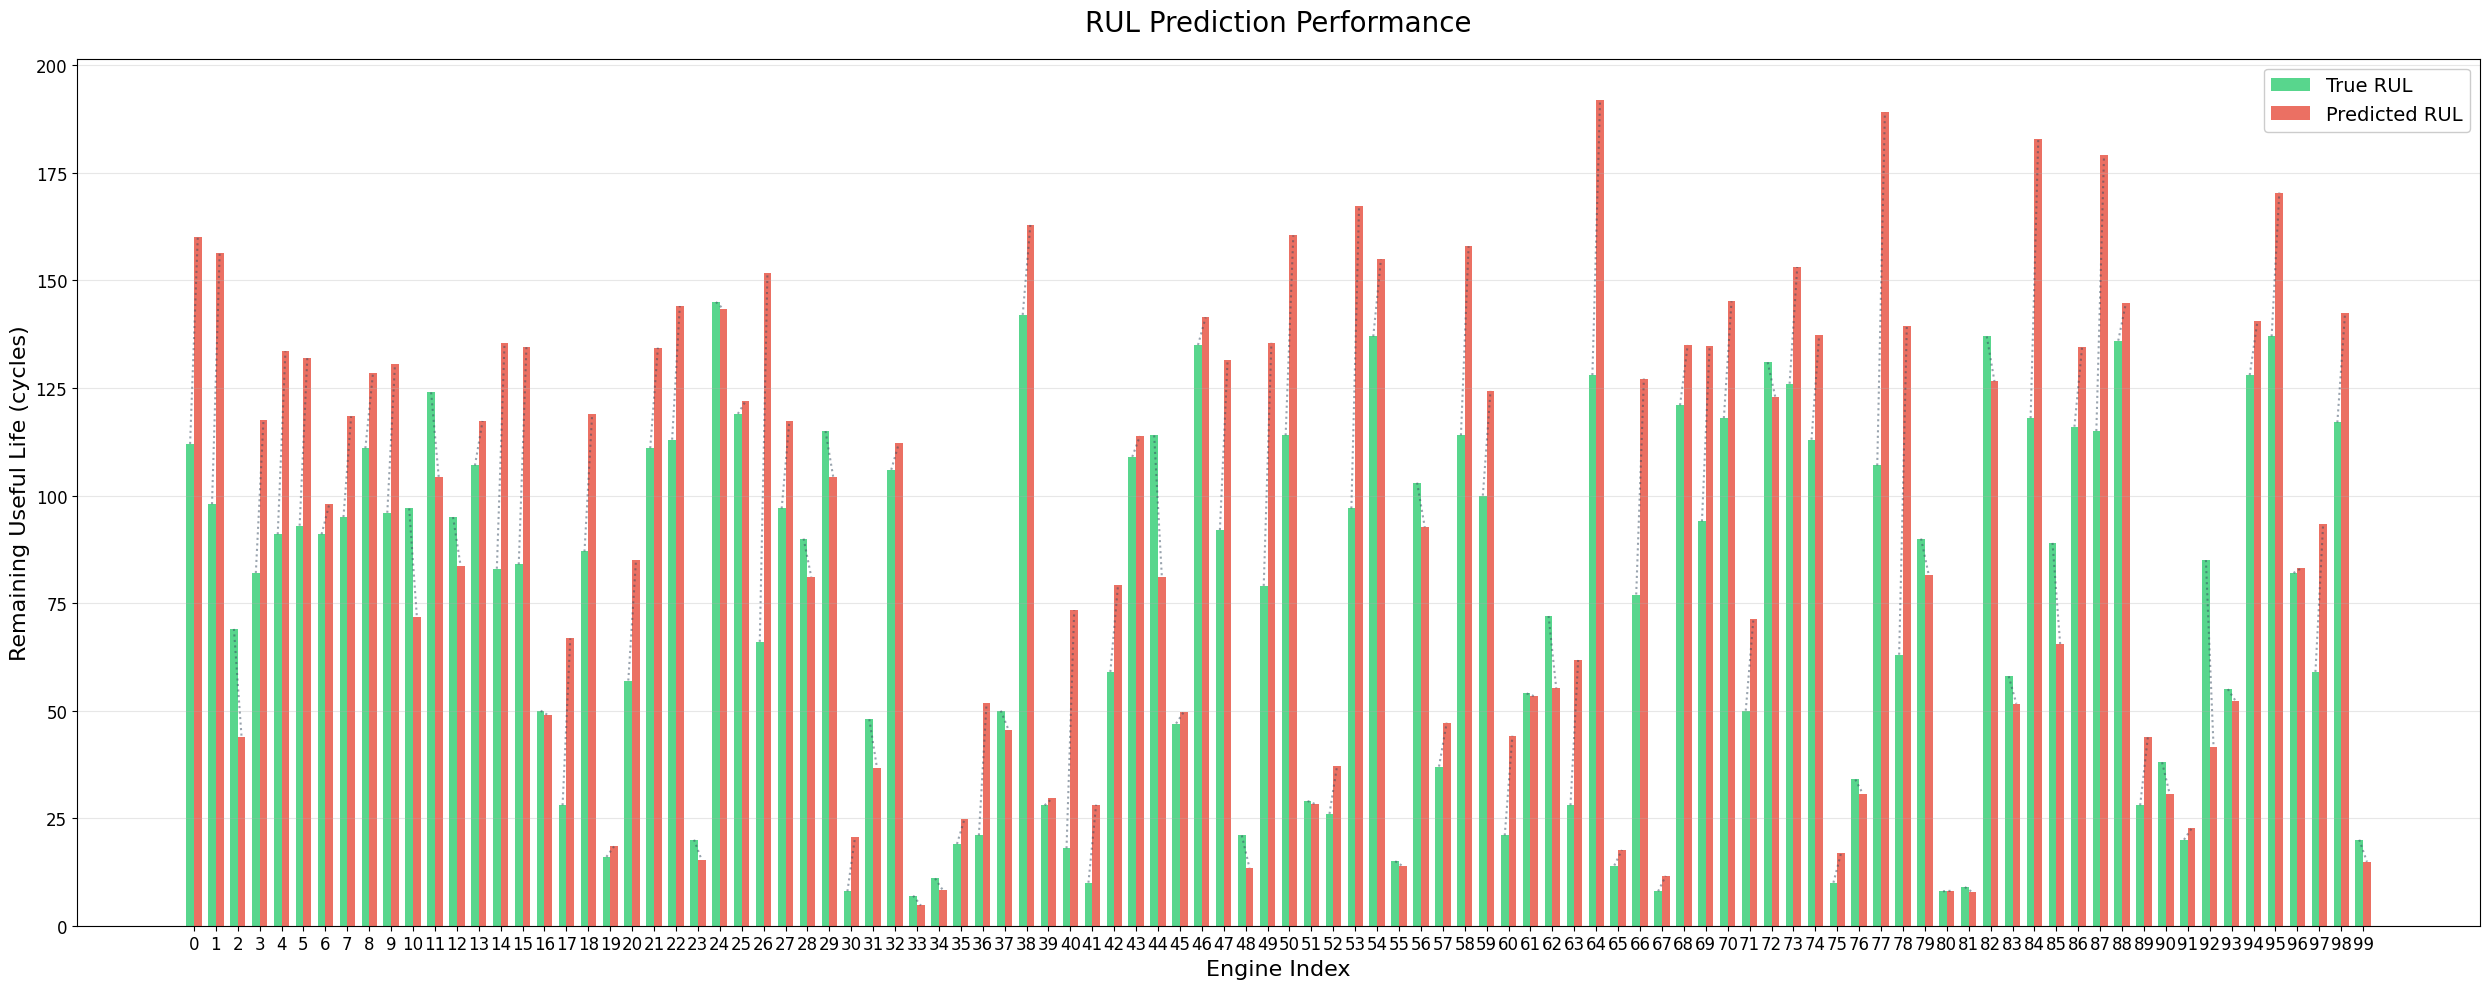

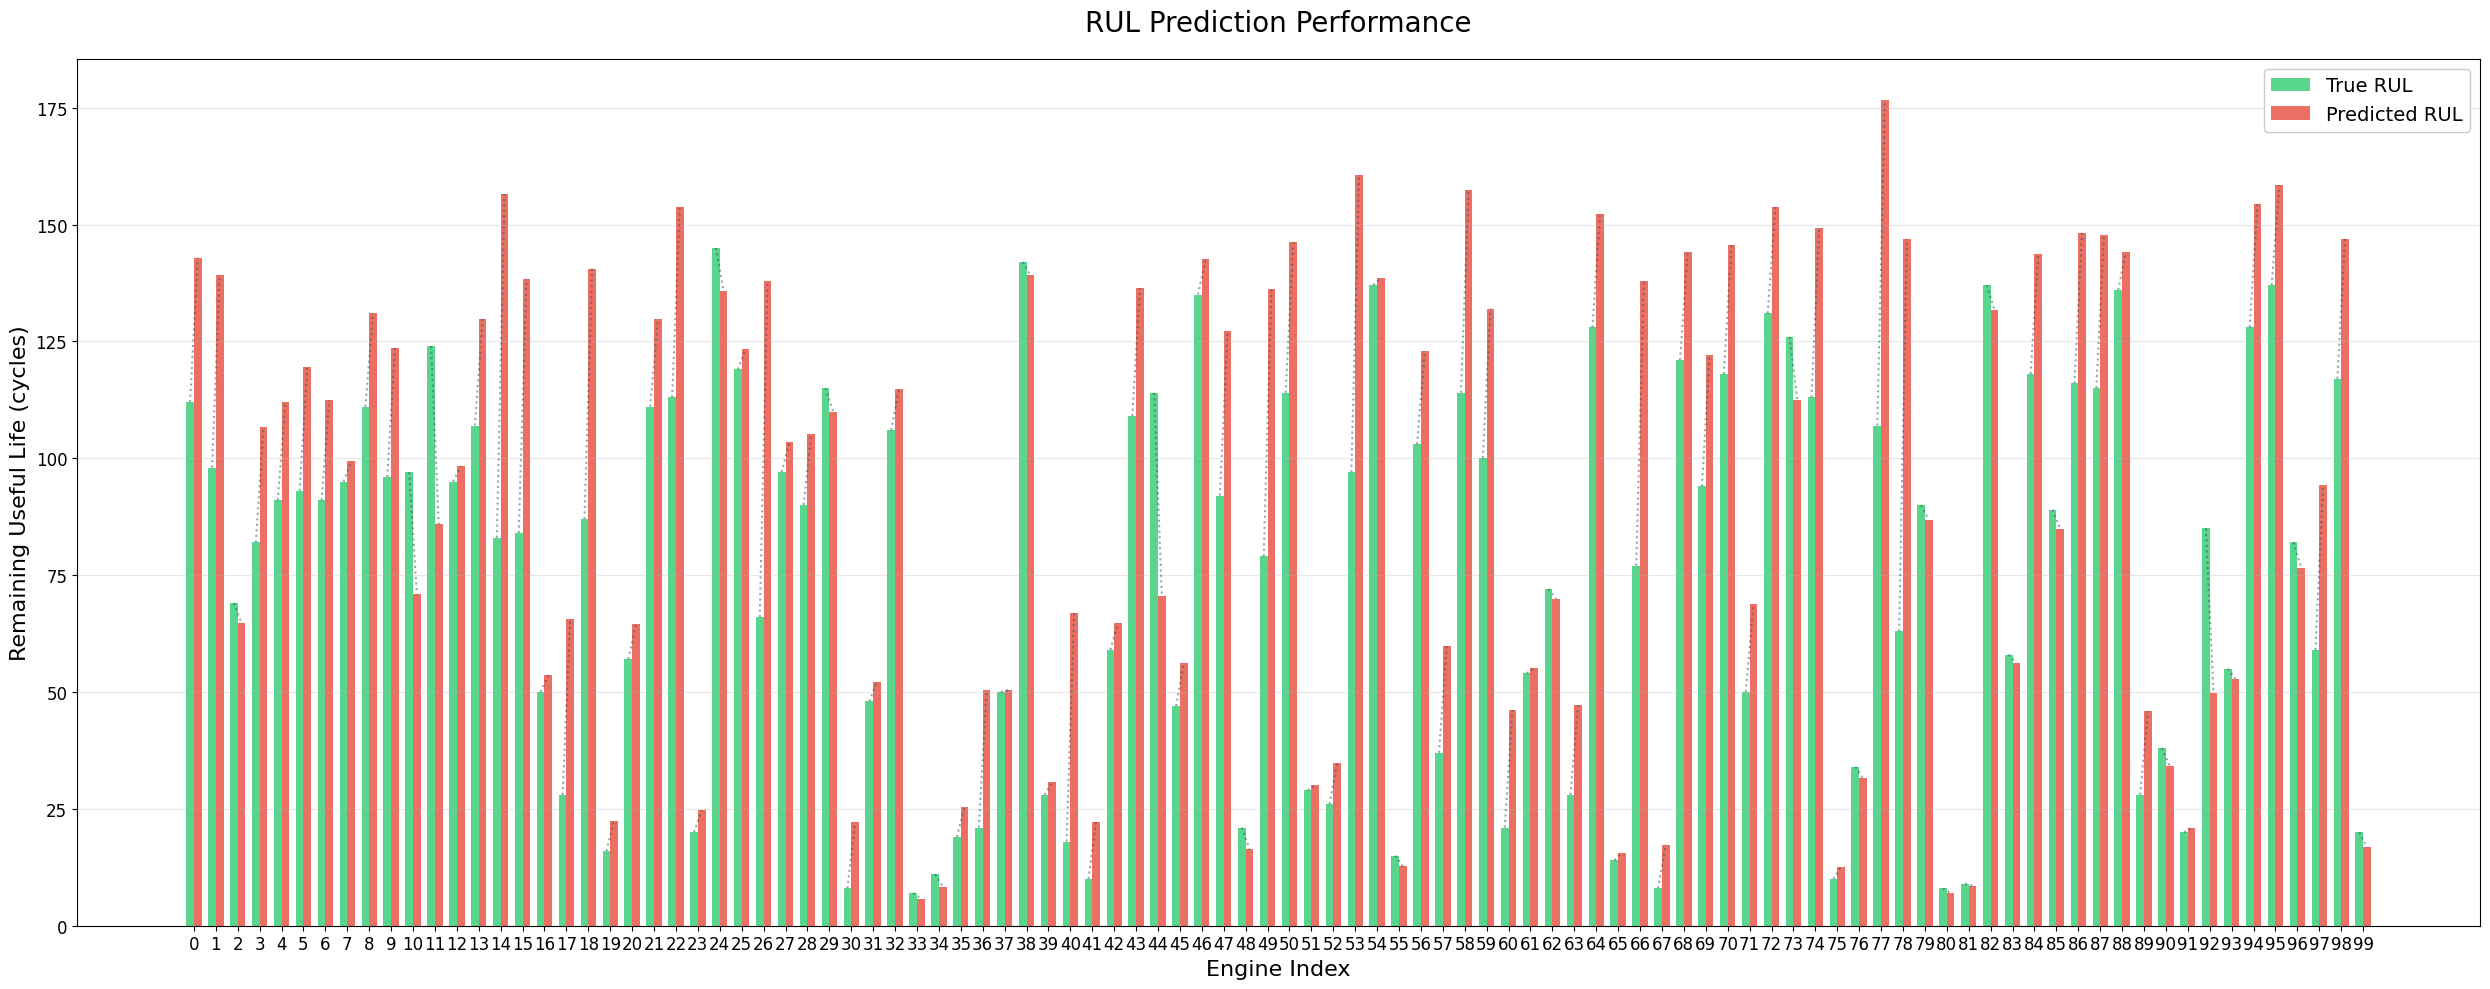

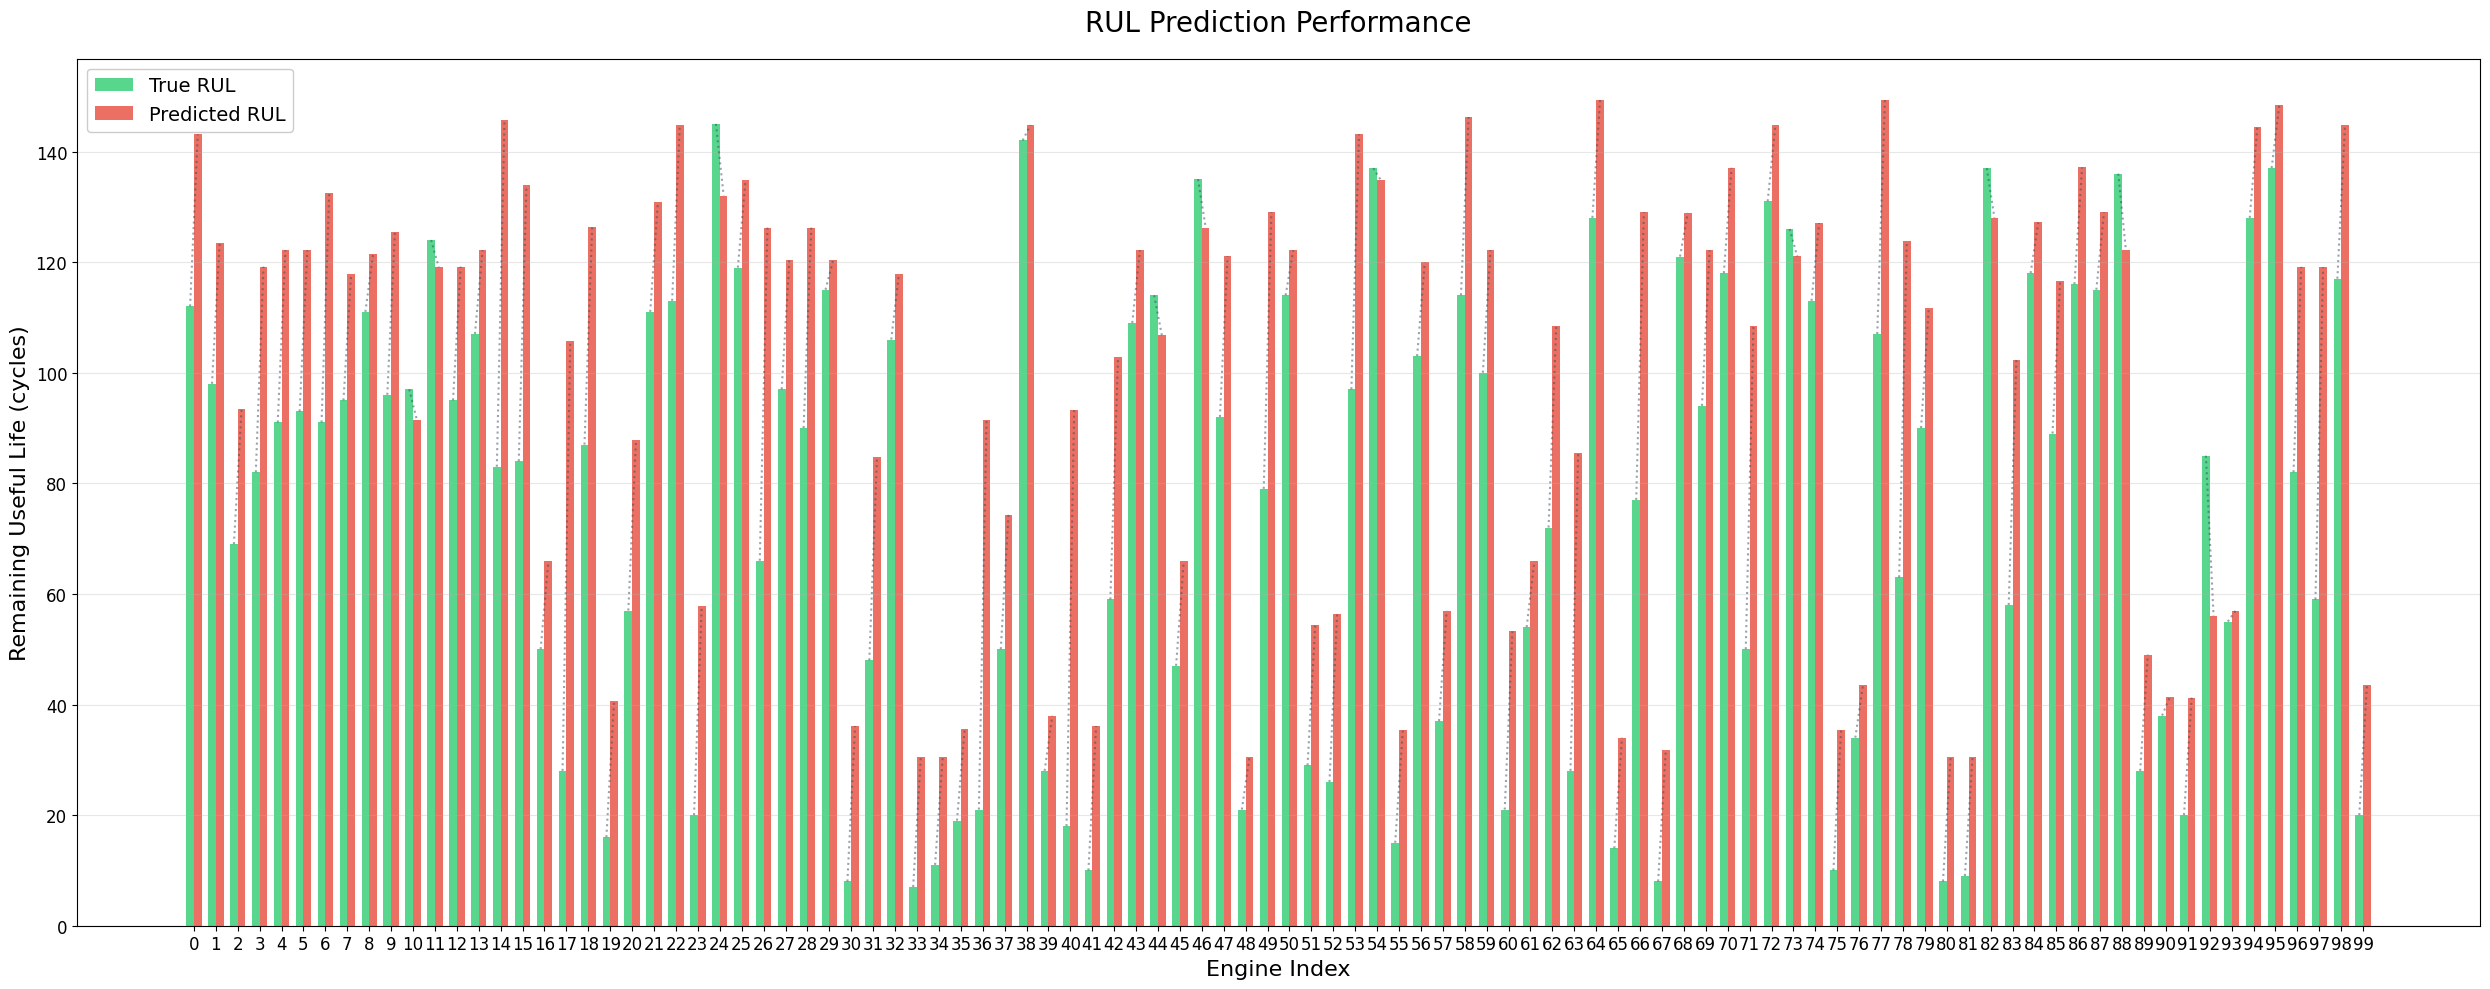

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

rs = 17
ensemble_models = {
    'RandomForest': RandomForestRegressor(random_state=rs),
    'GradientBoosting': GradientBoostingRegressor(random_state=rs),
    'XGBoost': XGBRegressor(random_state=rs, eval_metric='rmse'),
    'ExtraTrees': ExtraTreesRegressor(random_state=rs),  # Fixed name consistency
    'AdaBoost': AdaBoostRegressor(random_state=rs)
}

results_ensemble = {}
for name, model in ensemble_models.items():
    print(f'\nTraining {name} Regression')
    model.fit(X_train_2_s, y_train)  # Changed to _2_s
    
    # Predictions
    y_train_pred = model.predict(X_train_2_s)  # Changed to _2_s
    y_valid_pred = model.predict(X_valid_2_s)  # Changed to _2_s
    y_test_pred = model.predict(X_test_2_s)    # Changed to _2_s
    
    # Evaluation
    print(' Training Set:')
    train_rmse, train_r2 = evaluate(y_train, y_train_pred, 'Train')
    print(' Test Set:')
    test_rmse, test_r2 = evaluate(y_test, y_test_pred, 'Test')
    print(' Validation Set:')
    valid_rmse, valid_r2 = evaluate(y_valid, y_valid_pred, 'Valid')
    
    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        top_feature = X_train_2.columns[np.argmax(importance)]  # Changed to X_train_2
        print(f"\nMost Important Feature: {top_feature} ({importance.max():.2%})")
    
    # Store results
    results_ensemble[name] = {
        'y_pred_valid': y_valid_pred,
        'train_rmse': train_rmse,
        'valid_rmse': valid_rmse,
        'train_r2': train_r2,
        'valid_r2': valid_r2
    }

# Model Comparison
print("\n\n=== Ensemble Model Comparison ===")
print(f"{'Model':<20} | {'Train RMSE':>10} | {'Valid RMSE':>10} | {'Valid R2':>6}")
print("-"*60)
for name, metrics in sorted(results_ensemble.items(), key=lambda x: x[1]['valid_rmse']):
    print(f"{name:<20} | {metrics['train_rmse']:10.2f} | {metrics['valid_rmse']:10.2f} | {metrics['valid_r2']:6.2f}")

# Visualization
for model_name, results in results_ensemble.items():
    plot_pred_vs_actual(
        y_valid, 
        results['y_pred_valid'], 
        f"{model_name} (Valid RMSE: {results['valid_rmse']:.1f})"
    )

## 3rd attempt (data without useless sensors, with historical data)
We will try to discover a time series pattern in our features as we add to our data a new feature called 'rolling mean feature'. It's equivalent to the mean of value of a feature considering 10 time cycles. It will be computed for every feature

In [ ]:
# 1. Prepare data - keep only needed columns
drop_labels2 = ['s_1', 's_5','s_6','s_10','s_16','s_18','s_19']
features_to_keep = [col for col in X_train_2.columns if col not in drop_labels2]

df = df_train[features_to_keep + ['unit_number']].copy()
X_valid_3 = df_val[features_to_keep + ['unit_number']].copy()

# 2. Initialize rolling mean columns
for sensor in features_to_keep:
    df[f'{sensor}_rm'] = np.nan
    X_valid_3[f'{sensor}_rm'] = np.nan

# 3. Improved rolling mean calculation
def calculate_rolling_means(data, window=10):
    """Calculate rolling means per engine unit"""
    for unit_id, unit_data in data.groupby('unit_number'):
        for sensor in features_to_keep:
            # Calculate rolling mean
            rolling_mean = unit_data[sensor].rolling(window=window).mean()
            
            # Assign values (skip first window-1 points)
            start_idx = unit_data.index[0]
            data.loc[start_idx + window - 1:, f'{sensor}_rm'] = rolling_mean[window - 1:]
            
            # Fill initial window with original values
            data.loc[start_idx:start_idx + window - 2, f'{sensor}_rm'] = unit_data[sensor].iloc[:window - 1]
    return data.fillna(0)

# 4. Apply to both datasets
df = calculate_rolling_means(df)
X_valid_3 = calculate_rolling_means(X_valid_3)

# Verification
print("Training data columns:", df.columns.tolist())
print("Validation data columns:", X_valid_3.columns.tolist())
print("\nMissing values in training:", df.isnull().sum().sum())
print("Missing values in validation:", X_valid_3.isnull().sum().sum())

Training data columns: ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 'unit_number', 's_2_rm', 's_3_rm', 's_4_rm', 's_7_rm', 's_8_rm', 's_9_rm', 's_11_rm', 's_12_rm', 's_13_rm', 's_14_rm', 's_15_rm', 's_17_rm', 's_20_rm', 's_21_rm']
Validation data columns: ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 'unit_number', 's_2_rm', 's_3_rm', 's_4_rm', 's_7_rm', 's_8_rm', 's_9_rm', 's_11_rm', 's_12_rm', 's_13_rm', 's_14_rm', 's_15_rm', 's_17_rm', 's_20_rm', 's_21_rm']

Missing values in training: 0
Missing values in validation: 0


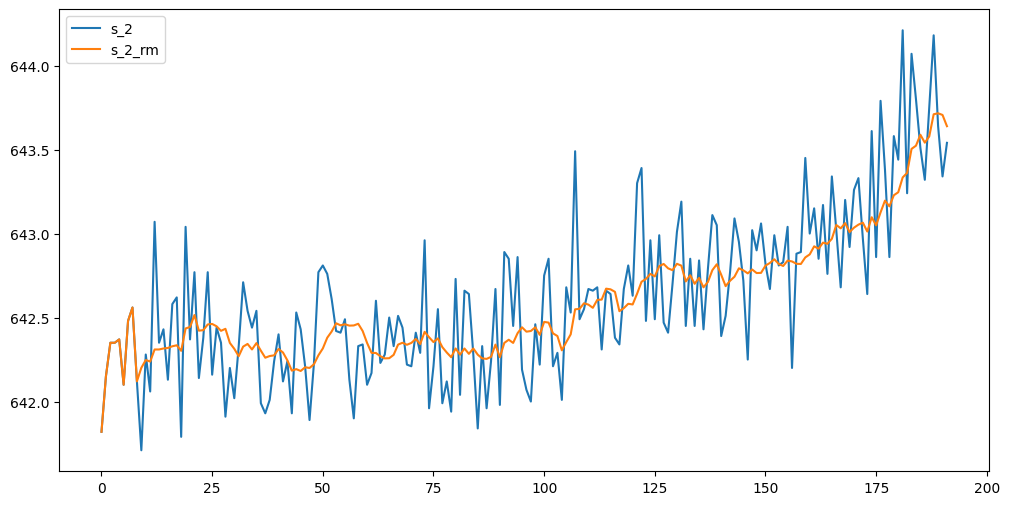

In [ ]:
sample_engine = df[df['unit_number'] == 1]
sample_engine[['s_2', 's_2_rm']].plot(figsize=(12, 6));

In [ ]:
# --- Data Preparation ---
# Drop index columns and prepare features
train_tm = df.drop(columns='unit_number', axis=1)

# --- Train-Test Split ---
X_train_tm, X_test_tm, y_train_tm, y_test_tm = train_test_split(
    train_tm,
    df_train['RUL'].clip(upper=195),  # Clip RUL at 195
    test_size=0.35,
    random_state=42
)

# --- Scaling ---
scaler = MinMaxScaler()
# Fit only on training data
X_train_tm_s = scaler.fit_transform(X_train_tm)
# Transform test and validation using training scaler
X_test_tm_s = scaler.transform(X_test_tm)

# --- Validation Set Preparation ---
# Combine unit_number with features
if 'unit_number' not in X_valid_3.columns:
    X_valid_3 = pd.concat([df_val['unit_number'], X_valid_3], axis=1)
# Take last record per engine
X_valid3 = (X_valid_3.groupby('unit_number')
             .last()
             .reset_index()
             .drop(columns=['unit_number']))
# Scale validation data
X_valid_s = scaler.transform(X_valid3)
print("Shapes")
print(f"Train: {X_train_tm_s.shape}, Test: {X_test_tm_s.shape}, Valid: {X_valid_s.shape}")

Shapes
Train: (13410, 28), Test: (7221, 28), Valid: (100, 28)


### Linear Models #3

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

linear_models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results_linear_tm = {}  # Changed to results_linear_tm
for name, model in linear_models.items():
    print(f'\nTraining {name} Regression (Time Features)')
    model.fit(X_train_tm_s, y_train_tm)  # Changed to _tm variables
    y_train_pred_tm = model.predict(X_train_tm_s)
    y_valid_pred_tm = model.predict(X_valid_s)  # Using X_valid_s from time features
    y_test_pred_tm = model.predict(X_test_tm_s)
    
    print(' Training Set:')
    train_rmse_tm, train_r2_tm = evaluate(y_train_tm, y_train_pred_tm, 'Train')
    print(' Test Set:')
    test_rmse_tm, test_r2_tm = evaluate(y_test_tm, y_test_pred_tm, 'Test')
    print(' Validation Set:')
    valid_rmse_tm, valid_r2_tm = evaluate(y_valid, y_valid_pred_tm, 'Valid')
    
    results_linear_tm[name] = {
        'y_pred_valid': y_valid_pred_tm,
        'train_rmse': train_rmse_tm,
        'valid_rmse': valid_rmse_tm,
        'test_rmse': test_rmse_tm,
        'train_r2': train_r2_tm,
        'valid_r2': valid_r2_tm,
        'test_r2': test_r2_tm
    }

# Model Comparison Table
print("\n\n=== Time Features Model Comparison ===")
print(f"{'Model':<20} | {'Train RMSE':>10} | {'Valid RMSE':>10} | {'Valid R2':>6}")
print("-"*60)
for name, metrics in sorted(results_linear_tm.items(), key=lambda x: x[1]['valid_rmse']):
    print(f"{name:<20} | {metrics['train_rmse']:10.2f} | {metrics['valid_rmse']:10.2f} | {metrics['valid_r2']:6.2f}")



Training Linear Regression (Time Features)
 Training Set:
        Train - RMSE: 35.41, R2: 0.66
 Test Set:
        Test - RMSE: 35.61, R2: 0.65
 Validation Set:
        Valid - RMSE: 29.87, R2: 0.48

Training Ridge Regression (Time Features)
 Training Set:
        Train - RMSE: 35.42, R2: 0.66
 Test Set:
        Test - RMSE: 35.59, R2: 0.65
 Validation Set:
        Valid - RMSE: 29.74, R2: 0.49

Training Lasso Regression (Time Features)
 Training Set:
        Train - RMSE: 35.76, R2: 0.65
 Test Set:
        Test - RMSE: 35.87, R2: 0.64
 Validation Set:
        Valid - RMSE: 29.62, R2: 0.49

Training Elastic Net Regression (Time Features)
 Training Set:
        Train - RMSE: 36.76, R2: 0.63
 Test Set:
        Test - RMSE: 36.87, R2: 0.62
 Validation Set:
        Valid - RMSE: 28.98, R2: 0.51


=== Time Features Model Comparison ===
Model                | Train RMSE | Valid RMSE | Valid R2
------------------------------------------------------------
Elastic Net          |      36.76 |  

__Winners__: ElasticNet and Lasso regularization helps Linear regression to help, we see that maybe not all features are stadistically significant

### Support Vector Machines #3

In [ ]:
from sklearn.svm import SVR

svm_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results_svm_tm = {}  # Changed to _tm suffix

for kernel in svm_kernels:
    model_name = f"SVM-{kernel.capitalize()}-TM"  # Added -TM suffix
    print(f'\nTraining {model_name} Regression (Time Features)')
    
    model = SVR(kernel=kernel)
    model.fit(X_train_tm_s, y_train_tm)  # Using time-feature scaled data
    
    y_train_pred_tm = model.predict(X_train_tm_s)
    y_valid_pred_tm = model.predict(X_valid_s)  # Using validation from time features
    y_test_pred_tm = model.predict(X_test_tm_s)
    
    print(' Training Set:')
    train_rmse_tm, train_r2_tm = evaluate(y_train_tm, y_train_pred_tm, 'Train')
    print(' Test Set:')
    test_rmse_tm, test_r2_tm = evaluate(y_test_tm, y_test_pred_tm, 'Test')
    print(' Validation Set:')
    valid_rmse_tm, valid_r2_tm = evaluate(y_valid, y_valid_pred_tm, 'Valid')
    
    results_svm_tm[model_name] = {
        'y_pred_valid': y_valid_pred_tm,
        'train_rmse': train_rmse_tm,
        'valid_rmse': valid_rmse_tm,
        'test_rmse': test_rmse_tm,
        'train_r2': train_r2_tm,
        'valid_r2': valid_r2_tm,
        'test_r2': test_r2_tm
    }

# Model Comparison Table
print("\n\n=== SVM Time Features Model Comparison ===")
print(f"{'Model':<20} | {'Train RMSE':>10} | {'Valid RMSE':>10} | {'Valid R2':>6}")
print("-"*60)
for name, metrics in sorted(results_svm_tm.items(), key=lambda x: x[1]['valid_rmse']):
    print(f"{name:<20} | {metrics['train_rmse']:10.2f} | {metrics['valid_rmse']:10.2f} | {metrics['valid_r2']:6.2f}")



Training SVM-Linear-TM Regression (Time Features)
 Training Set:
        Train - RMSE: 35.94, R2: 0.65
 Test Set:
        Test - RMSE: 36.06, R2: 0.64
 Validation Set:
        Valid - RMSE: 27.47, R2: 0.56

Training SVM-Poly-TM Regression (Time Features)
 Training Set:
        Train - RMSE: 32.88, R2: 0.71
 Test Set:
        Test - RMSE: 33.29, R2: 0.69
 Validation Set:
        Valid - RMSE: 27.41, R2: 0.56

Training SVM-Rbf-TM Regression (Time Features)
 Training Set:
        Train - RMSE: 32.47, R2: 0.71
 Test Set:
        Test - RMSE: 32.76, R2: 0.70
 Validation Set:
        Valid - RMSE: 27.69, R2: 0.56

Training SVM-Sigmoid-TM Regression (Time Features)
 Training Set:
        Train - RMSE: 60.58, R2: 0.00
 Test Set:
        Test - RMSE: 59.95, R2: 0.00
 Validation Set:
        Valid - RMSE: 49.15, R2: -0.40


=== SVM Time Features Model Comparison ===
Model                | Train RMSE | Valid RMSE | Valid R2
------------------------------------------------------------
SVM-Poly-TM

__Winners__: Poly and Linear get a good generalization, but Poly kernel is less prone to overfitting.

### Ensemble Models #3


Training RandomForest-TM Regression (Time Features)
 Training Set:
        Train - RMSE: 9.10, R2: 0.98
 Test Set:
        Test - RMSE: 24.70, R2: 0.83
 Validation Set:
        Valid - RMSE: 28.89, R2: 0.52

Most Important Time Feature: s_4_rm (49.13%)

Training GradientBoosting-TM Regression (Time Features)
 Training Set:
        Train - RMSE: 28.59, R2: 0.78
 Test Set:
        Test - RMSE: 29.94, R2: 0.75
 Validation Set:
        Valid - RMSE: 28.11, R2: 0.54

Most Important Time Feature: s_4_rm (33.81%)

Training XGBoost-TM Regression (Time Features)
 Training Set:
        Train - RMSE: 12.80, R2: 0.96
 Test Set:
        Test - RMSE: 27.18, R2: 0.80
 Validation Set:
        Valid - RMSE: 29.69, R2: 0.49

Most Important Time Feature: s_4_rm (39.27%)

Training ExtraTrees-TM Regression (Time Features)
 Training Set:
        Train - RMSE: 0.00, R2: 1.00
 Test Set:
        Test - RMSE: 24.11, R2: 0.84
 Validation Set:
        Valid - RMSE: 27.59, R2: 0.56

Most Important Time Feature: s

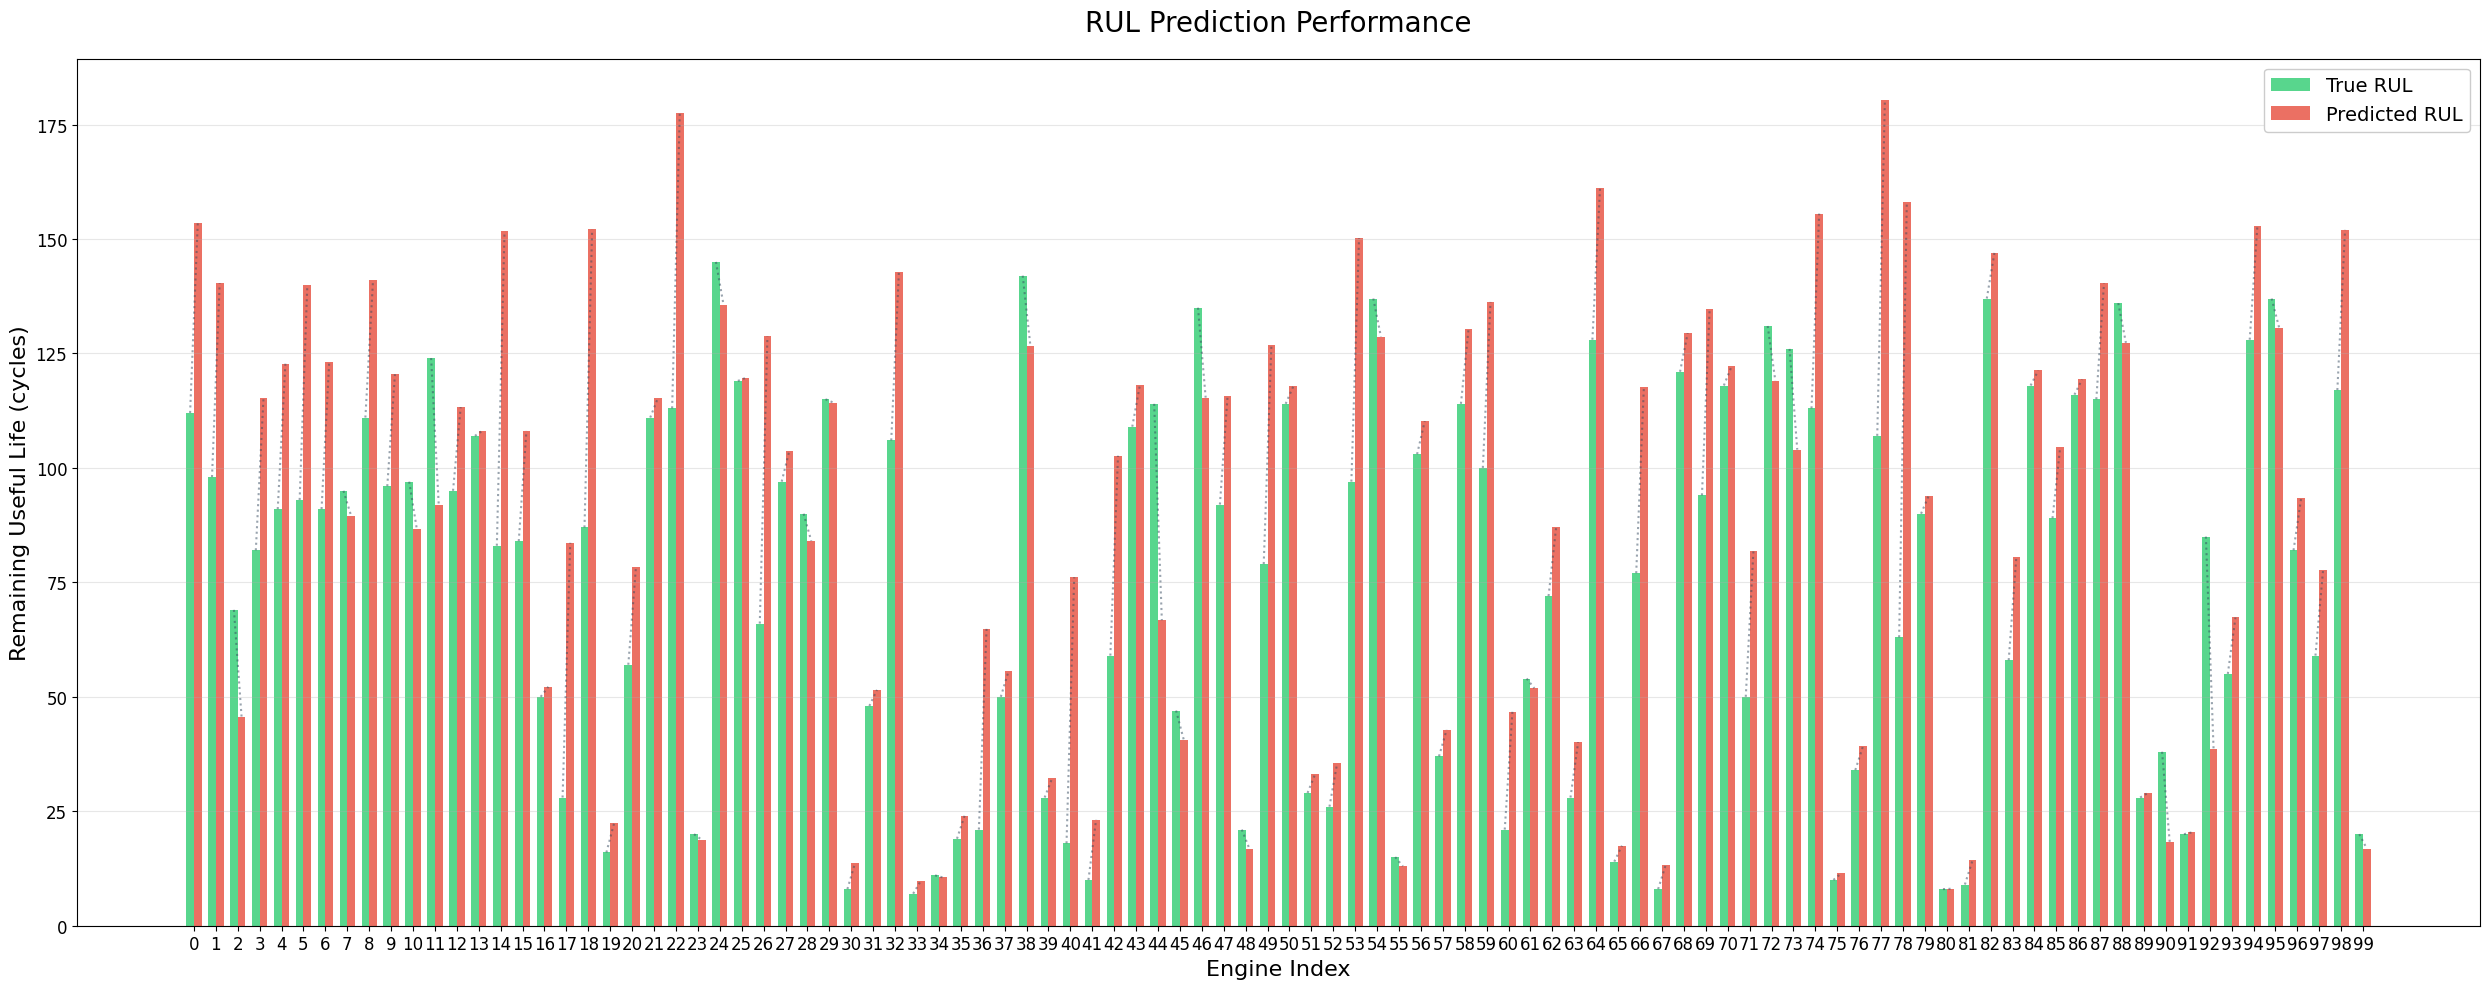

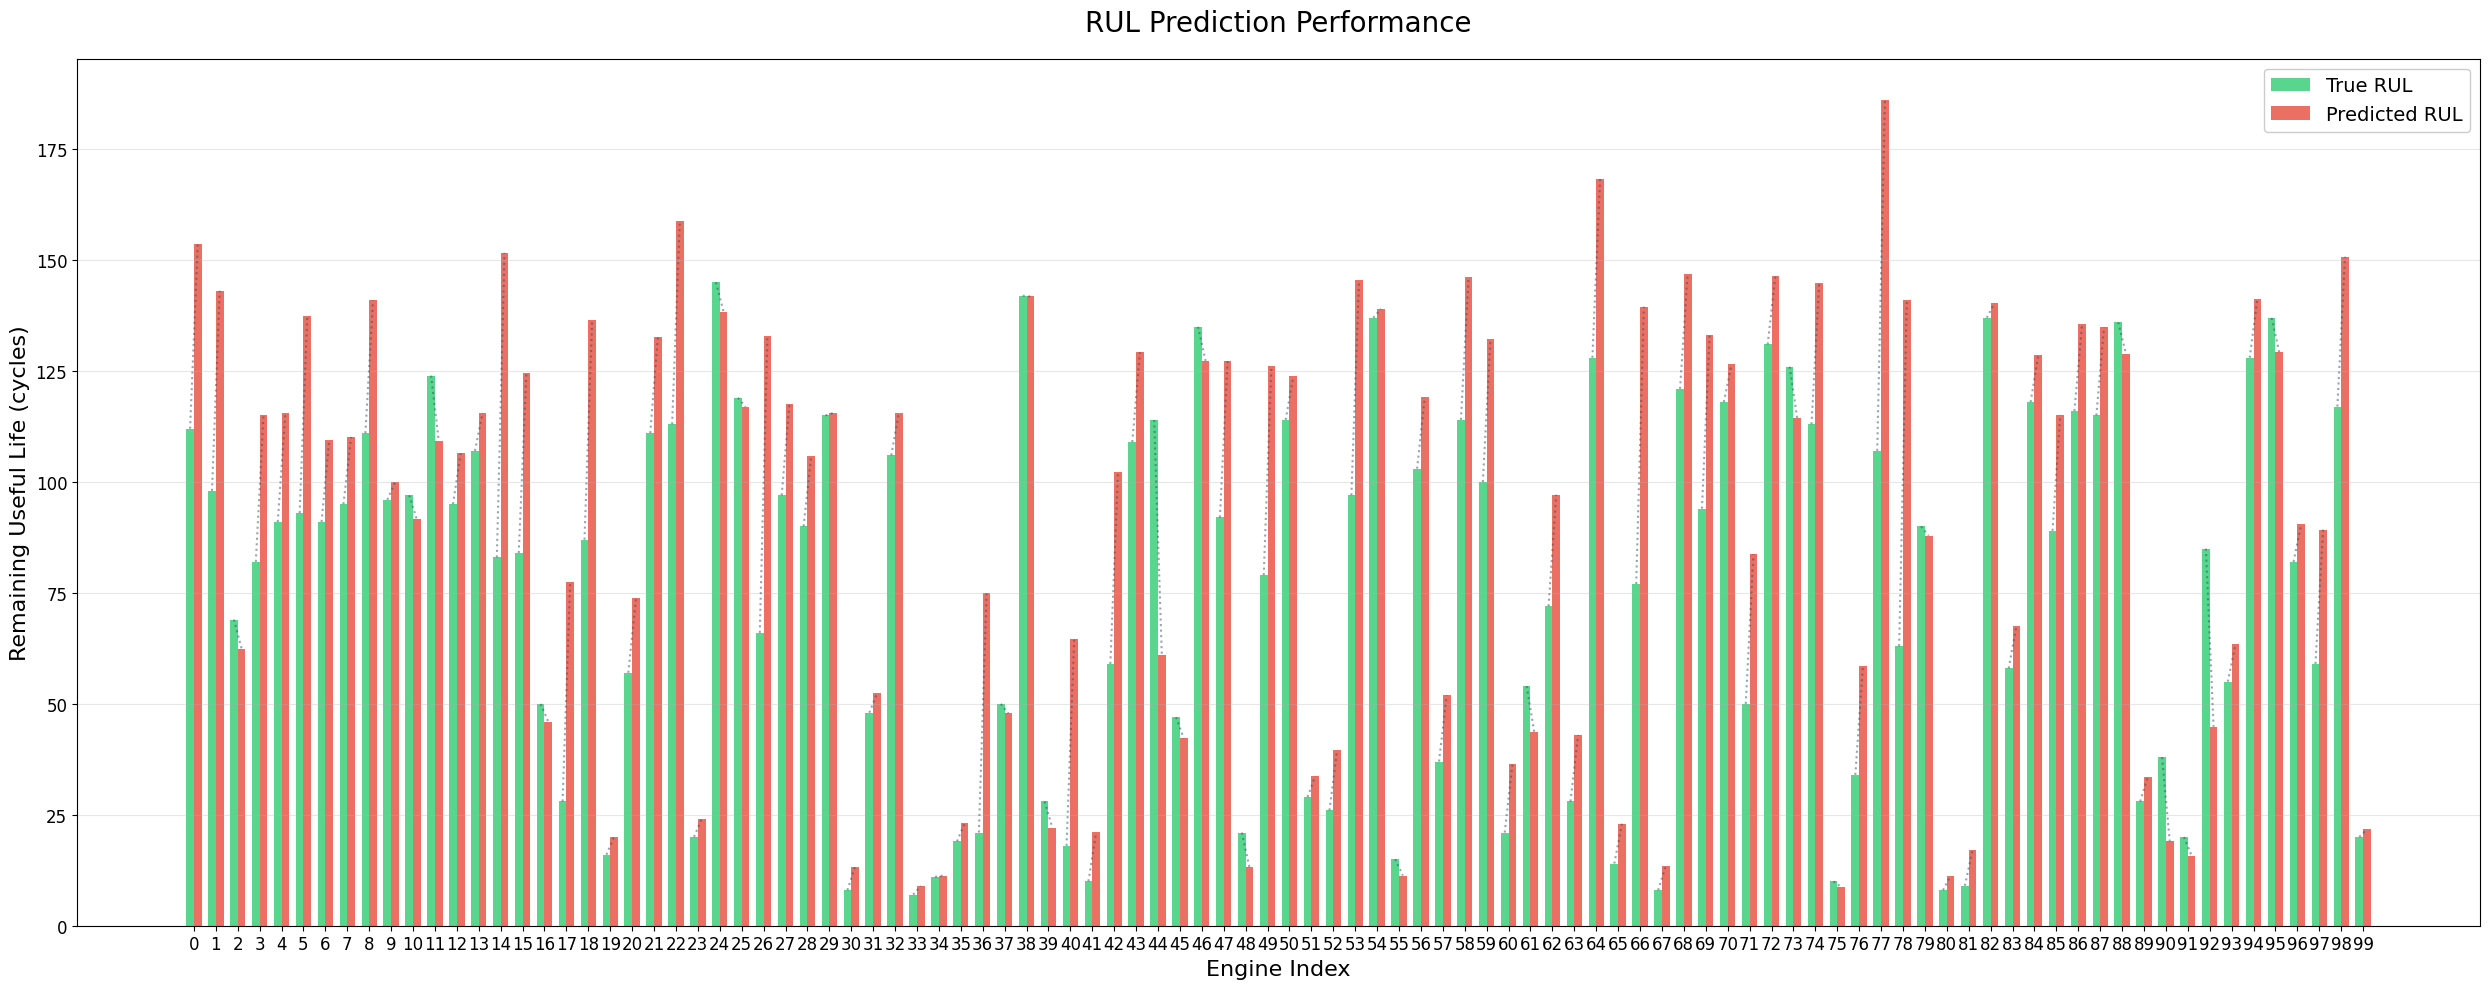

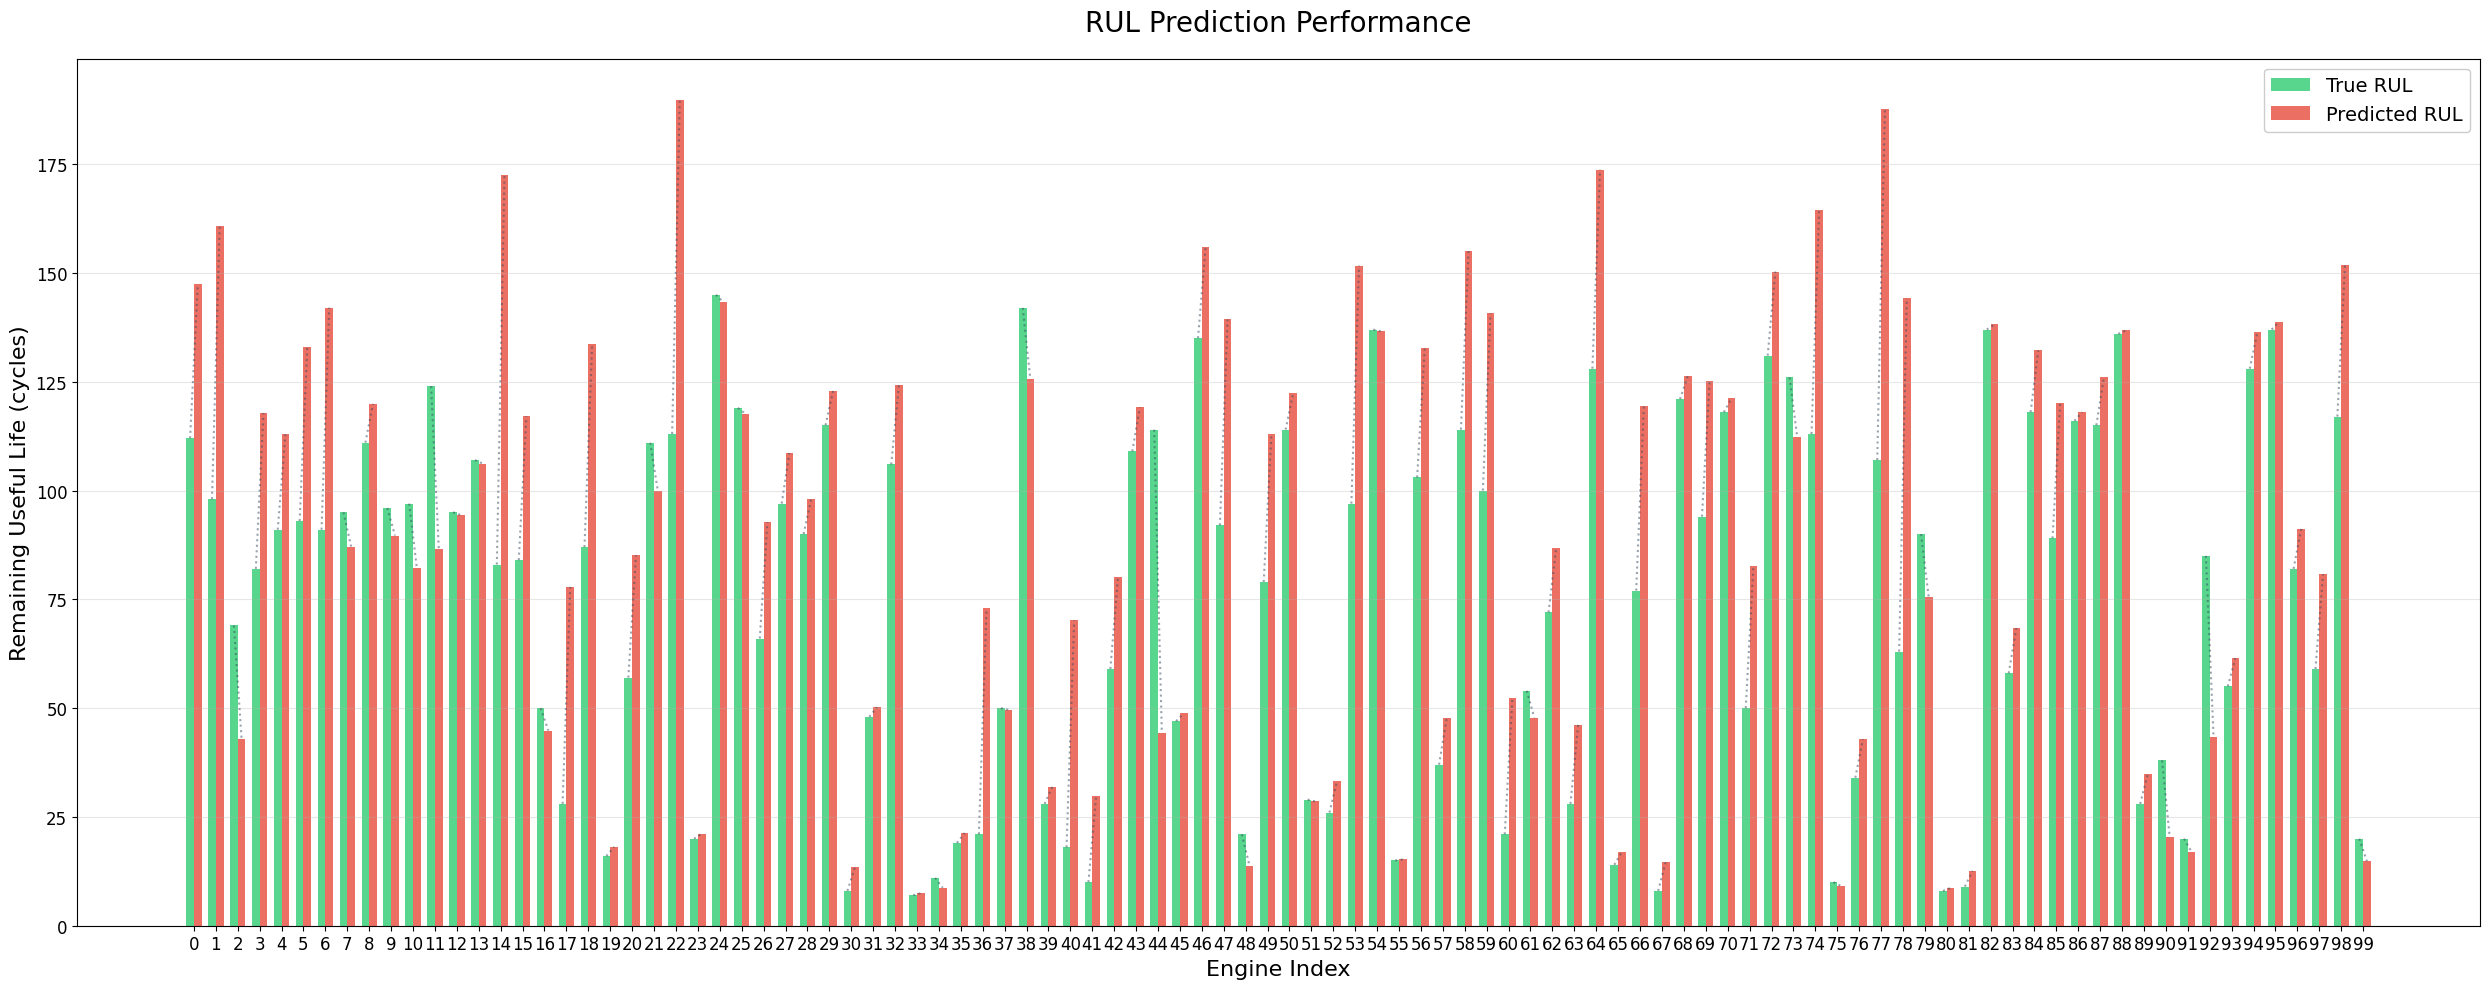

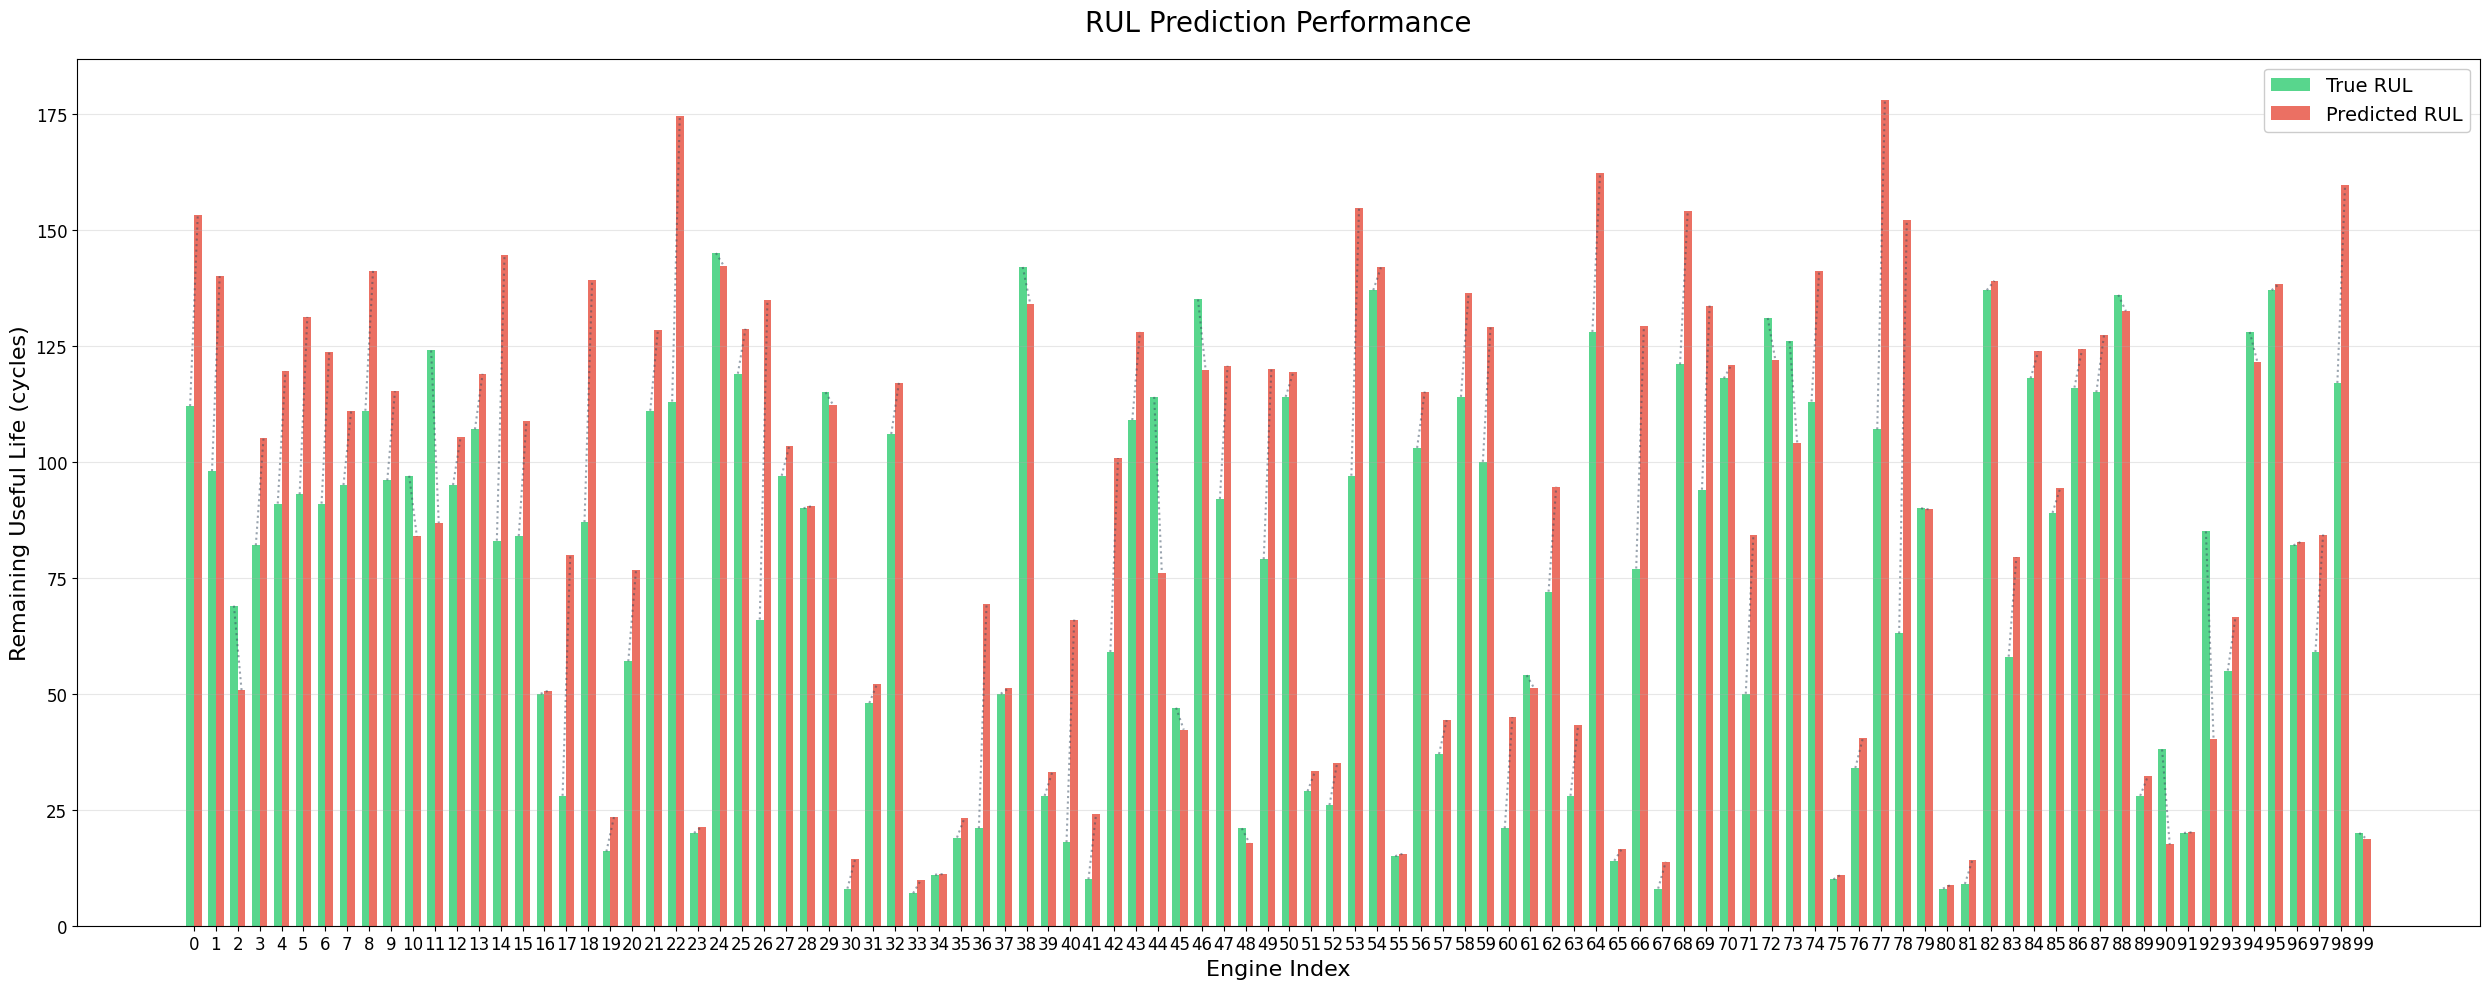

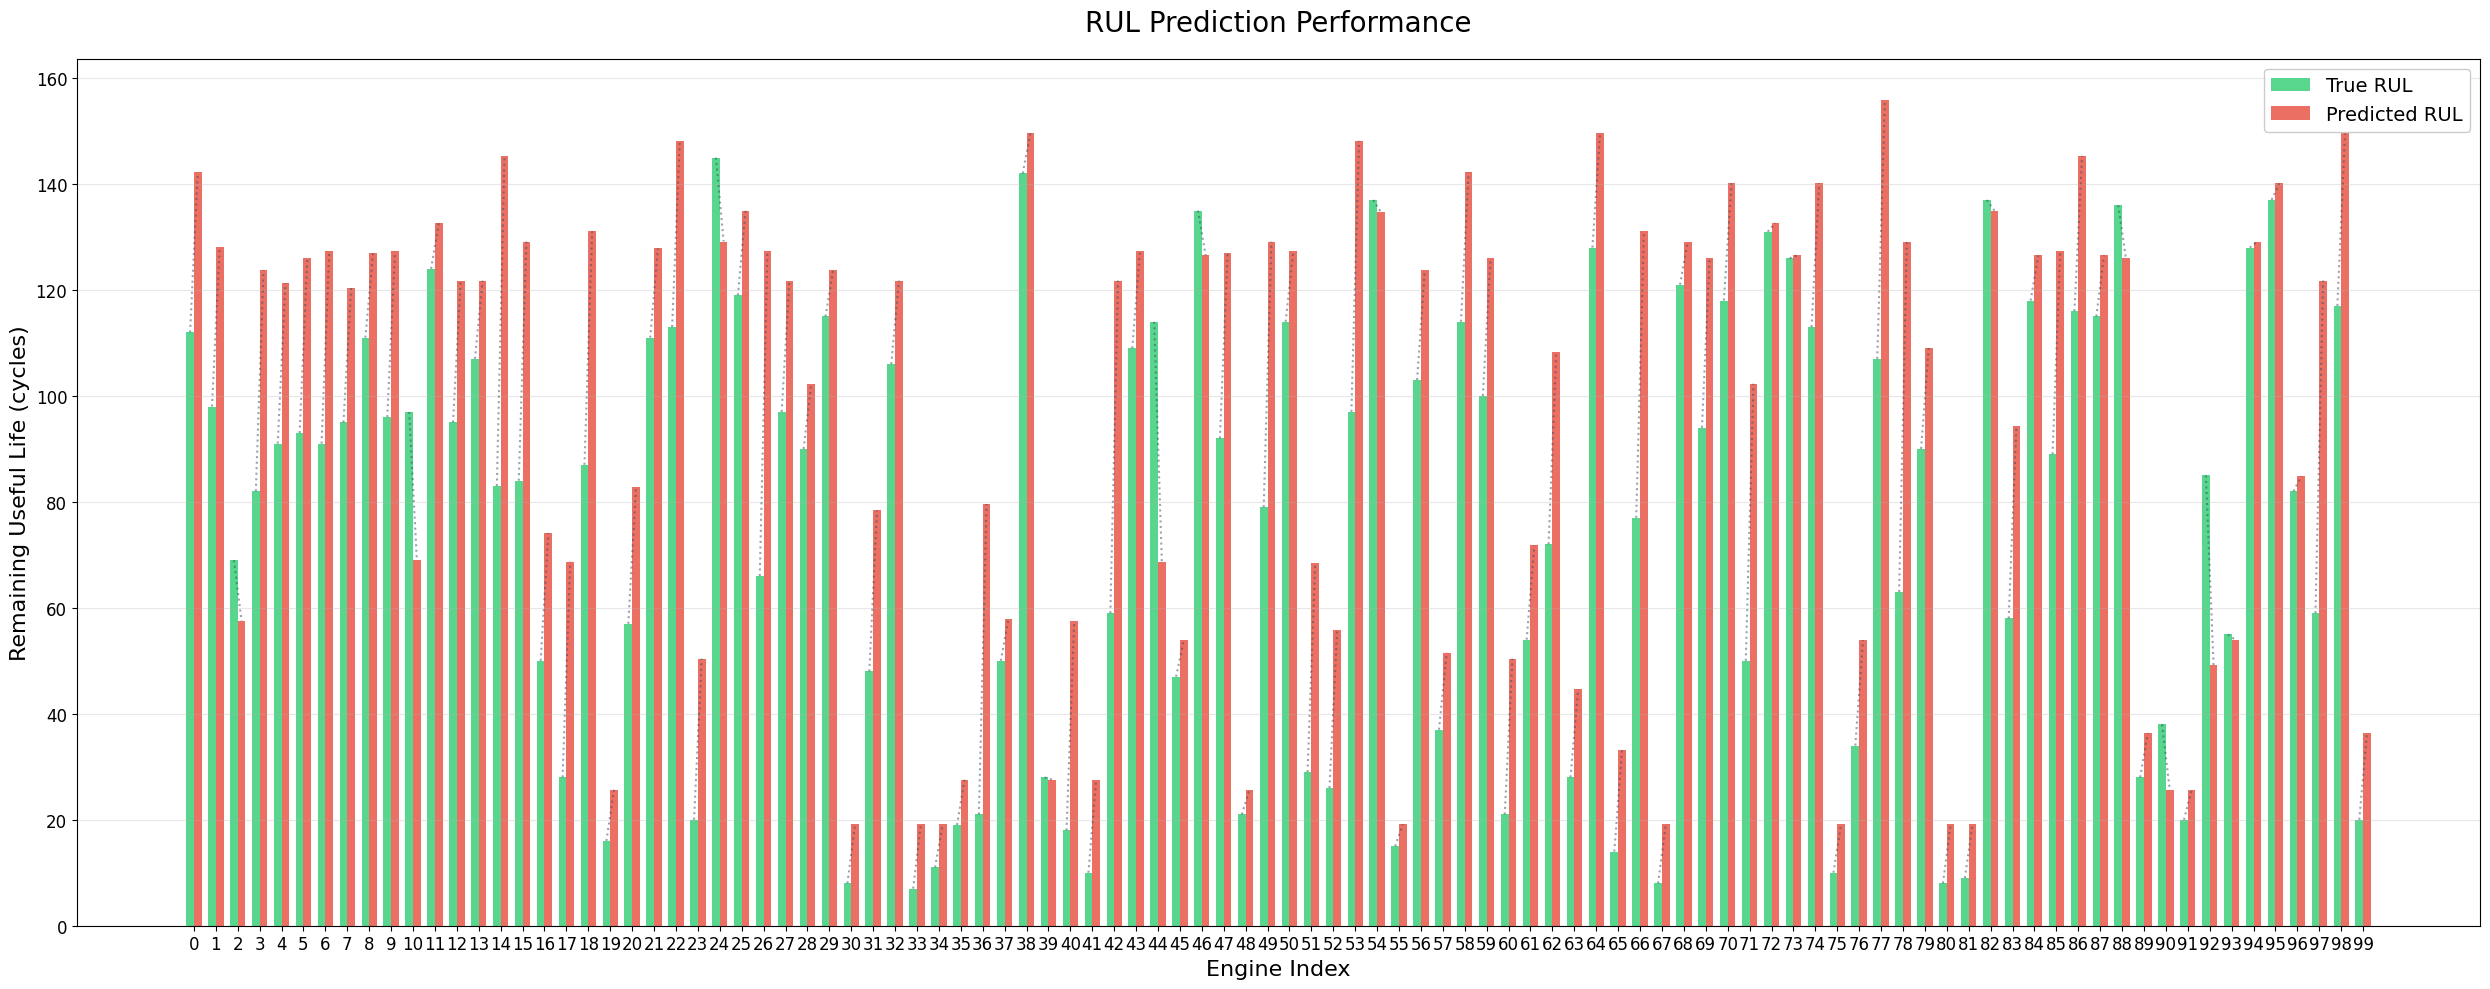

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

rs = 17
ensemble_models_tm = {  # Changed to _tm suffix
    'RandomForest-TM': RandomForestRegressor(random_state=rs),
    'GradientBoosting-TM': GradientBoostingRegressor(random_state=rs),
    'XGBoost-TM': XGBRegressor(random_state=rs, eval_metric='rmse'),
    'ExtraTrees-TM': ExtraTreesRegressor(random_state=rs),
    'AdaBoost-TM': AdaBoostRegressor(random_state=rs)
}

results_ensemble_tm = {}  # Changed to _tm suffix
for name, model in ensemble_models_tm.items():
    print(f'\nTraining {name} Regression (Time Features)')
    model.fit(X_train_tm_s, y_train_tm)  # Using time-feature scaled data
    
    # Predictions
    y_train_pred_tm = model.predict(X_train_tm_s)
    y_valid_pred_tm = model.predict(X_valid_s)  # Using validation from time features
    y_test_pred_tm = model.predict(X_test_tm_s)
    
    # Evaluation
    print(' Training Set:')
    train_rmse_tm, train_r2_tm = evaluate(y_train_tm, y_train_pred_tm, 'Train')
    print(' Test Set:')
    test_rmse_tm, test_r2_tm = evaluate(y_test_tm, y_test_pred_tm, 'Test')
    print(' Validation Set:')
    valid_rmse_tm, valid_r2_tm = evaluate(y_valid, y_valid_pred_tm, 'Valid')
    
    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        top_feature = X_train_tm.columns[np.argmax(importance)]  # Using time-feature columns
        print(f"\nMost Important Time Feature: {top_feature} ({importance.max():.2%})")
    
    # Store results
    results_ensemble_tm[name] = {
        'y_pred_valid': y_valid_pred_tm,
        'train_rmse': train_rmse_tm,
        'valid_rmse': valid_rmse_tm,
        'train_r2': train_r2_tm,
        'valid_r2': valid_r2_tm
    }

# Model Comparison Table
print("\n\n=== Ensemble Time Features Model Comparison ===")
print(f"{'Model':<20} | {'Train RMSE':>10} | {'Valid RMSE':>10} | {'Valid R2':>6}")
print("-"*60)
for name, metrics in sorted(results_ensemble_tm.items(), key=lambda x: x[1]['valid_rmse']):
    print(f"{name:<20} | {metrics['train_rmse']:10.2f} | {metrics['valid_rmse']:10.2f} | {metrics['valid_r2']:6.2f}")

# Visualization
for model_name, results in results_ensemble_tm.items():
    plot_pred_vs_actual(
        y_valid, 
        results['y_pred_valid'], 
        f"{model_name} (Valid RMSE: {results['valid_rmse']:.1f})"
    )

__Winners__: GradientBoosting and RandomForest are clearly the less prone to overfitting, but extratrees did a mid-good job, despite getting R2=1 in the training set.

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from time import time
from sklearn.base import clone

# Custom RMSE scorer
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

# Model configurations
model_configs = {
    # Linear Models
    'ElasticNet': {
        'estimator': ElasticNet(random_state=42, max_iter=10000),
        'param_grid': {
            'alpha': [0.001, 0.01, 0.1, 1, 10],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # 0=l2, 1=l1
        },
        'n_jobs': -1  # Safe for linear models
    },
    'Lasso': {
        'estimator': Lasso(random_state=42, max_iter=10000),
        'param_grid': {
            'alpha': [0.001, 0.01, 0.1, 1, 10]
        },
        'n_jobs': -1
    },
    
    # Ensemble Models
    'RandomForest': {
        'estimator': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'max_features': ['sqrt', 'log2']
        },
        'n_jobs': 2  # More conservative for memory-intensive models
    },
    'GradientBoosting': {
        'estimator': GradientBoostingRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        },
        'n_jobs': 1  # GB doesn't parallelize well during training
    }
}

def safe_grid_search(model, params, X, y, n_jobs=1, cv=3):
    """Robust grid search with error handling"""
    try:
        gs = GridSearchCV(
            estimator=model,
            param_grid=params,
            scoring=rmse_scorer,
            cv=cv,
            n_jobs=n_jobs,
            verbose=1
        )
        gs.fit(X, y)
        return {
            'estimator': gs.best_estimator_,
            'rmse': -gs.best_score_,
            'params': gs.best_params_,
            'status': 'success'
        }
    except Exception as e:
        print(f"Grid search failed: {str(e)}")
        return {
            'estimator': model.set_params(**{k: v[0] for k, v in params.items()}),
            'rmse': None,
            'params': {k: v[0] for k, v in params.items()},
            'status': 'default'
        }

# Main tuning process
best_models = {}
for name, config in model_configs.items():
    print(f"\n=== Tuning {name} ===")
    print(f"Parameter combinations: {np.prod([len(v) for v in config['param_grid'].values()]):,}")
    
    start_time = time()
    
    result = safe_grid_search(
        model=clone(config['estimator']),
        params=config['param_grid'],
        X=X_train,
        y=y_train,
        n_jobs=config['n_jobs'],
        cv=3
    )
    
    # Evaluate on validation set
    val_pred = result['estimator'].predict(X_valid)
    val_rmse = np.sqrt(mean_squared_error(y_valid, val_pred))
    
    best_models[name] = {
        'model': result['estimator'],
        'train_rmse': result['rmse'],
        'val_rmse': val_rmse,
        'params': result['params'],
        'tuning_status': result['status'],
        'time': time() - start_time
    }
    
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Best params: {result['params']}")

# Select best model
final_model_info = min(
    (m for m in best_models.values() if m['train_rmse'] is not None),
    key=lambda x: x['val_rmse']
)
final_model = final_model_info['model']

print(f"\n=== Best Model ===")
print(f"Algorithm: {type(final_model).__name__}")
print(f"Validation RMSE: {final_model_info['val_rmse']:.4f}")
print(f"Training RMSE: {final_model_info['train_rmse']:.4f}")
print(f"Parameters: {final_model_info['params']}")

# Final evaluation on test set (if available)
if 'X_test' in locals():
    test_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    print(f"\nTest RMSE: {test_rmse:.4f}")


=== Tuning ElasticNet ===
Parameter combinations: 25
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Validation RMSE: 28.8321
Best params: {'alpha': 0.001, 'l1_ratio': 0.9}

=== Tuning Lasso ===
Parameter combinations: 5
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Validation RMSE: 28.8049
Best params: {'alpha': 0.001}

=== Tuning RandomForest ===
Parameter combinations: 72
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Validation RMSE: 27.4981
Best params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}

=== Tuning GradientBoosting ===
Parameter combinations: 81
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Validation RMSE: 28.0914
Best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

=== Best Model ===
Algorithm: RandomForestRegressor
Validation RMSE: 27.4981
Training RMSE: 32.1568
Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_

After Hyperparameter tuning: RandomForestRegressor with
- Algorithm: RandomForestRegressor
- Validation RMSE: 27.4981
- Training RMSE: 32.1568
- Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}

But i'd prefer a Gradient Boosting, we saw it beneficiates in this case from a small leaerning rate (0.05) and max_depth (5), also a mid-high n_estimators (100) and a subsample of 0.8.

In [ ]:
import joblib
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
# 1. Define the individual models with their best parameters
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=17,
    validation_fraction=0.1,
    n_iter_no_change=5
)

rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=15,
    min_samples_split=2,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    random_state=17
)

# 2. Create individual pipelines
gb_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', gb_model)
])

rf_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', rf_model)
])

# 3. Create the ensemble with optimized weights
# (You can adjust weights based on individual model performance)
ensemble = VotingRegressor([
    ('gb', gb_pipeline),
    ('rf', rf_pipeline)
], weights=[0.8, 0.2])  # Giving slightly more weight to Gradient Boosting

# 4. Train on combined training + validation data
X_full = np.vstack([X_train, X_valid])
y_full = np.concatenate([y_train, y_valid.to_numpy().ravel()])

ensemble.fit(X_full, y_full)

# 5. Evaluate final performance
train_pred = ensemble.predict(X_full)
test_pred = ensemble.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_full, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Final Ensemble Performance:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# # Save the ensemble model <- not needed, this notebook is just for understanding the data and which techniques could help
# model_name = "ensemble_gb_rf.joblib"
# joblib.dump(ensemble, model_name)
# print(f"Model saved as {model_name}")

Final Ensemble Performance:
Training RMSE: 27.93
Test RMSE: 32.90


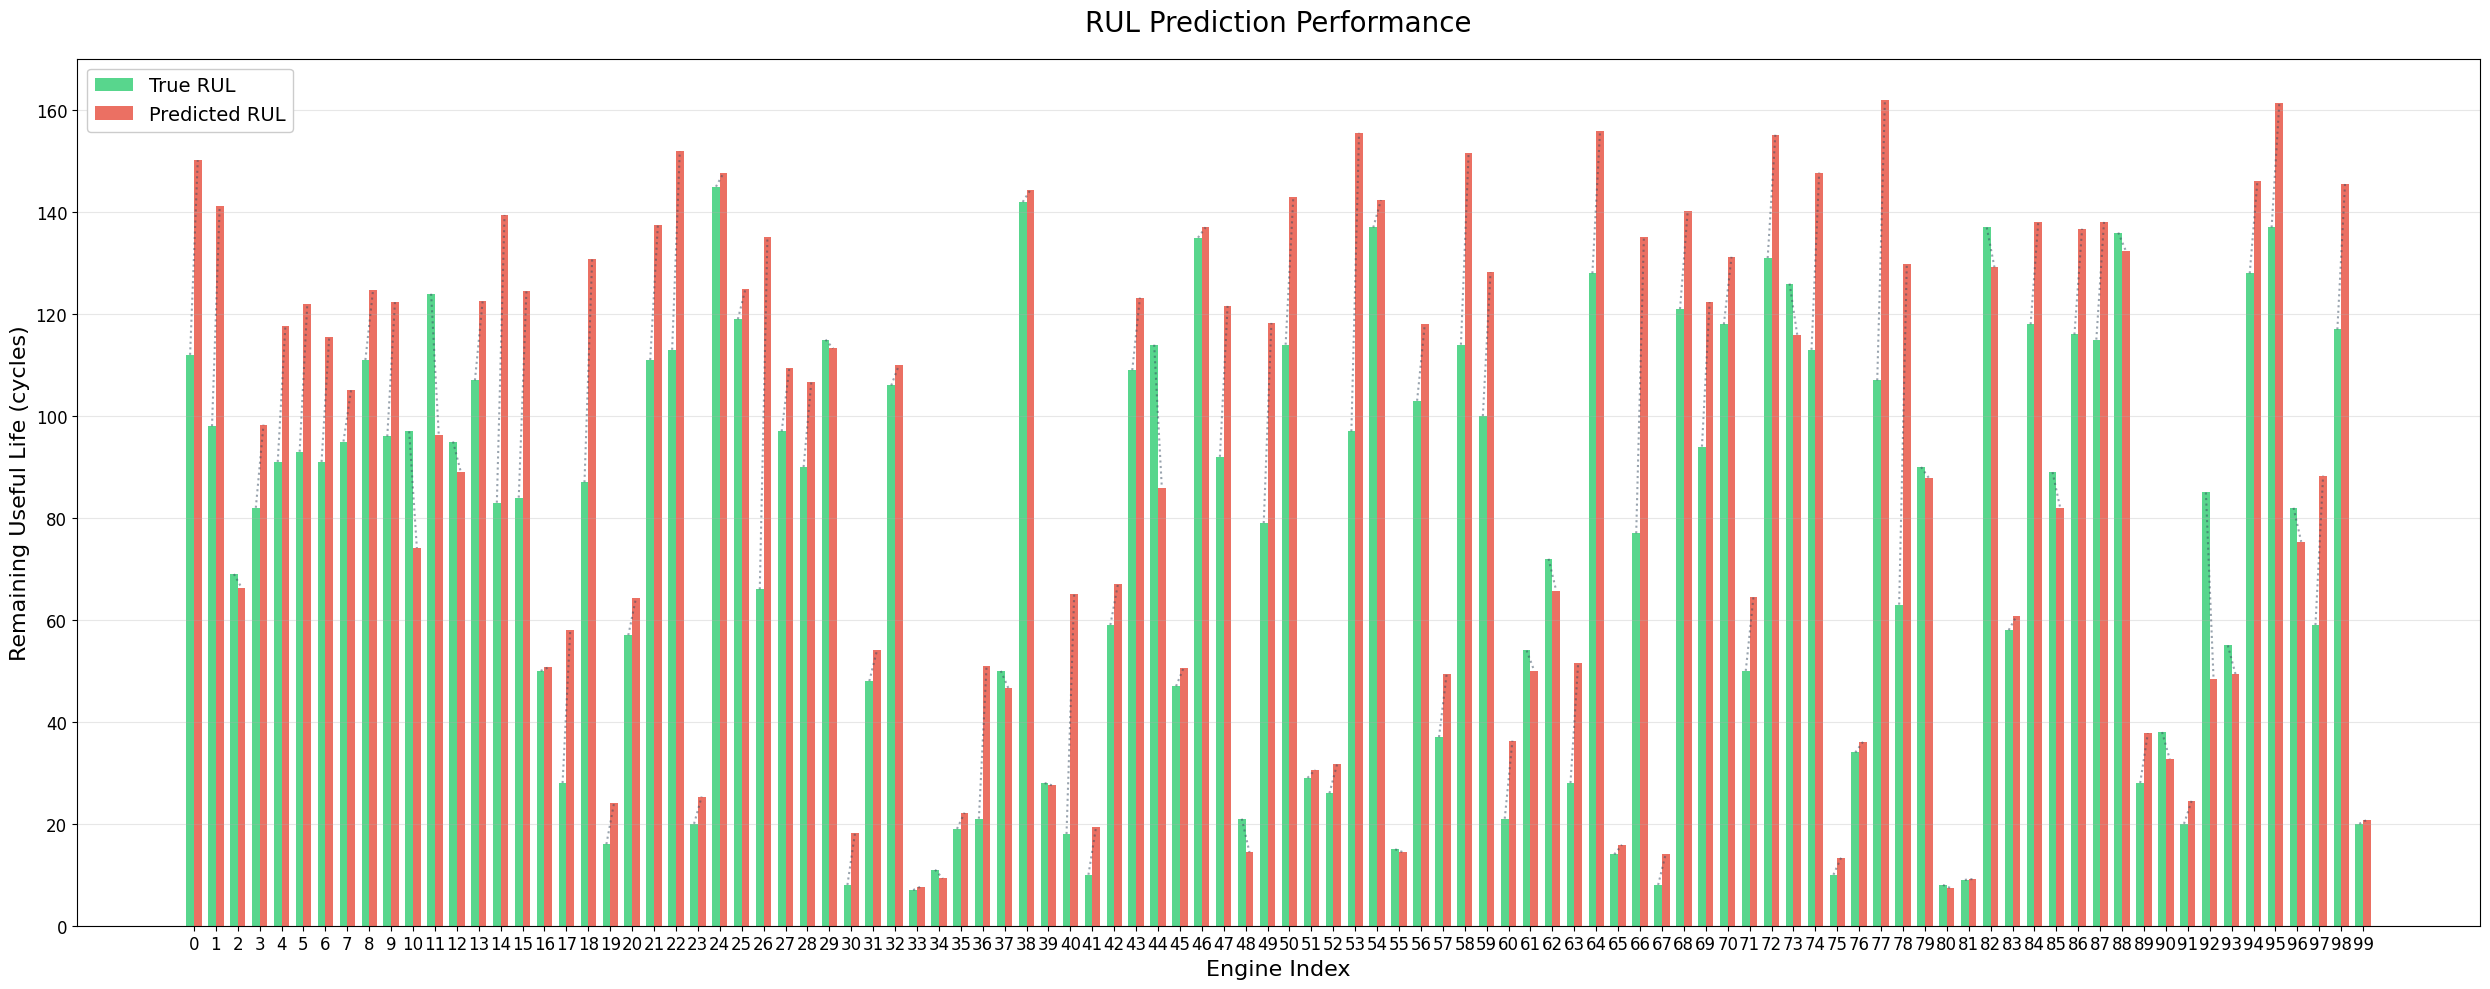

In [ ]:
valid_predict = ensemble.predict(X_valid)
plot_pred_vs_actual(y_valid, valid_predict)

In [ ]:
dftm = pd.concat([df_train['unit_number'], train_tm, df_train['RUL']], axis=1)
dftm

unit_number     s_2      s_3      s_4     s_7      s_8      s_9   s_11  \
0                1  641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47   
1                1  642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49   
2                1  642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27   
3                1  642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13   
4                1  642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28   
...            ...     ...      ...      ...     ...      ...      ...    ...   
20626          100  643.49  1597.98  1428.63  551.43  2388.19  9065.52  48.07   
20627          100  643.54  1604.50  1433.58  550.86  2388.23  9065.11  48.04   
20628          100  643.42  1602.46  1428.18  550.94  2388.24  9065.90  48.09   
20629          100  643.23  1605.26  1426.53  550.68  2388.25  9073.72  48.39   
20630          100  643.85  1600.38  1432.14  550.79  2388.26  9061.48  48.20   

         s_12     s_13  ...    s_9_rm  s_11_rm  s_12_rm   s_13_rm   s_14_rm  \
0      521.66  2388.02  ...  9046.190   47.470  521.660  2388.020  8138.620   
1      522.28  2388.07  ...  9044.070   47.490  522.280  2388.070  8131.490   
2      522.42  2388.03  ...  9052.940   47.270  522.420  2388.030  8133.230   
3      522.86  2388.08  ...  9049.480   47.130  522.860  2388.080  8133.830   
4      522.19  2388.04  ...  9055.150   47.280  522.190  2388.040  8133.800   
...       ...      ...  ...       ...      ...      ...       ...       ...   
20626  519.49  2388.26  ...  9066.903   48.116  519.840  2388.237  8141.170   
20627  519.68  2388.22  ...  9066.820   48.116  519.793  2388.237  8140.771   
20628  520.01  2388.24  ...  9066.642   48.096  519.796  2388.240  8140.882   
20629  519.67  2388.23  ...  9067.045   48.136  519.813  2388.239  8140.833   
20630  519.30  2388.26  ...  9066.719   48.157  519.791  2388.239  8140.338   

       s_15_rm  s_17_rm  s_20_rm   s_21_rm  RUL  
0      8.41950    392.0   39.060  23.41900  191  
1      8.43180    392.0   39.000  23.42360  190  
2      8.41780    390.0   38.950  23.34420  189  
3      8.36820    392.0   38.880  23.37390  188  
4      8.42940    393.0   38.900  23.40440  187  
...        ...      ...      ...       ...  ...  
20626  8.51031    396.0   38.453  23.09254    4  
20627  8.51083    395.9   38.416  23.08540    3  
20628  8.51915    396.2   38.424  23.07321    2  
20629  8.52434    396.0   38.388  23.07370    1  
20630  8.52308    396.1   38.383  23.07289    0  

[20631 rows x 30 columns]

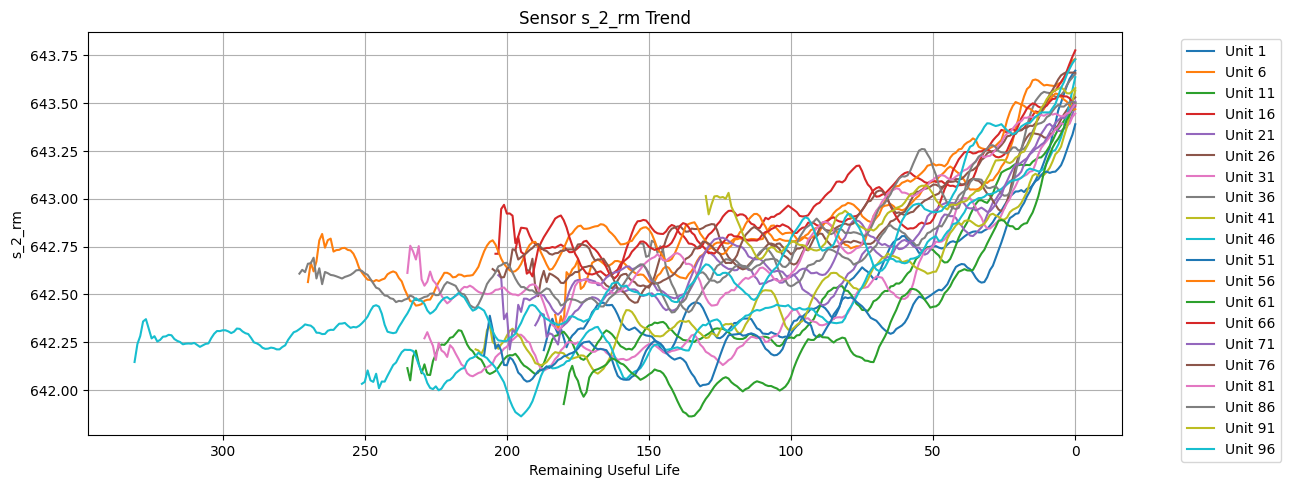

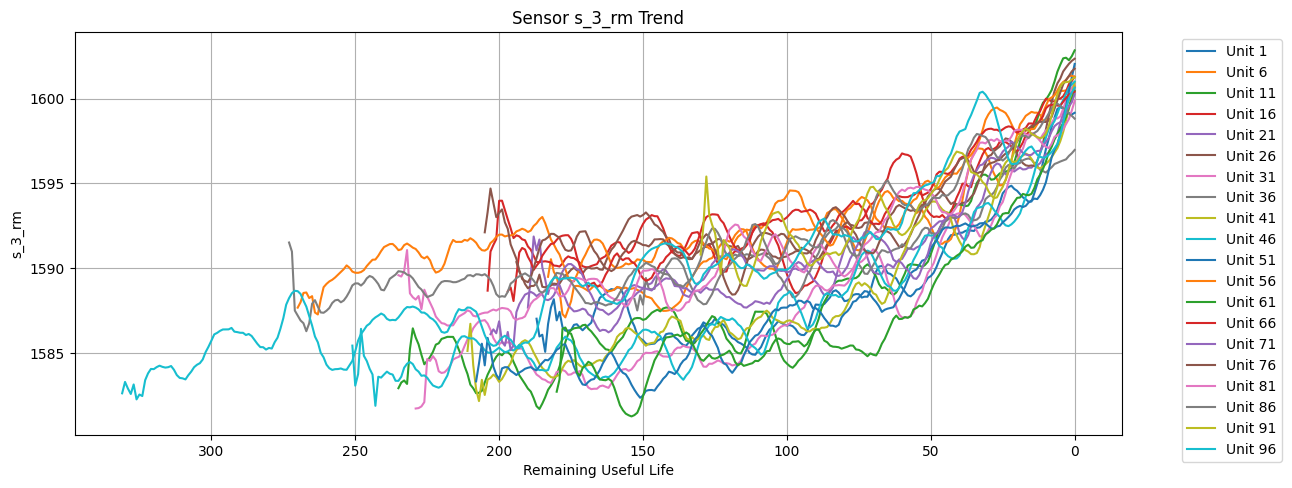

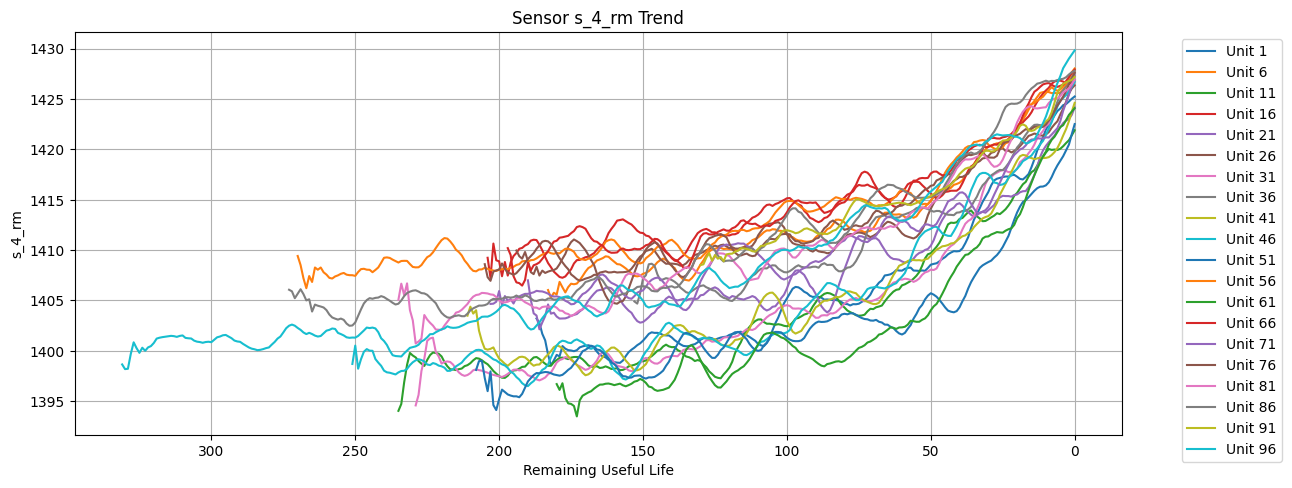

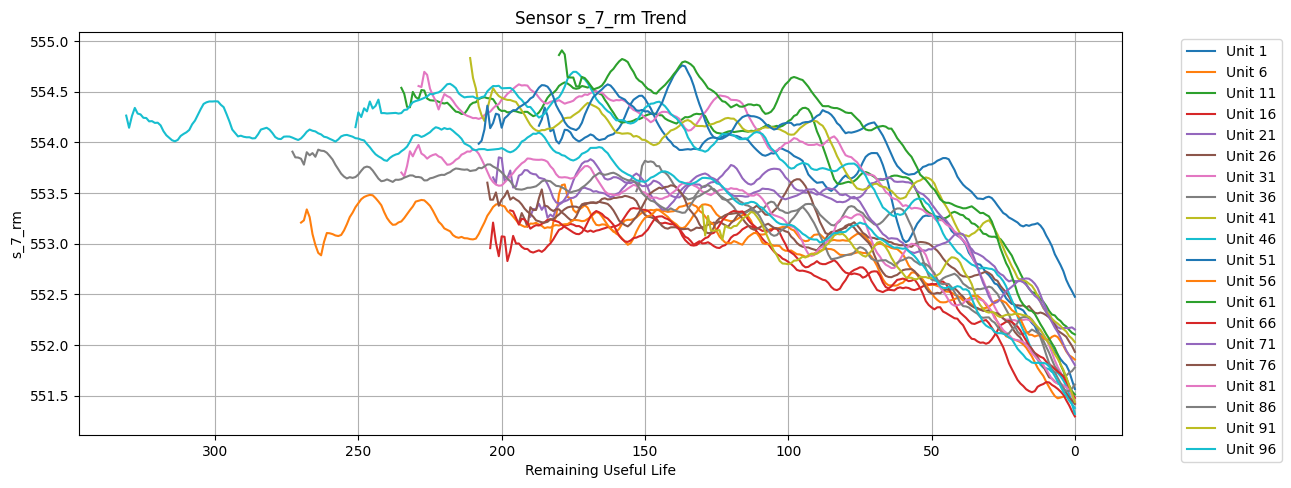

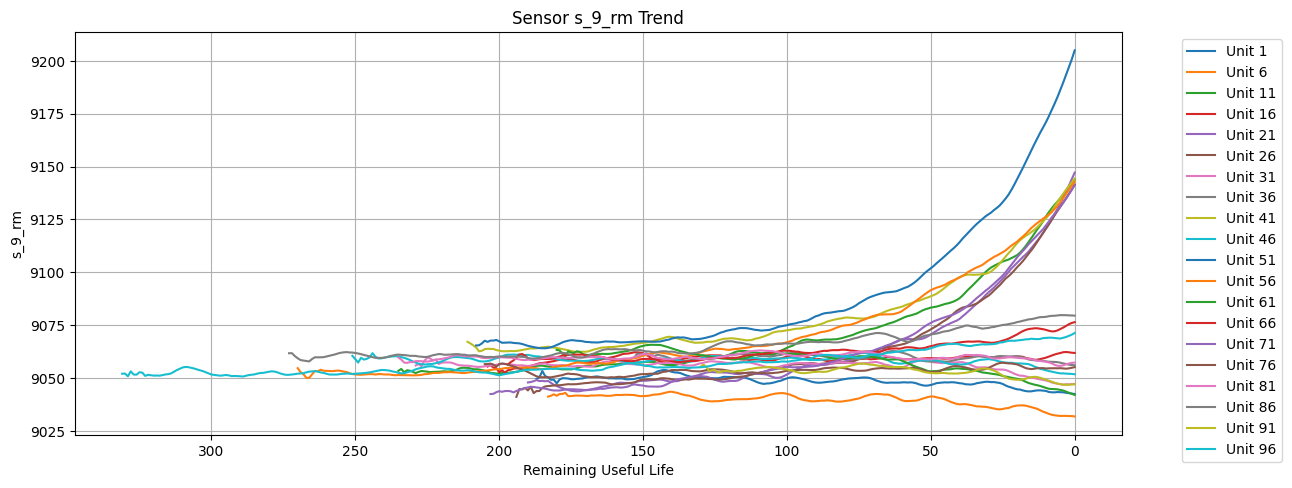

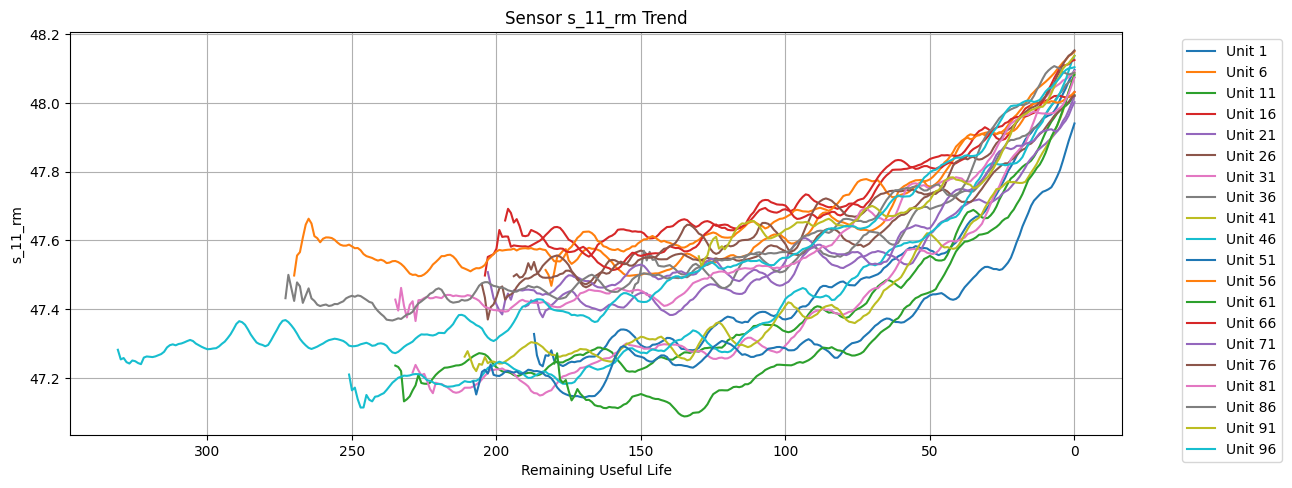

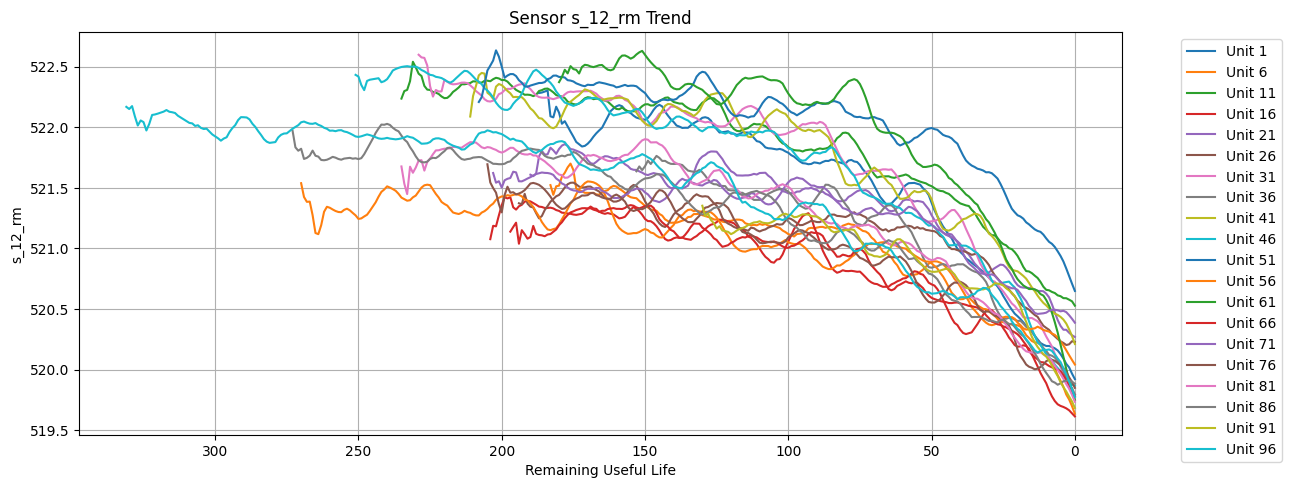

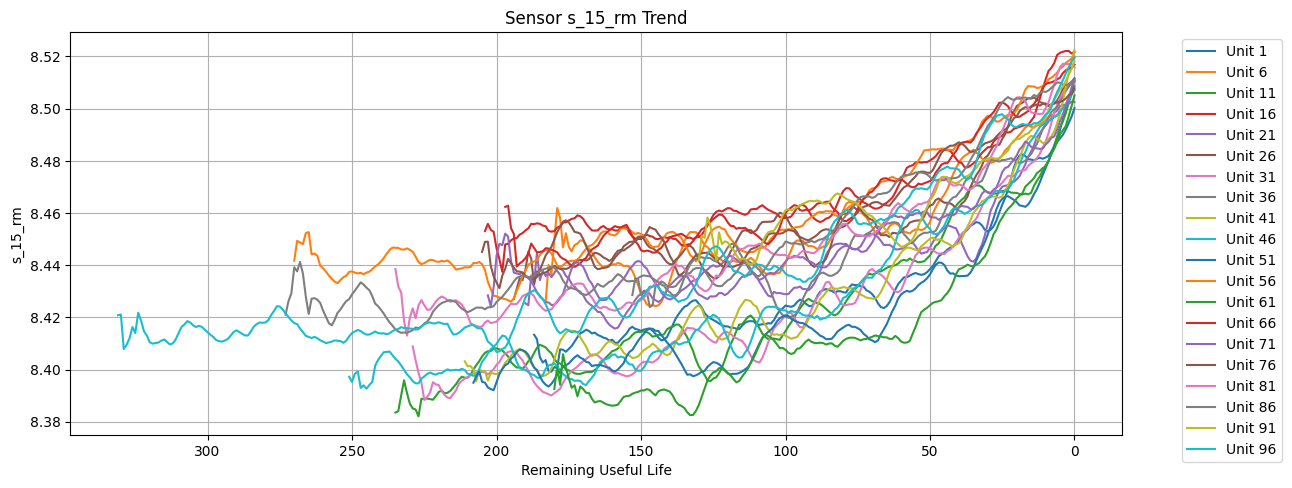

In [ ]:
def enhanced_plot(df, signal_name, units_step=10, window=8):
    plt.figure(figsize=(13,5))
    units = sorted(df['unit_number'].unique())
    
    for i in units[::units_step]:
        unit_data = df[df['unit_number']==i]
        if len(unit_data) > window:  # Ensure enough data
            plt.plot(unit_data['RUL'], 
                    unit_data[signal_name].rolling(window).mean(),
                    label=f'Unit {i}')
    
    plt.gca().invert_xaxis()  # RUL counts down to 0 at failure
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Useful Life')
    plt.title(f'Sensor {signal_name} Trend')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot key sensors only
for sensor in ['s_2_rm', 's_3_rm', 's_4_rm', 's_7_rm',
               's_9_rm', 's_11_rm', 's_12_rm', 's_15_rm']:
    try:
        enhanced_plot(dftm, sensor, units_step=5, window=5)
    except Exception as e:
        print(f"Error plotting {sensor}: {str(e)}")

What we are seeing here is that sensors s_9, s_11, s_12 et s_7 have a significant effect on RUL. For instance, if keep all other features constant, we notice that when the Physical core speed (represented by s_9) increases , the RUL is comparatively decreasing.

# Classification
The data is balanced (2 classes / 3 classes / 4 classes) binning models: random forest, SVC, Naive Bayes, KNN. We will use recall and confusion matrix for evaluation.

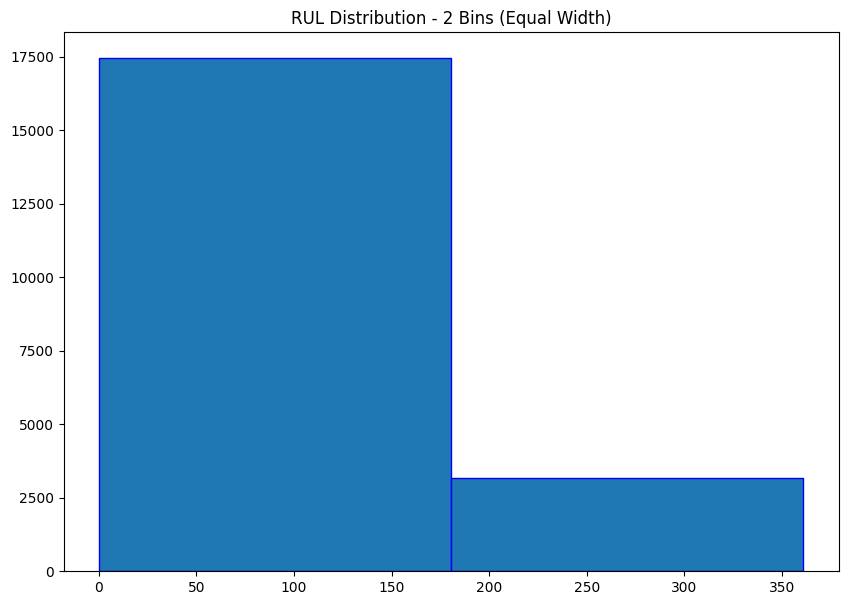

Bin edges: [  0.  180.5 361. ]
Counts: [17462.  3169.]


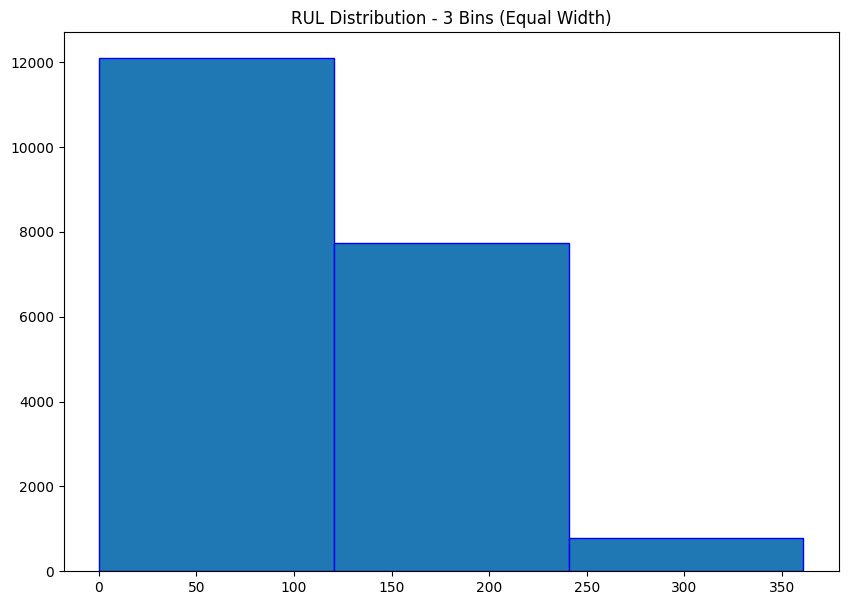

Bin edges: [  0.         120.33333333 240.66666667 361.        ]
Counts: [12100.  7735.   796.]


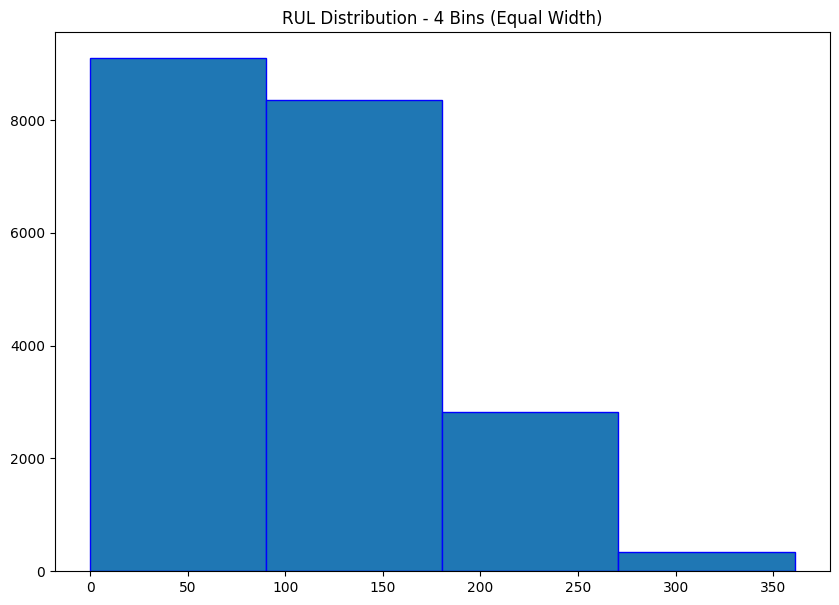

Bin edges: [  0.    90.25 180.5  270.75 361.  ]
Counts: [9100. 8362. 2823.  346.]


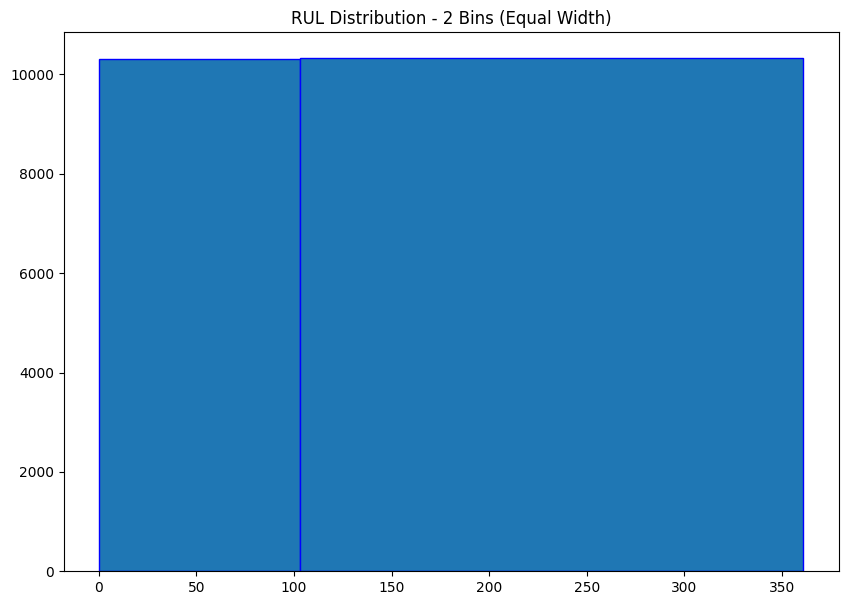

Bin edges: [  0. 103. 361.]
Counts: [10300. 10331.]


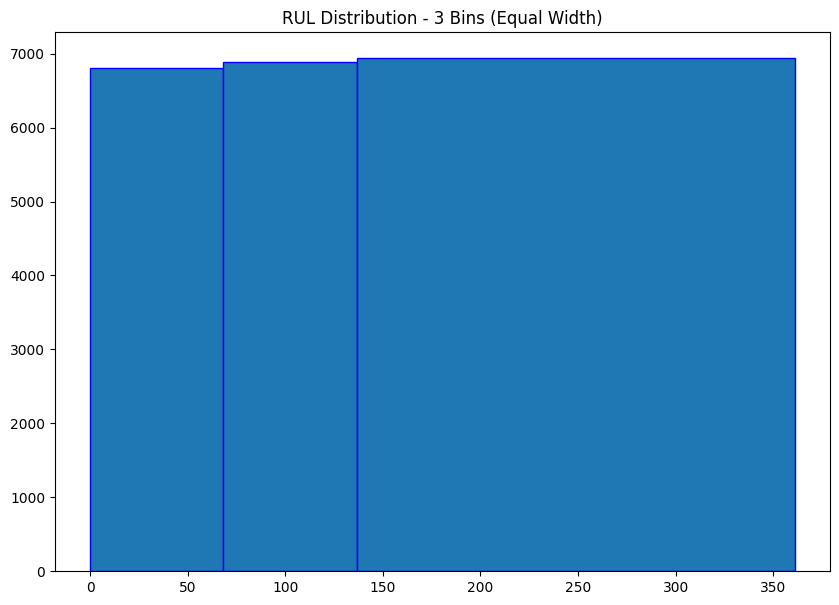

Bin edges: [  0.  68. 137. 361.]
Counts: [6800. 6889. 6942.]


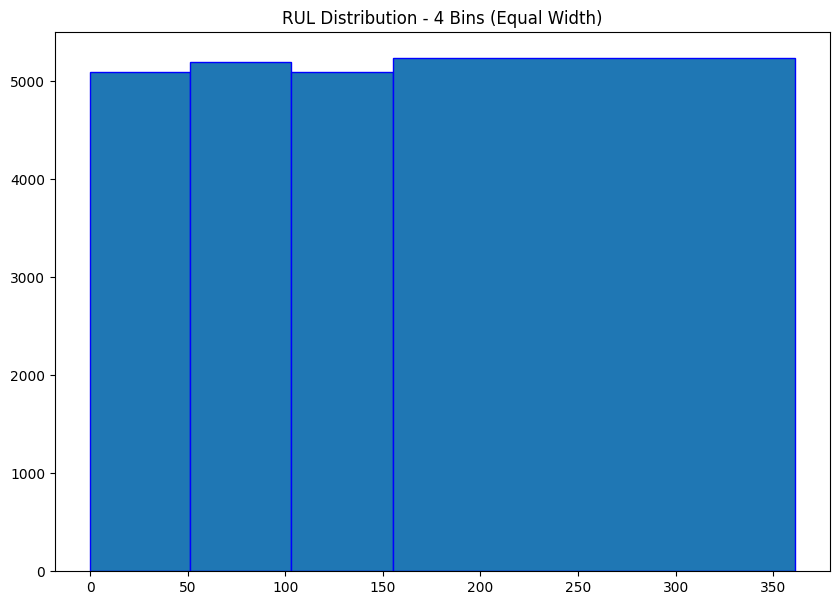

Bin edges: [  0.  51. 103. 155. 361.]
Counts: [5100. 5200. 5092. 5239.]


In [ ]:
# -- Fixing Bins Width --
bins = [2, 3, 4]
for b in bins:
    fig, ax = plt.subplots(figsize=(10, 7))
    counts, bin_edges, _ = ax.hist(df_train['RUL'], bins=b, edgecolor='b')
    ax.set_title(f'RUL Distribution - {b} Bins (Equal Width)')
    plt.show()
    print(f"Bin edges: {bin_edges}")
    print(f"Counts: {counts}")

# -- Fixing Bins Height --
def equalObs(x, nbin):
    return np.quantile(x, np.linspace(0, 1, nbin+1))

for b in bins:
    fig, ax = plt.subplots(figsize=(10, 7))
    counts, bin_edges, _ = plt.hist(df_train['RUL'],
                           equalObs(df_train['RUL'], b),
                           edgecolor='b')
    ax.set_title(f'RUL Distribution - {b} Bins (Equal Width)')
    plt.show()
    print(f"Bin edges: {bin_edges}")
    print(f"Counts: {counts}")



1. Maintenance Planning:
    - Equal-width shows most common failure times
    - Equal-frequency helps set inspection intervals
2. Model Training:
    - Equal-width reveals data skewness
    - Equal-frequency creates balanced bins for classification
3. Threshold Detection:
    - Spikes in equal-width show common failure points
    - Equal-frequency edges mark probability transitions

__Let's suppose we have 3 classes of RUL__
- 1 for RUL $\in \{0, 68\}$: Risk
- 2 for RUL $\in \{69, 137\}$: Moderated Risk
- 3 for RUL $\in \{138, 361\}$ No Risk

In [ ]:
y_train_tm.tail()

11284    107
11964    162
5390      74
860      195
15795    157
Name: RUL, dtype: int64

In [ ]:
def rul_to_risk_class(rul_values, method='percentile', custom_thresholds=None):    
    """
    Convert RUL values to risk classes
    
    Parameters:
    -----------
    rul_values : array-like
        Array of Remaining Useful Life values
    method : str ('percentile' or 'fixed')
        Method for determining class thresholds
    custom_thresholds : tuple or None
        (low, high) thresholds for 'fixed' method
    
    Returns:
    --------
    numpy.ndarray
        Array of risk class labels (1, 2, 3)
    dict
        Dictionary with threshold values used
    """
    if method == 'percentile':
        # Data-driven thresholds (33rd and 66th percentiles)
        low, high = np.percentile(rul_values, [33, 66])
    elif method == 'fixed':
        if custom_thresholds is None:
            # Default fixed thresholds (similar to your original)
            low, high = 68, 137
        else:
            low, high = custom_thresholds
    else:
        raise ValueError("Method must be either 'percentile' or 'fixed'")
    
    # Vectorized class assignment
    classes = np.select(
        condlist=[
            rul_values <= low,
            (rul_values > low) & (rul_values <= high),
            rul_values > high
        ],
        choicelist=[1, 2, 3],
        default=3
    )
    
    return classes, {'low_threshold': low, 'high_threshold': high}

# Label mapping
label_map = {
    1: 'critical_risk',
    2: 'moderate_risk',
    3: 'low_risk'
}

# Using the function (with percentile method)
y, thresholds_used = rul_to_risk_class(dftm['RUL'], method='percentile')
print(f"Used thresholds: {thresholds_used}")
y_valid_c, thresholds_used = rul_to_risk_class(y_valid, method='percentile')
print(f"Threshold for y_validation: {thresholds_used}")
# Create feature matrix
X = dftm.drop(['unit_number', 'RUL'], axis=1, errors='ignore')

# Train-test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y,
    test_size=0.35,
    stratify=y,
    random_state=42
)

def print_class_distribution(y, y_train, y_test):
    print("\nClass Distribution:")
    print(f"Original: {dict(zip(*np.unique(y, return_counts=True)))}")
    print(f"Training: {dict(zip(*np.unique(y_train, return_counts=True)))}")
    print(f"Test:     {dict(zip(*np.unique(y_test, return_counts=True)))}")

print_class_distribution(y, y_train_c, y_test_c)

Used thresholds: {'low_threshold': np.float64(68.0), 'high_threshold': np.float64(136.0)}
Threshold for y_validation: {'low_threshold': np.float64(52.68000000000001), 'high_threshold': np.float64(98.68)}

Class Distribution:
Original: {np.int64(1): np.int64(6900), np.int64(2): np.int64(6789), np.int64(3): np.int64(6942)}
Training: {np.int64(1): np.int64(4485), np.int64(2): np.int64(4413), np.int64(3): np.int64(4512)}
Test:     {np.int64(1): np.int64(2415), np.int64(2): np.int64(2376), np.int64(3): np.int64(2430)}


Nearly perfect 1:1:1 ratio (33% each class), this is excelent because there is no class imbalance issues for ML training, each risk category has equal representation, there is a proper stratification that mirrors training set distribution, which is critical for reliable model evaluation. The _thresholds works well with this data.

### Linear Models (Classification)

In [ ]:
from sklearn.linear_model import (RidgeClassifier, PassiveAggressiveClassifier,
                                LogisticRegression, SGDClassifier)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rs = 17  # Random state for reproducibility

def evaluate(y_true, y_pred, set_name):
    """Enhanced evaluation function with RMSE and R2"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f' {set_name} RMSE: {rmse:.2f} | R2: {r2:.2f}')
    return rmse, r2

# Initialize models
linear_models = {
    'Ridge': RidgeClassifier(random_state=rs),
    'PassiveAggressive': PassiveAggressiveClassifier(random_state=rs),
    'Logistic': LogisticRegression(random_state=rs, max_iter=1000),
    'SGDC': SGDClassifier(loss='log_loss', penalty='elasticnet', random_state=rs)
}

results_linear = {}

for name, model in linear_models.items():
    print(f'\n=== Training {name} ===')
    
    # Create pipeline with scaling
    pipeline = make_pipeline(
        StandardScaler(),
        model
    )
    
    # Fit and predict
    pipeline.fit(X_train_c, y_train_c)
    y_train_pred = pipeline.predict(X_train_c)
    y_valid_pred = pipeline.predict(X_valid3)  # Using validation set
    y_test_pred = pipeline.predict(X_test_c)
    
    # Evaluate
    print('Training Set:')
    train_rmse, train_r2 = evaluate(y_train_c, y_train_pred, 'Train')
    
    print('Validation Set:')
    valid_rmse, valid_r2 = evaluate(y_valid_c, y_valid_pred, 'Valid')
    
    print('Test Set:')
    test_rmse, test_r2 = evaluate(y_test_c, y_test_pred, 'Test')
    
    # Store results
    results_linear[name] = {
        'train_rmse': train_rmse,
        'valid_rmse': valid_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'valid_r2': valid_r2,
        'test_r2': test_r2,
        'model': pipeline
    }

# Enhanced comparison table
print("\n\n=== Model Performance Comparison ===")
print(f"{'Model':<20} | {'Train RMSE':>10} | {'Valid RMSE':>10} | {'Test RMSE':>10} | {'Valid R2':>6}")
print("-"*75)
for name, metrics in sorted(results_linear.items(), key=lambda x: x[1]['valid_rmse']):
    print(f"{name:<20} | {metrics['train_rmse']:10.2f} | {metrics['valid_rmse']:10.2f} | "
          f"{metrics['test_rmse']:10.2f} | {metrics['valid_r2']:6.2f}")
best_linear_name = min(results_linear.items(), key=lambda x: x[1]['valid_rmse'])[0]
best_linear_model = results_linear[best_linear_name]['model']
print(f"\nBest linear model: {best_linear_name}")


=== Training Ridge ===
Training Set:
 Train RMSE: 0.70 | R2: 0.28
Validation Set:
 Valid RMSE: 0.67 | R2: 0.33
Test Set:
 Test RMSE: 0.70 | R2: 0.28

=== Training PassiveAggressive ===
Training Set:
 Train RMSE: 0.71 | R2: 0.24
Validation Set:
 Valid RMSE: 0.69 | R2: 0.30
Test Set:
 Test RMSE: 0.71 | R2: 0.25

=== Training Logistic ===
Training Set:
 Train RMSE: 0.58 | R2: 0.50
Validation Set:
 Valid RMSE: 0.55 | R2: 0.55
Test Set:
 Test RMSE: 0.57 | R2: 0.52

=== Training SGDC ===
Training Set:
 Train RMSE: 0.62 | R2: 0.42
Validation Set:
 Valid RMSE: 0.64 | R2: 0.39
Test Set:
 Test RMSE: 0.62 | R2: 0.43


=== Model Performance Comparison ===
Model                | Train RMSE | Valid RMSE |  Test RMSE | Valid R2
---------------------------------------------------------------------------
Logistic             |       0.58 |       0.55 |       0.57 |   0.55
SGDC                 |       0.62 |       0.64 |       0.62 |   0.39
Ridge                |       0.70 |       0.67 |       0.70 | 

### Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
rs = 17 
svm_models = {
    'LinearSVM': LinearSVC(random_state=rs, max_iter=10000),
    'SVM-RBF': SVC(kernel='rbf', random_state=rs),
    'SVM-Poly': SVC(kernel='poly', degree=2, random_state=rs),
    'SVM-Sigmoid': SVC(kernel='sigmoid', random_state=rs)
}

results_svm = {}

for name, model in svm_models.items():
    print(f'\n=== Training {name} ===')
    
    # Create pipeline with scaling (critical for SVMs)
    pipeline = make_pipeline(
        StandardScaler(),
        model
    )
    
    # Fit and predict
    pipeline.fit(X_train_c, y_train_c)
    y_train_pred = pipeline.predict(X_train_c)
    y_valid_pred = pipeline.predict(X_valid_s)
    y_test_pred = pipeline.predict(X_test_c)
    
    # Evaluate
    print('Training Set:')
    train_rmse, train_r2 = evaluate(y_train_c, y_train_pred, 'Train')
    
    print('Validation Set:')
    valid_rmse, valid_r2 = evaluate(y_valid_c, y_valid_pred, 'Valid')
    
    print('Test Set:')
    test_rmse, test_r2 = evaluate(y_test_c, y_test_pred, 'Test')
    
    # Store results
    results_svm[name] = {
        'train_rmse': train_rmse,
        'valid_rmse': valid_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'valid_r2': valid_r2,
        'test_r2': test_r2,
        'model': pipeline
    }

# Enhanced comparison table
print("\n\n=== SVM Model Performance Comparison ===")
print(f"{'Model':<20} | {'Train RMSE':>10} | {'Valid RMSE':>10} | {'Test RMSE':>10} | {'Valid R2':>6}")
print("-"*75)
for name, metrics in sorted(results_svm.items(), key=lambda x: x[1]['valid_rmse']):
    print(f"{name:<20} | {metrics['train_rmse']:10.2f} | {metrics['valid_rmse']:10.2f} | "
          f"{metrics['test_rmse']:10.2f} | {metrics['valid_r2']:6.2f}")

# Store the best model
best_svm_name = min(results_svm.items(), key=lambda x: x[1]['valid_rmse'])[0]
best_svm_model = results_svm[best_svm_name]['model']
print(f"\nBest SVM model: {best_svm_name}")


=== Training LinearSVM ===
Training Set:
 Train RMSE: 0.64 | R2: 0.39
Validation Set:
 Valid RMSE: 0.62 | R2: 0.43
Test Set:
 Test RMSE: 0.63 | R2: 0.40

=== Training SVM-RBF ===
Training Set:
 Train RMSE: 0.55 | R2: 0.55
Validation Set:
 Valid RMSE: 0.56 | R2: 0.54
Test Set:
 Test RMSE: 0.56 | R2: 0.53

=== Training SVM-Poly ===
Training Set:
 Train RMSE: 0.76 | R2: 0.14
Validation Set:
 Valid RMSE: 0.80 | R2: 0.04
Test Set:
 Test RMSE: 0.77 | R2: 0.12

=== Training SVM-Sigmoid ===
Training Set:
 Train RMSE: 0.88 | R2: -0.16
Validation Set:
 Valid RMSE: 0.88 | R2: -0.16
Test Set:
 Test RMSE: 0.88 | R2: -0.16


=== SVM Model Performance Comparison ===
Model                | Train RMSE | Valid RMSE |  Test RMSE | Valid R2
---------------------------------------------------------------------------
SVM-RBF              |       0.55 |       0.56 |       0.56 |   0.54
LinearSVM            |       0.64 |       0.62 |       0.63 |   0.43
SVM-Poly             |       0.76 |       0.80 |      

### Ensemble (Classification)

In [ ]:
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                            AdaBoostClassifier, ExtraTreesClassifier)
rs = 17  # Random state for reproducibility

def evaluate(y_true, y_pred, set_name):
    """Evaluation function with RMSE and R2"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f' {set_name} RMSE: {rmse:.2f} | R2: {r2:.2f}')
    return rmse, r2

# Initialize ensemble models
ensemble_models = {
    'RandomForest': RandomForestClassifier(random_state=rs, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=rs),
    'AdaBoost': AdaBoostClassifier(random_state=rs),
    'ExtraTrees': ExtraTreesClassifier(random_state=rs, n_jobs=-1)
}

results_ensemble = {}

for name, model in ensemble_models.items():
    print(f'\n=== Training {name} ===')
    
    # Create pipeline (scaling optional for trees, but good practice)
    pipeline = make_pipeline(
        StandardScaler(),  # Can remove if you want pure tree performance
        model
    )
    
    # Fit and predict
    pipeline.fit(X_train_c, y_train_c)
    y_train_pred = pipeline.predict(X_train_c)
    y_valid_pred = pipeline.predict(X_valid3)
    y_test_pred = pipeline.predict(X_test_c)
    
    # Evaluate
    print('Training Set:')
    train_rmse, train_r2 = evaluate(y_train_c, y_train_pred, 'Train')
    
    print('Validation Set:')
    valid_rmse, valid_r2 = evaluate(y_valid_c, y_valid_pred, 'Valid')
    
    print('Test Set:')
    test_rmse, test_r2 = evaluate(y_test_c, y_test_pred, 'Test')
    
    # Store results
    results_ensemble[name] = {
        'train_rmse': train_rmse,
        'valid_rmse': valid_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'valid_r2': valid_r2,
        'test_r2': test_r2,
        'model': pipeline
    }

# Comparison table
print("\n\n=== Ensemble Model Performance Comparison ===")
print(f"{'Model':<20} | {'Train RMSE':>10} | {'Valid RMSE':>10} | {'Test RMSE':>10} | {'Valid R2':>6}")
print("-"*75)
for name, metrics in sorted(results_ensemble.items(), key=lambda x: x[1]['valid_rmse']):
    print(f"{name:<20} | {metrics['train_rmse']:10.2f} | {metrics['valid_rmse']:10.2f} | "
          f"{metrics['test_rmse']:10.2f} | {metrics['valid_r2']:6.2f}")

# Store the best model
best_ensemble_name = min(results_ensemble.items(), key=lambda x: x[1]['valid_rmse'])[0]
best_ensemble_model = results_ensemble[best_ensemble_name]['model']
print(f"\nBest ensemble model: {best_ensemble_name}")

# Feature importance analysis (for tree-based models)
if hasattr(best_ensemble_model.named_steps[best_ensemble_name], 'feature_importances_'):
    importances = best_ensemble_model.named_steps[best_ensemble_name].feature_importances_
    print("\nTop 10 Important Features:")
    sorted_idx = np.argsort(importances)[-10:]
    for idx in sorted_idx:
        print(f"{X_train_c.columns[idx]}: {importances[idx]:.4f}")


=== Training RandomForest ===
Training Set:
 Train RMSE: 0.00 | R2: 1.00
Validation Set:
 Valid RMSE: 0.59 | R2: 0.48
Test Set:
 Test RMSE: 0.46 | R2: 0.68

=== Training GradientBoosting ===
Training Set:
 Train RMSE: 0.48 | R2: 0.66
Validation Set:
 Valid RMSE: 0.57 | R2: 0.51
Test Set:
 Test RMSE: 0.53 | R2: 0.59

=== Training AdaBoost ===
Training Set:
 Train RMSE: 0.60 | R2: 0.47
Validation Set:
 Valid RMSE: 0.53 | R2: 0.58
Test Set:
 Test RMSE: 0.61 | R2: 0.45

=== Training ExtraTrees ===
Training Set:
 Train RMSE: 0.00 | R2: 1.00
Validation Set:
 Valid RMSE: 0.57 | R2: 0.52
Test Set:
 Test RMSE: 0.48 | R2: 0.66


=== Ensemble Model Performance Comparison ===
Model                | Train RMSE | Valid RMSE |  Test RMSE | Valid R2
---------------------------------------------------------------------------
AdaBoost             |       0.60 |       0.53 |       0.61 |   0.58
ExtraTrees           |       0.00 |       0.57 |       0.48 |   0.52
GradientBoosting     |       0.48 |      

KeyError: 'AdaBoost'